In [ ]:
wd = '~/EH for sampling/Yong/'

# shared funcs.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from matplotlib.colors import LinearSegmentedColormap, Normalize
import os
import time
import pickle
from scipy.spatial.distance import cdist
import copy
from scipy.stats import multivariate_normal
from scipy.stats import norm

np.random.seed(111)

# Metropolis-Hastings sampling for generating ground truth samples
def metropolis_hastings(target_p, num_samples, proposal_std=1.0):
    # Initial guess
    x_current = np.random.randn(2)
    samples = []

    for _ in range(num_samples):
        # Propose a new point
        x_proposal = x_current + np.random.randn(2) * proposal_std

        # Calculate acceptance ratio
        acceptance_ratio = target_p(x_proposal) / target_p(x_current)

        # Accept or reject the new point
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposal

        samples.append(x_current)

    return np.array(samples)

# compute the comparison metric MMD**2
def polynomial_kernel(x, y):
    return (np.dot(x, y.T) / 3 + 1) ** 3
def compute_mmd2(X, Y):
    N = X.shape[0]
    M = Y.shape[0]
    # Compute the polynomial kernel values
    Kxx = polynomial_kernel(X, X)  # Kernel between all pairs in X
    Kyy = polynomial_kernel(Y, Y)  # Kernel between all pairs in Y
    Kxy = polynomial_kernel(X, Y)  # Kernel between all pairs in X and Y
    # Compute the terms in the MMD squared formula
    term1 = (1 / (N * N)) * np.sum(Kxx)
    term2 = (1 / (M * M)) * np.sum(Kyy)
    term3 = (2 / (N * M)) * np.sum(Kxy)
    # Compute MMD squared
    mmd2 = term1 + term2 - term3
    return mmd2
# X = np.random.randn(200, 2)
# Y = np.random.randn(5000, 2)
# mmd2_value = compute_mmd2(X, Y)
# print(f"MMD^2: {mmd2_value}")

# General parameters (can be over-written later for each individual case)
def set_params(update_rule, overwrite_params_dict=None):
    M_neg = 400  # Number of negative charges
    M_pos = 50**2  # Number of positive charges
    d = 2        # Dimensionality
    q_neg = np.ones(M_neg)  # Charge of negative particles
    q_pos = 1.0             # Charge of positive particles
    q_pos_auto_annealing = False
    epsilon_0 = 8.854e-12   # Permittivity of free space; alternatively: 55.26349406

    SEED = 111              # Random seed for reproducibility
    num_steps = 100         # Number of time steps
    plot_interval = 5       # Plot every 10 steps
    normalize_overall_forces = True # Whether to normalize forces or not. It affects the choose of step size later.
    normalise_attr_forces = False    # Whether to normalize attracting forces or not
    particle_filtering = False
    move_threshold = 1e-4   # Movement threshold for early stopping
    patience = 5            # Number of consecutive steps with small movements to trigger early stopping

    tau = 0.1
    delta_t = 0.01
    noise_std = 0

    if update_rule == 'Euler':
        tau = 0.1              # Time step size
        noise_std = 0.01       # Standard deviation for Gaussian noise added to the positions
    elif update_rule == 'Verlet':
        q_pos = 5.0
        num_steps = 300
        delta_t = 0.01          # Time step size
        noise_std = 0           # Standard deviation for Gaussian noise added to the positions
    elif update_rule == 'damped_Verlet':
        q_pos = 5.0
        num_steps = 300
        tau = 0.5               # Parameter tau
        delta_t = 0.1           # Time step size
        noise_std = 0

    params_dict = {
        'M_neg': M_neg,
        'M_pos': M_pos,
        'd': d,
        'q_neg': q_neg,
        'q_pos': q_pos,
        'q_pos_auto_annealing': q_pos_auto_annealing,
        'epsilon_0': epsilon_0,
        'SEED': SEED,
        'num_steps': num_steps,
        'plot_interval': plot_interval,
        'normalize_overall_forces': normalize_overall_forces,
        'normalise_attr_forces': normalise_attr_forces,
        'particle_filtering': particle_filtering,
        'move_threshold': move_threshold,
        'patience': patience,
        'tau': tau,
        'delta_t': delta_t,
        'noise_std': noise_std
    }
    # overwrite parameters if provided
    if overwrite_params_dict is not None:
        for key, value in overwrite_params_dict.items():
            if key in params_dict:
                params_dict[key] = value

    return params_dict

def initialize_positions(target_p, M_neg, M_pos, d, init_dict=None, SEED=111):
    np.random.seed(SEED)

    init_type = init_dict['init_type']

    # Initialize the positions of the positive charges on a grid within [low_xy, high_xy] x [low_xy, high_xy]
    grid_size = int(np.ceil(M_pos**(1/d)))
    linspace = np.linspace(init_dict['low_xy'], init_dict['high_xy'], grid_size)
    mesh = np.meshgrid(*([linspace]*d))
    x_pos = np.vstack([m.ravel() for m in mesh]).T[:M_pos]

    # Initialize the positions of the negative charges within [low_uniform, high_uniform] x [low_uniform, high_uniform]
    if init_type == 'uniform':
        uniform_boundaries = [(init_dict['low_uniform'], init_dict['high_uniform']), (init_dict['low_uniform'], init_dict['high_uniform'])]
        x_neg = np.random.uniform(
            low=[low for (low, high) in uniform_boundaries],
            high=[high for (low, high) in uniform_boundaries],
            size=(M_neg, d)
        )
    elif init_type == 'gaussian':
        x_neg = np.random.normal(loc=init_dict['initial_gaussian_center'], scale=init_dict['initial_gaussian_std'], size=(M_neg, d))
        x_neg = np.clip(x_neg, init_dict['low_xy'], init_dict['high_xy'])
    elif init_type == 'probabilistic':
        # Grid points
        grid_size = 100
        linspace = np.linspace(init_dict['low_xy'], init_dict['high_xy'], grid_size)
        mesh = np.meshgrid(*([linspace] * d))
        grid_points = np.vstack([m.ravel() for m in mesh]).T

        # Compute probability mass at each grid point
        probabilities = target_p(grid_points)
        probabilities = probabilities.flatten()
        probabilities /= np.sum(probabilities)  # Normalize to sum to 1

        # Sample indices based on the probabilities
        sampled_indices = np.random.choice(len(grid_points), size=M_neg, p=probabilities)
        x_neg = grid_points[sampled_indices]
    else:
        raise ValueError("init_type must be either 'uniform', 'gaussian', or 'probabilistic'")

    return x_neg, x_pos

def compute_forces(x_neg, x_pos, q_neg, q_pos, target_p, epsilon_0, d, normalise_attr_forces):
    M_neg = x_neg.shape[0]
    M_pos = x_pos.shape[0]

    F_rep = np.zeros_like(x_neg)
    F_attr = np.zeros_like(x_neg)

    # Compute the normalization constant for target_p if normalization is enabled
    if normalise_attr_forces:
        attr_normalization_constant = np.sum([target_p(x_pos[i_prime]) for i_prime in range(M_pos)])
    else:
        attr_normalization_constant = 1  # Set to 1 to avoid altering the target_p values

    # Compute repulsive forces
    for j in range(M_neg):
        for i in range(M_neg):
            if i != j:
                r_ij = np.linalg.norm(x_neg[j] - x_neg[i])
                if r_ij > 0:
                    F_rep[j] += (q_neg[i] * q_neg[j] * gamma(d/2)) / (2 * np.pi**(d/2) * epsilon_0 * r_ij**(d-1)) * (x_neg[j] - x_neg[i]) / r_ij
    # Compute attractive forces
    for j in range(M_neg):
        for i_prime in range(M_pos):
            r_ij = np.linalg.norm(x_neg[j] - x_pos[i_prime])
            if r_ij > 0:
                normalized_target_p = target_p(x_pos[i_prime]) / attr_normalization_constant
                F_attr[j] -= (q_pos * normalized_target_p * q_neg[j] * gamma(d/2)) / (2 * np.pi**(d/2) * epsilon_0 * r_ij**(d-1)) * (x_neg[j] - x_pos[i_prime]) / r_ij

    print(f'F_rep:\n {F_rep[:10]} \n F_attr:\n {F_attr[:10]}')
    return F_rep, F_attr, F_rep + F_attr

def plot_density(target_p, x_min, x_max, y_min, y_max, num_points=100):
    x = np.linspace(x_min, x_max, num_points)
    y = np.linspace(y_min, y_max, num_points)
    X, Y = np.meshgrid(x, y)
    Z = np.array([target_p(np.array([x, y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)

    # create a custom white-dark pink colormap
    colors = [(1, 1, 1), (0.6, 0, 0.3)]  # white to dark pink
    n_bins = 100  # Discretize the interpolation into 100 steps
    cmap_name = 'white_dark_pink'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    return X, Y, Z, cm

def evolve_system(init_dict, update_rule, x_neg, x_pos, params_dict, target_p, ground_truth_samples):
    d = params_dict['d']
    q_neg = params_dict['q_neg']
    q_pos = params_dict['q_pos']
    q_pos_auto_annealing = params_dict['q_pos_auto_annealing']
    num_steps = params_dict['num_steps']
    plot_interval = params_dict['plot_interval']
    normalize_overall_forces = params_dict['normalize_overall_forces']
    normalise_attr_forces = params_dict['normalise_attr_forces']
    particle_filtering = params_dict['particle_filtering']
    move_threshold = params_dict['move_threshold']
    patience = params_dict['patience']
    noise_std = params_dict['noise_std']
    delta_t = params_dict['delta_t']
    epsilon_0 = params_dict['epsilon_0']
    tau = params_dict['tau']
    low_xy = init_dict['low_xy']
    high_xy = init_dict['high_xy']
    margin = init_dict['margin']

    x_neg_prev = x_neg.copy()
    consecutive_small_moves = 0

    # create a dict to store all negative particle trajectories
    all_trajectories = {idx: [] for idx in range(params_dict['M_neg'])}

    # plot theoretical density
    fig, ax = plt.subplots(figsize=(8, 6))
    X, Y, Z, cm = plot_density(target_p, low_xy-margin, high_xy+margin, low_xy-margin, high_xy+margin)
    img = ax.imshow(Z, extent=(low_xy-margin, high_xy+margin, low_xy-margin, high_xy+margin), origin='lower', cmap=cm, alpha=0.5)

    if not os.path.exists('plots'):
        os.makedirs('plots')

    # Move negative particles
    particle_counts_vec = []
    remained_neg_indices_all_iterations = []
    removed_neg_indices_all_iterations = []
    original_neg_indices = np.arange(params_dict['M_neg'])
    if q_pos_auto_annealing and normalise_attr_forces: # then q_pos=params_dict['q_pos'] is interpreted as how many times at initial the positive charge is
        init_F_rep = compute_forces(x_neg, x_pos, q_neg, q_pos, target_p, epsilon_0, d, normalise_attr_forces)[0]
        init_distances = cdist(x_neg, x_pos, metric='euclidean')
        median_init_distances = np.median(init_distances.flatten())
        q_pos0 = q_pos * np.max(np.abs(init_F_rep)) * median_init_distances**(d-1) * epsilon_0 * 2 * np.pi**(d/2) / (q_neg[0] * gamma(d/2))
        q_pos = copy.deepcopy(q_pos0)
    print(f'q_pos: {q_pos}')
    step_time_vec = []
    MMD2_vec = []
    NLL_vec = []
    for t in range(num_steps):
        print(f'step: {t}')
        start_time = time.time()

        # count how many of x_neg are lying within the square [low_xy,high_xy]×[low_xy,high_xy] in the current iteration.
        mask = (x_neg[:, 0] >= low_xy) & (x_neg[:, 0] <= high_xy) & (x_neg[:, 1] >= low_xy) & (x_neg[:, 1] <= high_xy)
        count = np.sum(mask); particle_counts_vec.append(count)
        print(f'no. of negative charges currently contained within the square [{low_xy},{high_xy}] (particle_filtering:{particle_filtering}): {count}')
        if particle_filtering: # remove those negative charges falling outside
            x_neg = x_neg[mask]
            remained_indices = original_neg_indices[mask]
            removed_indices = original_neg_indices[~mask]
            remained_neg_indices_all_iterations.append(remained_indices.tolist())
            removed_neg_indices_all_iterations.append(removed_indices.tolist())
            original_neg_indices = remained_indices
        else:
            remained_indices = original_neg_indices

        # attach the trajectories
        for idx_original, idx_new in zip(remained_indices, np.arange(len(remained_indices))):
            all_trajectories[idx_original].append(x_neg[idx_new].copy())

        # compute MMD^2 and mean logp
        mmd2_value = compute_mmd2(x_neg[remained_indices], ground_truth_samples); MMD2_vec.append(mmd2_value)
        nll_value = -np.mean(np.log(target_p(x_neg[remained_indices])+1e-10)); NLL_vec.append(nll_value)

        # plot intermediate figures
        if t % plot_interval == 0 or t == num_steps - 1:

            # plot negative particles
            ax.clear()
            img = ax.imshow(Z, extent=(low_xy-margin, high_xy+margin, low_xy-margin, high_xy+margin), origin='lower', cmap=cm, alpha=0.5)
            scatter_neg = ax.scatter(x_neg[:, 0], x_neg[:, 1], c='blue', s=3, label='Negative charges')

            # Color the positive charges based on their probability values
            # pos_p_values = target_p(x_pos)
            # norm = Normalize(vmin=np.min(pos_p_values), vmax=np.max(pos_p_values))
            # pos_colors = plt.cm.autumn(norm(pos_p_values))
            # scatter_pos = ax.scatter(x_pos[:, 0], x_pos[:, 1], facecolor=pos_colors, label='Positive charges', marker='o', s=1, linewidths=1.5)

            # Draw grid lines aligned with the positive charge positions
            # grid_lines = np.unique(x_pos)
            # ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)
            # ax.set_xticks(grid_lines[::10])
            # ax.set_yticks(grid_lines[::10])
            ax.set_xlim(low_xy-margin, high_xy+margin)
            ax.set_ylim(low_xy-margin, high_xy+margin)
            ax.set_xlabel(r'$x_1$')
            ax.set_ylabel(r'$x_2$')
            ax.set_title(f'Distribution of charges at Step {t}')
            # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
            # save the figure
            plt.savefig(wd+f'plots/step_{t}.png')

        # Now x_neg, x_pos (and q_pos) are both set up, we are ready to comput the forces.
        F_rep, F_attr, F = compute_forces(x_neg, x_pos, q_neg, q_pos, target_p, epsilon_0, d, normalise_attr_forces)
        if normalize_overall_forces:
            # Normalize the force vectors for each particle
            norm_F = np.linalg.norm(F, axis=1).reshape(-1, 1)
            norm_F[norm_F == 0] = 1  # Avoid division by zero
            F = F / norm_F

        if update_rule == 'Euler':
            # Simple Euler method
            delta_x = tau * F
        elif update_rule == 'Verlet':
            # Verlet Integration (Leapfrog Method)
            delta_x = F * (delta_t ** 2) + 2 * x_neg - x_neg_prev - x_neg
        elif update_rule == 'damped_Verlet':
            # Damped Verlet Integration (Modified Method)
            delta_x = tau * (F * (delta_t ** 2) + (x_neg - x_neg_prev))
        else:
            raise ValueError("Invalid update rule specified.")

        x_neg_next = x_neg + delta_x

        # Add Gaussian noise to the positions
        noise = np.random.normal(loc=0, scale=noise_std, size=x_neg.shape)
        x_neg_next += noise

        # Update positions
        x_neg_prev = x_neg.copy()
        x_neg = x_neg_next

        # annealing q_pos
        if q_pos_auto_annealing and normalise_attr_forces:
            q_pos = np.max([(q_pos0 - 1) * np.exp(-0.1 * t) + 1, 0.5*q_pos0]) # q_pos decreases from q_pos and lower bounded by 1 = q_neg
        print(f'q_pos: {q_pos}')

        end_time = time.time(); step_time = end_time - start_time; print(f'step time: {step_time} seconds')
        step_time_vec.append(step_time)

        # save x_neg in each iteration
        np.savez(wd+f'plots/[step:{t}: x_neg, x_pos, step_time, mmd2_value, nll_value].npz',
                 x_neg=x_neg, x_pos=x_pos, step_time=step_time, mmd2_value=mmd2_value, nll_value=nll_value)

        # check for early stopping
        if np.all(np.linalg.norm(delta_x + noise, axis=1) < move_threshold):
            consecutive_small_moves += 1
        else:
            consecutive_small_moves = 0

        if consecutive_small_moves >= patience:
            print(f"Early stopping at step {t} due to small movements.")
            break

    return x_neg, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec

# plot the all_trajectories of selected particles
def trajectory_plot(all_trajectories, selected_indices, target_p, x_pos, low_xy, high_xy, margin, params_dict, init_dict, total_time):
    fig, ax = plt.subplots(figsize=(8, 6))
    X, Y, Z, cm = plot_density(target_p, low_xy-margin, high_xy+margin, low_xy-margin, high_xy+margin)
    img = ax.imshow(Z, extent=(low_xy-margin, high_xy+margin, low_xy-margin, high_xy+margin), origin='lower', cmap=cm, alpha=0.5)

    # Plot positive charges
    norm = Normalize(vmin=np.min(target_p(x_pos)), vmax=np.max(target_p(x_pos)))
    pos_colors = plt.cm.autumn(norm(target_p(x_pos)))
    scatter_pos = ax.scatter(x_pos[:, 0], x_pos[:, 1], facecolor=pos_colors, label='Positive charges', marker='o', s=1, linewidths=1.5)
    grid_lines = np.unique(x_pos)
    ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    ax.set_xticks(grid_lines[::10])
    ax.set_yticks(grid_lines[::10])

    # Create a colormap for the trajectories
    num_colors = len(selected_indices)
    colors = plt.cm.viridis(np.linspace(0, 1, num_colors))

    # Plot all trajectories
    for idx, color in zip(selected_indices, colors):
        traj = np.array(all_trajectories[idx])
        ax.plot(traj[:, 0], traj[:, 1], color=color, label='Trajectory' if idx == selected_indices[0] else "")  # Plot entire trajectory
        ax.scatter(traj[0, 0], traj[0, 1], color=color, marker='o', s=60, label='Initial position' if idx == selected_indices[0] else "")  # Initial position
        ax.scatter(traj[-1, 0], traj[-1, 1], color=color, marker='s', s=60, label='Final position' if idx == selected_indices[0] else "")  # Final position

    ax.set_xlim(low_xy-margin, high_xy+margin)
    ax.set_ylim(low_xy-margin, high_xy+margin)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title('Trajectories of selected particles')
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.savefig(wd+f"plots/selected_trajectories (M_neg:{params_dict['M_neg']},M_pos:{params_dict['M_pos']},num_steps:{params_dict['num_steps']},init_type:{init_dict['init_type']},total_time:{total_time}).png")
    plt.show()

# Gaussian2D: uni-modal.

Streaming output truncated to the last 5000 lines.
no. of negative charges currently contained within the square [0,1] (particle_filtering:False): 391
F_rep:
 [[ 2.77989066e+12 -1.83751527e+13]
 [ 4.23807822e+11  1.18016847e+13]
 [-1.01517005e+13 -1.75565304e+13]
 [-1.49535903e+13  3.33673389e+11]
 [-1.69122361e+13 -1.01286472e+13]
 [ 2.20505235e+13 -8.57675055e+12]
 [-1.75969081e+13  3.59224070e+12]
 [ 4.90158556e+12 -1.44676969e+13]
 [-1.98042365e+12 -1.75745443e+13]
 [-1.25863739e+13  1.27005738e+13]] 
 F_attr:
 [[-1.63262539e+13  1.24464974e+13]
 [-1.19854242e+13 -1.64584826e+13]
 [ 5.84746789e+11  1.25496718e+13]
 [ 2.62257623e+13 -7.26124443e+12]
 [ 5.16912735e+12 -7.13345900e+11]
 [-2.53093096e+13 -2.32732942e+12]
 [ 2.23018566e+13 -2.04121301e+13]
 [-1.84807930e+13  3.47336238e+12]
 [-6.55772111e+12  1.74803854e+13]
 [ 1.22424327e+13 -2.43009418e+13]]
q_pos: 1.0
step: 101
no. of negative charges currently contained within the square [0,1] (particle_filtering:False): 391
F_rep:


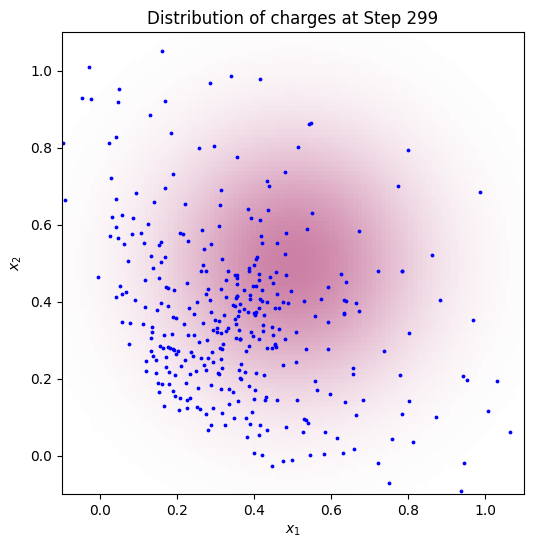

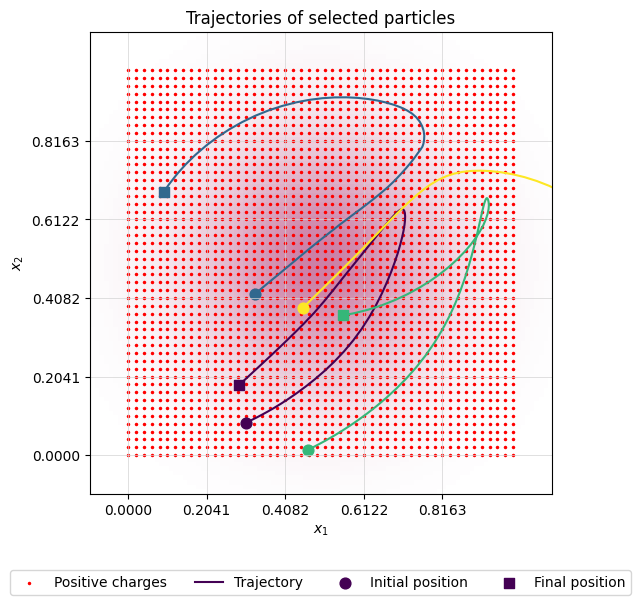

In [ ]:
np.random.seed(111)
def target_p(x):
    return np.exp(-np.sum((x - 0.5)**2) / 0.1)

update_rule = 'Verlet'
params_dict = set_params(update_rule,{'q_pos': 1.0,
                                      'q_pos_auto_annealing': False,
                                      'normalize_overall_forces': True,
                                      'normalise_attr_forces': False,
                                      'particle_filtering': False,
                                      'noise_std':0}) # noise_std: 0 or 0.01
init_dict = {'init_type':'uniform', 'low_uniform':0, 'high_uniform':0.5, 'low_xy': 0, 'high_xy': 1, 'margin':0.1}

start_time = time.time()
# Initialize positions with a seed for reproducibility
x_neg, x_pos = initialize_positions(target_p=target_p,
                                    M_neg=params_dict['M_neg'],
                                    M_pos=params_dict['M_pos'],
                                    d=params_dict['d'],
                                    init_dict=init_dict,
                                    SEED=params_dict['SEED'])
# generate 5000 ground truth samples
samples = metropolis_hastings(target_p, 5000)
# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    target_p=target_p,
    ground_truth_samples=samples)
end_time = time.time(); total_time = end_time - start_time; print(f'total run time: {total_time} seconds')

# plot trajectories for selected particles
selected_indices = [0,100,200,299]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                target_p=target_p,
                x_pos=x_pos,
                low_xy=init_dict['low_xy'],
                high_xy=init_dict['high_xy'],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# save results
results_dict = {'update_rule':update_rule,
                'params_dict':params_dict,
                'init_dict':init_dict,
                'init_x_neg':x_neg,
                'init_x_pos':x_pos,
                'x_neg_final':x_neg_final,
                'all_trajectories':all_trajectories,
                'particle_counts_vec': particle_counts_vec,
                'selected_indices':selected_indices,
                'total_time':total_time,
                'step_time_vec':step_time_vec,
                'MMD2_vec':MMD2_vec,
                'NLL_vec':NLL_vec}
# saving the dictionary
with open(wd+'plots/results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

# Gaussian2D: bi-modal.

In [ ]:
np.random.seed(111)
def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    mean1 = np.array([0, 0])
    cov1 = np.array([[1, -0.5], [-0.5, 1]])
    mean2 = np.array([4, 4])
    cov2 = np.array([[1, 0.5], [0.5, 1]])
    diff1 = np.stack([x1 - mean1[0], x2 - mean1[1]], axis=-1)
    inv_cov1 = np.linalg.inv(cov1)
    exponent1 = -0.5 * np.einsum('...i,ij,...j->...', diff1, inv_cov1, diff1)
    diff2 = np.stack([x1 - mean2[0], x2 - mean2[1]], axis=-1)
    inv_cov2 = np.linalg.inv(cov2)
    exponent2 = -0.5 * np.einsum('...i,ij,...j->...', diff2, inv_cov2, diff2)
    return 0.7*np.exp(exponent1) + 0.3*np.exp(exponent2)

update_rule = 'Euler'
params_dict = set_params(update_rule,{'q_pos': 1.0,
                                      'q_pos_auto_annealing': False,
                                      'normalize_overall_forces': True,
                                      'normalise_attr_forces': False,
                                      'particle_filtering': False,
                                      'noise_std':0})
init_dict = {'init_type':'uniform', 'low_uniform':-3, 'high_uniform':7, 'low_xy': -3, 'high_xy': 7, 'margin':0}

start_time = time.time()
# Initialize positions with a seed for reproducibility
x_neg, x_pos = initialize_positions(target_p=target_p,
                                    M_neg=params_dict['M_neg'],
                                    M_pos=params_dict['M_pos'],
                                    d=params_dict['d'],
                                    init_dict=init_dict,
                                    SEED=params_dict['SEED'])
# Egenerate 5000 ground truth samples
samples = metropolis_hastings(target_p, 5000)
# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    target_p=target_p,
    ground_truth_samples=samples)
end_time = time.time(); total_time = end_time - start_time; print(f'total run time: {total_time} seconds')

# plot trajectories for selected particles
selected_indices = [0,100,200,299]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                target_p=target_p,
                x_pos=x_pos,
                low_xy=init_dict['low_xy'],
                high_xy=init_dict['high_xy'],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# save results
results_dict = {'update_rule':update_rule,
                'params_dict':params_dict,
                'init_dict':init_dict,
                'init_x_neg':x_neg,
                'init_x_pos':x_pos,
                'x_neg_final':x_neg_final,
                'all_trajectories':all_trajectories,
                'particle_counts_vec': particle_counts_vec,
                'selected_indices':selected_indices,
                'total_time':total_time,
                'step_time_vec':step_time_vec,
                'MMD2_vec':MMD2_vec,
                'NLL_vec':NLL_vec}
# saving the dictionary
with open(wd+'plots/results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

# Moon-shaped.

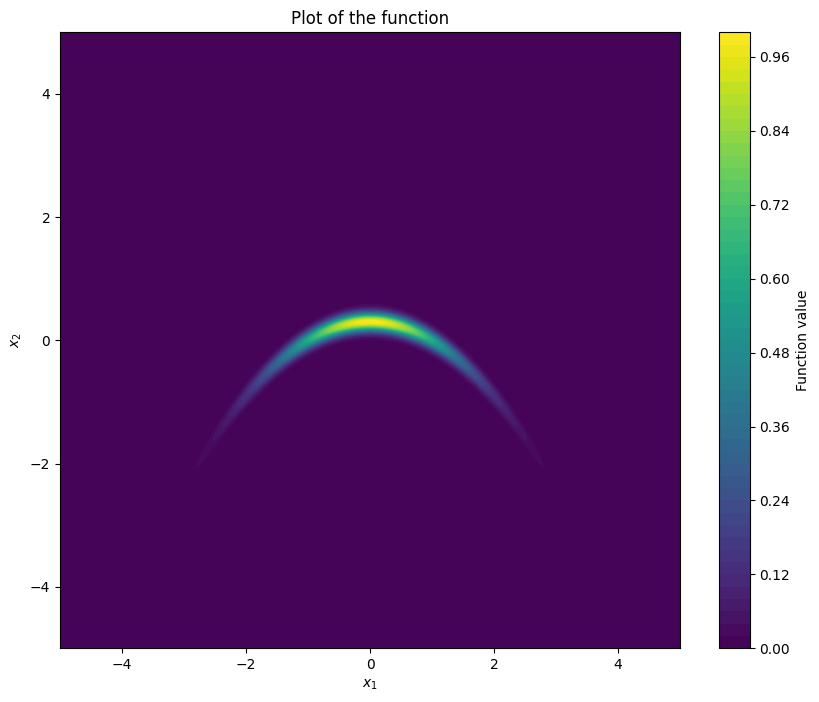

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def formula(x1, x2):
    term1 = -x1**2 / 2
    term2 = -(1/2) * (10 * x2 + 3 * x1**2 - 3)**2
    result = np.exp(term1 + term2)
    return result

# Create a grid of values
x1_values = np.linspace(-5, 5, 400)
x2_values = np.linspace(-5, 5, 400)
X1, X2 = np.meshgrid(x1_values, x2_values)
Z = formula(X1, X2)

# Plot the function
plt.figure(figsize=(10, 8))
plt.contourf(X1, X2, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function value')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Plot of the function')
plt.show()

In [ ]:
np.random.seed(111)
def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    term1 = -x1**2 / 2
    term2 = -(1/2) * (10 * x2 + 3 * x1**2 - 3)**2
    return np.exp(term1 + term2)

update_rule = 'Euler'
params_dict = set_params(update_rule,{'q_pos': 1.0,
                                      'q_pos_auto_annealing': False,
                                      'normalize_overall_forces': True,
                                      'normalise_attr_forces': False,
                                      'particle_filtering': False,
                                      'noise_std':0})
init_dict = {'init_type':'gaussian', 'initial_gaussian_center':np.array([0, 0]), 'initial_gaussian_std':1, 'low_xy': -3, 'high_xy': 3, 'margin':0}


start_time = time.time()
# Initialize positions with a seed for reproducibility
x_neg, x_pos = initialize_positions(target_p=target_p,
                                    M_neg=params_dict['M_neg'],
                                    M_pos=params_dict['M_pos'],
                                    d=params_dict['d'],
                                    init_dict=init_dict,
                                    SEED=params_dict['SEED'])
# Egenerate 5000 ground truth samples
samples = metropolis_hastings(target_p, 5000)
# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    target_p=target_p,
    ground_truth_samples=samples)
end_time = time.time(); total_time = end_time - start_time; print(f'total run time: {total_time} seconds')

# plot trajectories for selected particles
selected_indices = [0,100,200,299]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                target_p=target_p,
                x_pos=x_pos,
                low_xy=init_dict['low_xy'],
                high_xy=init_dict['high_xy'],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# save results
results_dict = {'update_rule':update_rule,
                'params_dict':params_dict,
                'init_dict':init_dict,
                'init_x_neg':x_neg,
                'init_x_pos':x_pos,
                'x_neg_final':x_neg_final,
                'all_trajectories':all_trajectories,
                'particle_counts_vec': particle_counts_vec,
                'selected_indices':selected_indices,
                'total_time':total_time,
                'step_time_vec':step_time_vec,
                'MMD2_vec':MMD2_vec,
                'NLL_vec':NLL_vec}
# saving the dictionary
with open(wd+'plots/results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

# Double banana.

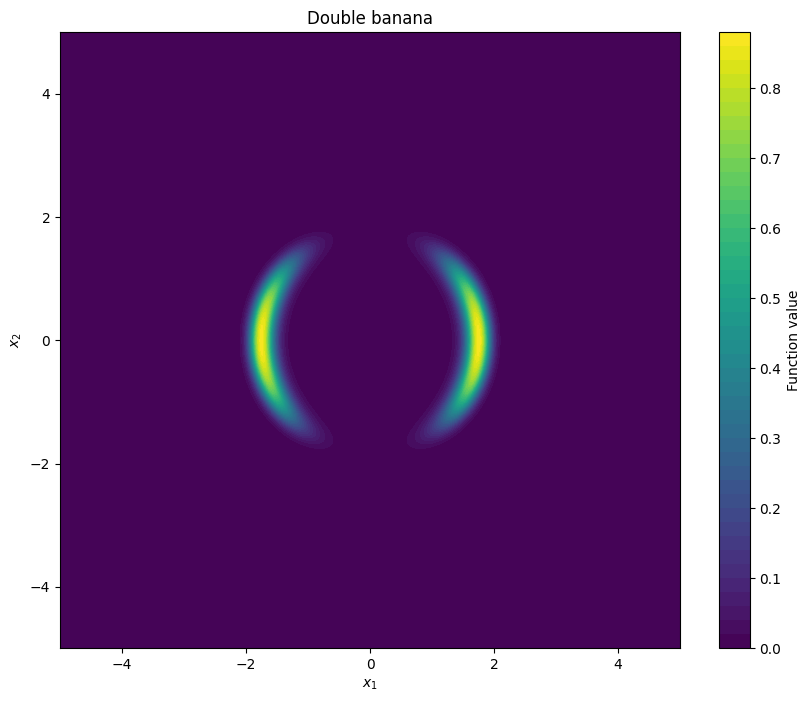

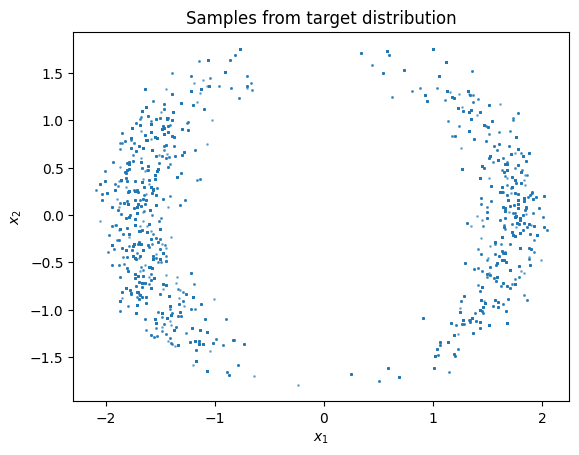

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def formula(x1, x2):
    return np.exp(-2 * ((x1 ** 2 + x2 ** 2) - 3) ** 2 + np.log(np.exp(-2 * (x1 - 2) ** 2) + np.exp(-2 * (x1 + 2) ** 2)))

# Create a grid of values
x1_values = np.linspace(-5, 5, 400)
x2_values = np.linspace(-5, 5, 400)
X1, X2 = np.meshgrid(x1_values, x2_values)
Z = formula(X1, X2)

# Plot the function
plt.figure(figsize=(10, 8))
plt.contourf(X1, X2, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function value')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Double banana')
plt.show()

# draw 5000 samples using MH
np.random.seed(111)
def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    return np.exp(-2 * ((x1 ** 2 + x2 ** 2) - 3) ** 2 + np.log(np.exp(-2 * (x1 - 2) ** 2) + np.exp(-2 * (x1 + 2) ** 2)))

samples = metropolis_hastings(target_p, 5000)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=1)
plt.title('Samples from target distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [ ]:
np.random.seed(111)

def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    return np.exp(-2 * ((x1 ** 2 + x2 ** 2) - 3) ** 2 + np.log(np.exp(-2 * (x1 - 2) ** 2) + np.exp(-2 * (x1 + 2) ** 2)))

update_rule = 'Euler'
params_dict = set_params(update_rule,{'q_pos': 1.0,
                                      'q_pos_auto_annealing': False,
                                      'normalize_overall_forces': True,
                                      'normalise_attr_forces': False,
                                      'particle_filtering': False,
                                      'noise_std':0})
init_dict = {'init_type':'uniform', 'low_uniform':-3, 'high_uniform':3, 'low_xy': -3, 'high_xy': 3, 'margin':0}

start_time = time.time()
# Initialize positions with a seed for reproducibility
x_neg, x_pos = initialize_positions(target_p=target_p,
                                    M_neg=params_dict['M_neg'],
                                    M_pos=params_dict['M_pos'],
                                    d=params_dict['d'],
                                    init_dict=init_dict,
                                    SEED=params_dict['SEED'])
# Egenerate 5000 ground truth samples
samples = metropolis_hastings(target_p, 5000)
# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    target_p=target_p,
    ground_truth_samples=samples)
end_time = time.time(); total_time = end_time - start_time; print(f'total run time: {total_time} seconds')

# plot trajectories for selected particles
selected_indices = [18, 16,20,80]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                target_p=target_p,
                x_pos=x_pos,
                low_xy=init_dict['low_xy'],
                high_xy=init_dict['high_xy'],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# save results
results_dict = {'update_rule':update_rule,
                'params_dict':params_dict,
                'init_dict':init_dict,
                'init_x_neg':x_neg,
                'init_x_pos':x_pos,
                'x_neg_final':x_neg_final,
                'all_trajectories':all_trajectories,
                'particle_counts_vec': particle_counts_vec,
                'selected_indices':selected_indices,
                'total_time':total_time,
                'step_time_vec':step_time_vec,
                'MMD2_vec':MMD2_vec,
                'NLL_vec':NLL_vec}
# saving the dictionary
with open(wd+'plots/results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

# Wave.

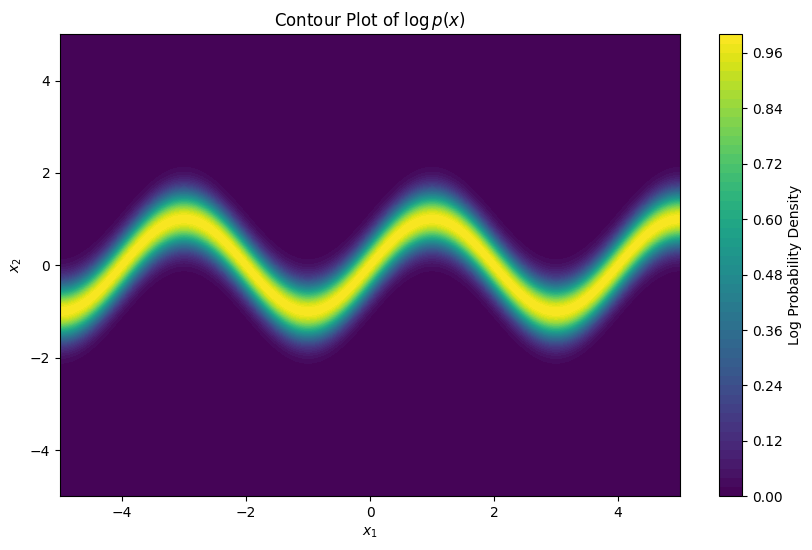

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def target_p(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    target_p = -0.5 * (x2 - np.sin(np.pi * x1 / 2)) ** 2 / 0.16
    return np.exp(target_p)

# Create a grid of values
x1_values = np.linspace(-5, 5, 400)
x2_values = np.linspace(-5, 5, 400)
X1, X2 = np.meshgrid(x1_values, x2_values)
X = np.column_stack([X1.ravel(), X2.ravel()])

# Compute target_p
target_p_values = target_p(X)

# Reshape target_p for contour plot
target_p_values = target_p_values.reshape(X1.shape)

# Plot the function target_p
plt.figure(figsize=(10, 6))
plt.contourf(X1, X2, target_p_values, levels=50, cmap='viridis')
plt.colorbar(label='Log Probability Density')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Contour Plot of $\log p(x)$')
plt.show()

In [ ]:
np.random.seed(111)
def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    return np.exp(-0.5 * (x2 - np.sin(np.pi * x1 / 2)) ** 2 / 0.16)

update_rule = 'Euler'
params_dict = set_params(update_rule,{'q_pos': 1.0,
                                      'q_pos_auto_annealing': False,
                                      'normalize_overall_forces': True,
                                      'normalise_attr_forces': False,
                                      'particle_filtering': False,
                                      'noise_std':0})
init_dict = {'init_type':'uniform', 'low_uniform':-3, 'high_uniform':3, 'low_xy': -3, 'high_xy': 3, 'margin':0}

start_time = time.time()
# Initialize positions with a seed for reproducibility
x_neg, x_pos = initialize_positions(target_p=target_p,
                                    M_neg=params_dict['M_neg'],
                                    M_pos=params_dict['M_pos'],
                                    d=params_dict['d'],
                                    init_dict=init_dict,
                                    SEED=params_dict['SEED'])
# Egenerate 5000 ground truth samples
samples = metropolis_hastings(target_p, 5000)
# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    target_p=target_p,
    ground_truth_samples=samples)
end_time = time.time(); total_time = end_time - start_time; print(f'total run time: {total_time} seconds')

# plot trajectories for selected particles
selected_indices = [0,100,200,299]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                target_p=target_p,
                x_pos=x_pos,
                low_xy=init_dict['low_xy'],
                high_xy=init_dict['high_xy'],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# save results
results_dict = {'update_rule':update_rule,
                'params_dict':params_dict,
                'init_dict':init_dict,
                'init_x_neg':x_neg,
                'init_x_pos':x_pos,
                'x_neg_final':x_neg_final,
                'all_trajectories':all_trajectories,
                'particle_counts_vec': particle_counts_vec,
                'selected_indices':selected_indices,
                'total_time':total_time,
                'step_time_vec':step_time_vec,
                'MMD2_vec':MMD2_vec,
                'NLL_vec':NLL_vec}
# saving the dictionary
with open(wd+'plots/results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

# Neal's funnel.

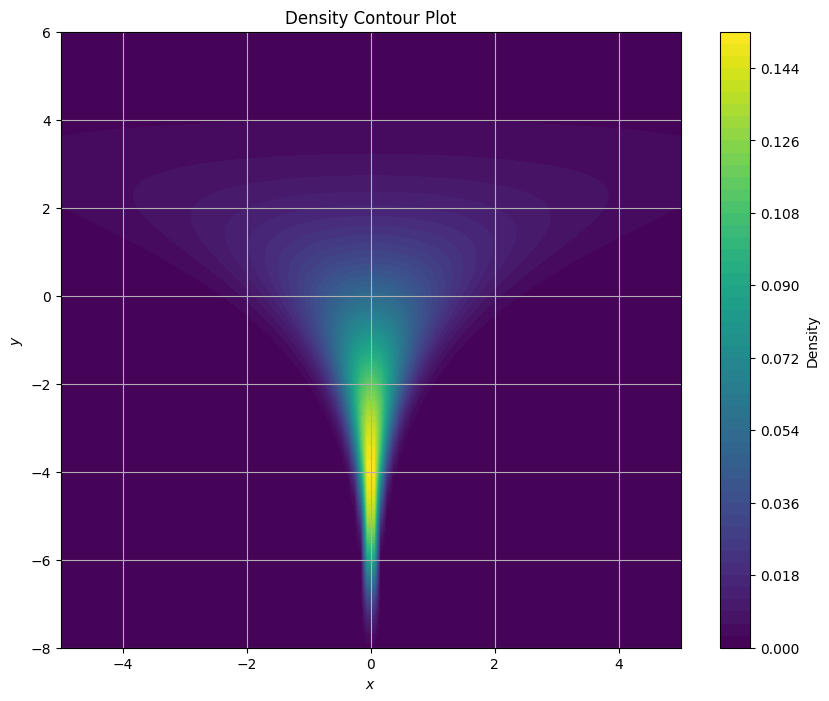

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
sigma = 3.0  # Standard deviation for v
n_samples = 10000  # Number of samples

# Define the density function
def density(x, y, sigma):
    # p(y | sigma) = N(y | 0, sigma^2)
    p_y = norm.pdf(y, 0, sigma)
    # p(x | y) = N(x | 0, exp(y))
    p_x_given_y = norm.pdf(x, 0, np.exp(y / 2))
    return p_x_given_y * p_y

# Create a grid over [-5, 5] x [-5, 5]
x = np.linspace(-5, 5, 100)
y = np.linspace(-8, 6, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the density over the grid
Z = density(X, Y, sigma)

# Plotting the density
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, label='Density')
plt.title("Density Contour Plot")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)
plt.show()

## HMC.

In [ ]:
# !pip install pymc arviz
!pip install --upgrade numpy scipy theano pymc arviz

import pymc as pm
import arviz as az

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.colors import LinearSegmentedColormap
import pymc as pm
import arviz as az

np.random.seed(111)

# Define the target density function
def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    p_x2 = norm.pdf(x2, 0, 3.0)  # Standard deviation for v
    p_x1_given_x2 = norm.pdf(x1, 0, np.exp(x2 / 2))
    return p_x1_given_x2 * p_x2

# Parameters for sampling and plotting
low_xy, high_xy = -7, 3
margin = 0

# Define the PyMC3 model for HMC
with pm.Model() as model:
    x2 = pm.Normal('x2', mu=0, sigma=3.0)
    x1 = pm.Normal('x1', mu=0, sigma=pm.math.exp(x2 / 2))

    # Sample using HMC
    trace = pm.sample(4000, tune=1000, chains=1, cores=1, return_inferencedata=True, discard_tuned_samples=True, random_seed=111)

# Extract samples
HMC_samples = trace.posterior.stack(draws=("chain", "draw")).to_dataframe()
HMC_samples = HMC_samples.iloc[::10,:]



# Plotting the samples and the density contours with marginal distributions
fig, ax_main = plt.subplots(figsize=(8, 6))

X, Y, Z, cm = plot_density(target_p, low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin)
img = ax_main.imshow(Z, extent=(low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin), origin='lower', cmap=cm, alpha=0.5)

# Plot the samples
scatter_samples = ax_main.scatter(HMC_samples['x1'], HMC_samples['x2'], c='blue', s=3, label='HMC samples')

# Overlay contour lines
contour = ax_main.contour(X, Y, Z, levels=10, colors='white', linewidths=0.5)

# Set plot limits and labels
ax_main.set_xlim(low_xy - margin, high_xy + margin)
ax_main.set_ylim(low_xy - margin, high_xy + margin)
ax_main.set_xlabel(r'$x_1$')
ax_main.set_ylabel(r'$x_2$')
ax_main.legend(loc='lower left')

# Create inset axes for the histograms
ax_histx = inset_axes(ax_main, width="100%", height="60%", loc='upper center',
                      bbox_to_anchor=(0, 0.92, 1, 0.2), bbox_transform=ax_main.transAxes, borderpad=0)
ax_histy = inset_axes(ax_main, width="60%", height="100%", loc='center right',
                      bbox_to_anchor=(0.92, 0, 0.2, 1), bbox_transform=ax_main.transAxes, borderpad=0)

# Marginal histograms
ax_histx.hist(HMC_samples['x1'], bins=180, density=True, color='blue', alpha=0.6)
ax_histy.hist(HMC_samples['x2'], bins=60, density=True, color='blue', alpha=0.6, orientation='horizontal')

# Hide x labels and tick labels for the hist plots
plt.setp(ax_histx.get_xticklabels(), visible=True)
plt.setp(ax_histy.get_yticklabels(), visible=True)

# Disable y-ticks for the histograms
ax_histx.yaxis.set_ticks([])
ax_histy.xaxis.set_ticks([])

# Set the same x-ticks for the upper histogram
ax_histx.set_xlim(ax_main.get_xlim())
# Set the same y-ticks for the right histogram
ax_histy.set_ylim(ax_main.get_ylim())

plt.savefig(wd+f'final results/Neal funnel/HMC.png')
plt.show()

HMC_samples_pairs = HMC_samples[['x1', 'x2']].to_numpy()
np.save(wd+'final results/Neal funnel/HMC_samples.npy', HMC_samples_pairs)

## MH.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.colors import LinearSegmentedColormap
import time

np.random.seed(111)

# Define the target density function
def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    p_x2 = norm.pdf(x2, 0, 3.0)  # Standard deviation for v
    p_x1_given_x2 = norm.pdf(x1, 0, np.exp(x2 / 2))
    return p_x1_given_x2 * p_x2

# Metropolis-Hastings sampling for generating ground truth samples
def metropolis_hastings(target_p, num_samples, proposal_std=1.0):
    # Initial guess
    x_current = np.random.randn(2)
    samples = []
    step_time_vec = []

    for t in range(num_samples):
        start_time = time.time()

        # Propose a new point
        x_proposal = x_current + np.random.randn(2) * proposal_std

        # Calculate acceptance ratio
        acceptance_ratio = target_p(x_proposal) / target_p(x_current)

        # Accept or reject the new point
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposal

        samples.append(x_current)

        end_time = time.time()
        step_time = end_time - start_time
        step_time_vec.append(step_time)

    return np.array(samples), step_time_vec

# Parameters for sampling and plotting
num_samples = 4000
proposal_std = 1.0
low_xy, high_xy = -7, 3
margin = 0

# Run Metropolis-Hastings sampling
MH_samples, step_time_vec = metropolis_hastings(target_p=target_p, num_samples=num_samples, proposal_std=proposal_std)

# Thin the samples for plotting
MH_samples_thinned = MH_samples[::10]

# Plotting the samples and the density contours with marginal distributions
fig, ax_main = plt.subplots(figsize=(8, 6))

X, Y, Z, cm = plot_density(target_p, low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin)
img = ax_main.imshow(Z, extent=(low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin), origin='lower', cmap=cm, alpha=0.5)

# Plot the samples
scatter_samples = ax_main.scatter(MH_samples_thinned[:, 0], MH_samples_thinned[:, 1], c='blue', s=3, label='MH samples')

# Overlay contour lines
contour = ax_main.contour(X, Y, Z, levels=10, colors='white', linewidths=0.5)

# Set plot limits and labels
ax_main.set_xlim(low_xy - margin, high_xy + margin)
ax_main.set_ylim(low_xy - margin, high_xy + margin)
ax_main.set_xlabel(r'$x_1$')
ax_main.set_ylabel(r'$x_2$')
ax_main.legend(loc='lower left')

# Create inset axes for the histograms
ax_histx = inset_axes(ax_main, width="100%", height="60%", loc='upper center',
                      bbox_to_anchor=(0, 0.92, 1, 0.2), bbox_transform=ax_main.transAxes, borderpad=0)
ax_histy = inset_axes(ax_main, width="60%", height="100%", loc='center right',
                      bbox_to_anchor=(0.92, 0, 0.2, 1), bbox_transform=ax_main.transAxes, borderpad=0)

# Marginal histograms
ax_histx.hist(MH_samples_thinned[:, 0], bins=30, density=True, color='blue', alpha=0.6)
ax_histy.hist(MH_samples_thinned[:, 1], bins=30, density=True, color='blue', alpha=0.6, orientation='horizontal')

# Hide x labels and tick labels for the hist plots
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

# Disable y-ticks for the histograms
ax_histx.yaxis.set_ticks([])
ax_histy.xaxis.set_ticks([])

# Set the same x-ticks for the upper histogram
ax_histx.set_xlim(ax_main.get_xlim())
# Set the same y-ticks for the right histogram
ax_histy.set_ylim(ax_main.get_ylim())

plt.savefig(wd+f'final results/Neal funnel/MH.png')
plt.show()

# Save final samples
np.save(wd + 'final results/Neal funnel/MH_samples.npy', MH_samples_thinned)

## LMC.

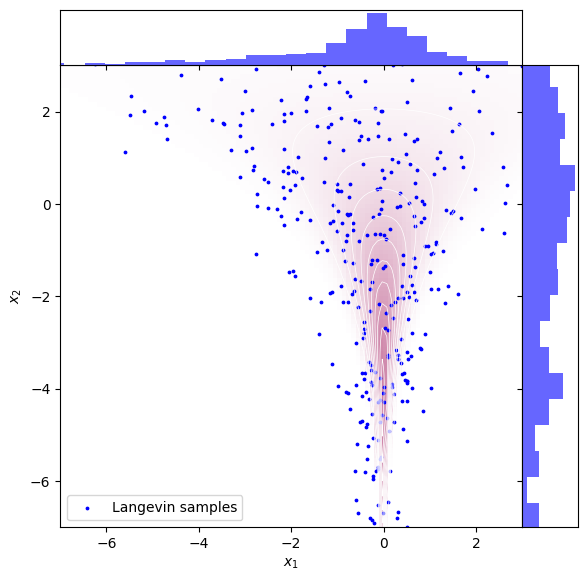

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(111)

# Define the target density function
def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    p_x2 = norm.pdf(x2, 0, 3.0)  # Standard deviation for v
    p_x1_given_x2 = norm.pdf(x1, 0, np.exp(x2 / 2))
    return p_x1_given_x2 * p_x2

# Gradient of the log target density
def grad_log_target_p(x):
    x1, x2 = np.atleast_2d(x).T
    # Gradients with respect to x2
    grad_x2 = -x2 / 9 - 0.25 + (x1**2 * np.exp(-x2 / 2)) / 4
    # Gradients with respect to x1
    grad_x1 = -x1 / np.exp(x2 / 2)
    return np.hstack((grad_x1[:, np.newaxis], grad_x2[:, np.newaxis]))

# Langevin sampling function
def sample_langevin(n, d, x0, grad_log_target_p, max_iter=10000, a=0.01, b=1, c=0.55, ground_truth_samples=None):
    # x = np.zeros([n, d])
    x = x0
    step_time_vec = []
    NLL_vec = []
    MMD2_vec = []
    for t in range(max_iter):
        start_time = time.time()

        samples_array = np.array(x)
        mmd2_value = compute_mmd2(samples_array, ground_truth_samples)
        MMD2_vec.append(mmd2_value)

        nll_value = -np.mean(np.log(target_p(samples_array) + 1e-10))
        NLL_vec.append(nll_value)

        epsilon = a * np.exp(np.log(b + t) * (-c))
        x += epsilon * grad_log_target_p(x)
        x += 2 * np.sqrt(epsilon) * np.random.randn(n, d)

        end_time = time.time()
        step_time = end_time - start_time
        step_time_vec.append(step_time)

    np.savez(wd + f'final results/Neal funnel/Langevin_all_iteration_steptime_mmd2_nll.npz', step_time_vec=step_time_vec, MMD2_vec=MMD2_vec, NLL_vec=NLL_vec)
    return x

ground_truth_samples = np.load(wd+'final results/Neal funnel/HMC_samples.npy')
# Parameters for sampling and plotting
x0 = np.load(wd+'final results/Neal funnel/x_neg.npy')
n = 400
d = 2
max_iter = 10000
low_xy, high_xy = -7, 3
margin = 0

# Generate samples using Langevin sampling
Langevin_samples = sample_langevin(n=n, d=d, x0=x0, grad_log_target_p=grad_log_target_p, max_iter=max_iter, ground_truth_samples=ground_truth_samples)


# Plotting the samples and the density contours with marginal distributions
fig, ax_main = plt.subplots(figsize=(8, 6))

X, Y, Z, cm = plot_density(target_p, low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin)
img = ax_main.imshow(Z, extent=(low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin), origin='lower', cmap=cm, alpha=0.5)

# Plot the samples
scatter_samples = ax_main.scatter(Langevin_samples[:, 0], Langevin_samples[:, 1], c='blue', s=3, label='Langevin samples')

# Overlay contour lines
contour = ax_main.contour(X, Y, Z, levels=10, colors='white', linewidths=0.5)

# Set plot limits and labels
ax_main.set_xlim(low_xy - margin, high_xy + margin)
ax_main.set_ylim(low_xy - margin, high_xy + margin)
ax_main.set_xlabel(r'$x_1$')
ax_main.set_ylabel(r'$x_2$')
ax_main.legend(loc='lower left')

# Create inset axes for the histograms
ax_histx = inset_axes(ax_main, width="100%", height="60%", loc='upper center',
                      bbox_to_anchor=(0, 0.92, 1, 0.2), bbox_transform=ax_main.transAxes, borderpad=0)
ax_histy = inset_axes(ax_main, width="60%", height="100%", loc='center right',
                      bbox_to_anchor=(0.92, 0, 0.2, 1), bbox_transform=ax_main.transAxes, borderpad=0)

# Marginal histograms
ax_histx.hist(Langevin_samples[:, 0], bins=30, density=True, color='blue', alpha=0.6)
ax_histy.hist(Langevin_samples[:, 1], bins=30, density=True, color='blue', alpha=0.6, orientation='horizontal')

# Hide x labels and tick labels for the hist plots
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

# Disable y-ticks for the histograms
ax_histx.yaxis.set_ticks([])
ax_histy.xaxis.set_ticks([])

# Set the same x-ticks for the upper histogram
ax_histx.set_xlim(ax_main.get_xlim())
# Set the same y-ticks for the right histogram
ax_histy.set_ylim(ax_main.get_ylim())

# Add a colorbar for the main plot
# cbar = plt.colorbar(img, ax=ax_histy, location='left')
# cbar.set_label('Density')

plt.savefig(wd+f'final results/Neal funnel/Langevin.png')
plt.show()

np.save(wd+'final results/Neal funnel/Langevin_samples.npy', Langevin_samples)

Step Time Vector: [0.00702286 0.00486207 0.00421572 ... 0.00391746 0.00439882 0.00402856]
MMD^2 Vector: [118020.0156036  117974.20382963 117937.041961   ... 108585.69452436
 108585.68720038 108585.67987654]
NLL Vector: [14.67694479 14.64001413 14.60957525 ...  5.85588141  5.85586601
  5.85585061]


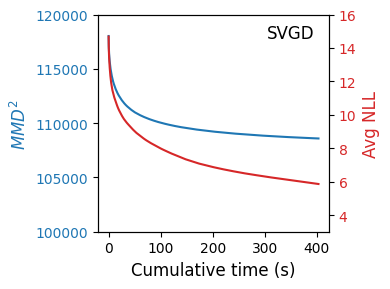

In [ ]:
# Load the saved .npz file
loaded_Langevin_data = np.load(wd + 'final results/Neal funnel/SVGD_all_iteration_steptime_mmd2_nll.npz')

# Accessing the arrays
step_time_vec = loaded_Langevin_data['step_time_vec']
MMD2_vec = loaded_Langevin_data['MMD2_vec']
NLL_vec = loaded_Langevin_data['NLL_vec']

print("Step Time Vector:", step_time_vec)
print("MMD^2 Vector:", MMD2_vec)
print("NLL Vector:", NLL_vec)

# Compute the cumulative sum of step times
cumulative_step_time = np.cumsum(step_time_vec)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(4,3))

# Plot MMD^2 on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Cumulative time (s)', fontsize=12)
ax1.set_ylabel(r'$MMD^2$', color=color, fontsize=12)
ax1.plot(cumulative_step_time, MMD2_vec, label=r'$MMD^2$', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([100000, 120000])
# ax1.legend(loc='upper left')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg NLL', color=color, fontsize=12)
ax2.plot(cumulative_step_time, NLL_vec, label='NLL', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([3, 16])
# ax2.legend(loc='upper right')

# Add text to the top right corner
fig.text(0.80, 0.90, 'SVGD', ha='right', va='top', fontsize=12, color='black')

# plt.title('MMD^2 and NLL vs Cumulative Time')
fig.tight_layout()  # to prevent overlap of y-axis labels
plt.savefig(wd+f'final results/Neal funnel/Langevin_MMD_LLN.png')
plt.show()

## SVGD.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform

np.random.seed(111)

# Define the target density function
def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    p_x2 = norm.pdf(x2, 0, 3.0)  # Standard deviation for v
    p_x1_given_x2 = norm.pdf(x1, 0, np.exp(x2 / 2))
    return p_x1_given_x2 * p_x2

# Log-probability function
def log_target_p(x):
    return np.log(target_p(x) + 1e-10)  # Add epsilon to avoid log(0)

# Gradient of the log target density
def grad_log_target_p(x):
    x1, x2 = np.atleast_2d(x).T
    # Gradients with respect to x2
    grad_x2 = -x2 / 9 - 0.25 + (x1**2 * np.exp(-x2 / 2)) / 4
    # Gradients with respect to x1
    grad_x1 = -x1 / np.exp(x2 / 2)
    return np.hstack((grad_x1[:, np.newaxis], grad_x2[:, np.newaxis]))

class SVGD:
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h=-1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist) ** 2
        if h < 0:  # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0] + 1))

        # compute the rbf kernel
        Kxy = np.exp(-pairwise_dists / h ** 2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:, i] + np.multiply(theta[:, i], sumkxy)
        dxkxy = dxkxy / (h ** 2)

        return Kxy, dxkxy

    def svgd_updates(self, x0, lnprob, inner_iteration, outer_iteration, stepsize, debug=False, ground_truth_samples=None):
        n_iter = inner_iteration * outer_iteration

        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta = np.copy(x0)
        adag = np.zeros(theta.shape)

        step_time_vec = []
        NLL_vec = []
        MMD2_vec = []
        for iter in range(n_iter):
            if debug and (iter + 1) % 1000 == 0:
                print(f'iter {iter + 1}')

            start_time = time.time()

            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]
            adag += grad_theta ** 2  # update sum of gradient's square
            theta = theta + stepsize * grad_theta / np.sqrt(adag + 1e-12)

            end_time = time.time()
            step_time = end_time - start_time
            step_time_vec.append(step_time)

            samples_array = np.array(theta)
            mmd2_value = compute_mmd2(samples_array, ground_truth_samples)
            MMD2_vec.append(mmd2_value)

            nll_value = -np.mean(np.log(target_p(samples_array) + 1e-10))
            NLL_vec.append(nll_value)
        np.savez(wd + f'final results/Neal funnel/SVGD_all_iteration_steptime_mmd2_nll.npz', step_time_vec=step_time_vec, MMD2_vec=MMD2_vec, NLL_vec=NLL_vec)
        return theta

# Define the log-probability gradient function
def lnprob_grad(x):
    return grad_log_target_p(x)

ground_truth_samples = np.load(wd+'final results/Neal funnel/HMC_samples.npy')
# Initial particles for SVGD
n_particles = 400
d = 2
# x0 = np.random.randn(n_particles, d)
x0 = np.load(wd+'final results/Neal funnel/x_neg.npy')

# Parameters for SVGD
inner_iteration = 10000
outer_iteration = 10
stepsize = 0.01

# Instantiate SVGD and perform updates
svgd = SVGD()
particles = svgd.svgd_updates(x0=x0,
                              lnprob=lnprob_grad,
                              inner_iteration=inner_iteration,
                              outer_iteration=outer_iteration,
                              stepsize=stepsize,
                              ground_truth_samples=ground_truth_samples)

# Plotting the samples and the density contours
def plot_density(target_p, x_min, x_max, y_min, y_max, num_points=100):
    x = np.linspace(x_min, x_max, num_points)
    y = np.linspace(y_min, y_max, num_points)
    X, Y = np.meshgrid(x, y)
    Z = np.array([target_p(np.array([x, y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)

    # Create a custom white to dark pink colormap
    colors = [(1, 1, 1), (0.6, 0, 0.3)]  # white to dark pink
    n_bins = 100  # Discretize the interpolation into 100 steps
    cmap_name = 'white_dark_pink'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    return X, Y, Z, cm

# parameters for plotting
low_xy, high_xy = -7, 3
margin = 1

# Plotting the samples and the density contours with marginal distributions
fig, ax_main = plt.subplots(figsize=(8, 6))

X, Y, Z, cm = plot_density(target_p, low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin)
img = ax_main.imshow(Z, extent=(low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin), origin='lower', cmap=cm, alpha=0.5)

# Plot the samples
scatter_samples = ax_main.scatter(particles[:, 0], particles[:, 1], c='blue', s=3, label='SVGD samples')

# Overlay contour lines
contour = ax_main.contour(X, Y, Z, levels=10, colors='white', linewidths=0.5)

# Set plot limits and labels
ax_main.set_xlim(low_xy - margin, high_xy + margin)
ax_main.set_ylim(low_xy - margin, high_xy + margin)
ax_main.set_xlabel(r'$x_1$')
ax_main.set_ylabel(r'$x_2$')
ax_main.legend(loc='lower left')

# Create inset axes for the histograms
ax_histx = inset_axes(ax_main, width="100%", height="60%", loc='upper center',
                      bbox_to_anchor=(0, 0.92, 1, 0.2), bbox_transform=ax_main.transAxes, borderpad=0)
ax_histy = inset_axes(ax_main, width="60%", height="100%", loc='center right',
                      bbox_to_anchor=(0.92, 0, 0.2, 1), bbox_transform=ax_main.transAxes, borderpad=0)

# Marginal histograms
ax_histx.hist(particles[:, 0], bins=30, density=True, color='blue', alpha=0.6)
ax_histy.hist(particles[:, 1], bins=30, density=True, color='blue', alpha=0.6, orientation='horizontal')

# Hide x labels and tick labels for the hist plots
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

# Disable y-ticks for the histograms
ax_histx.yaxis.set_ticks([])
ax_histy.xaxis.set_ticks([])

# Set the same x-ticks for the upper histogram
ax_histx.set_xlim(ax_main.get_xlim())
# Set the same y-ticks for the right histogram
ax_histy.set_ylim(ax_main.get_ylim())

plt.savefig(wd+f'final results/Neal funnel/SVGD.png')
plt.show()

np.save(wd+'final results/Neal funnel/SVGD_particles.npy', particles)

In [ ]:
# Load the saved .npz file
loaded_SVGD_data = np.load(wd + 'final results/Neal funnel/SVGD_all_iteration_steptime_mmd2_nll.npz')

# Accessing the arrays
step_time_vec = loaded_SVGD_data['step_time_vec']
MMD2_vec = loaded_SVGD_data['MMD2_vec']
NLL_vec = loaded_SVGD_data['NLL_vec']

print("Step Time Vector:", step_time_vec)
print("MMD^2 Vector:", MMD2_vec)
print("NLL Vector:", NLL_vec)

# Compute the cumulative sum of step times
cumulative_step_time = np.cumsum(step_time_vec)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(4,3))

# Plot MMD^2 on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Cumulative time (s)', fontsize=12)
ax1.set_ylabel(r'$MMD^2$', color=color, fontsize=12)
ax1.plot(cumulative_step_time, MMD2_vec, label=r'$MMD^2$', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([100000, 120000])
# ax1.legend(loc='upper left')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg NLL', color=color, fontsize=12)
ax2.plot(cumulative_step_time, NLL_vec, label='NLL', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([3, 16])

# Add text to the top right corner
fig.text(0.80, 0.93, 'SVGD', ha='right', va='top', fontsize=12, color='black')

# plt.title('MMD^2 and NLL vs Cumulative Time')
fig.tight_layout()  # to prevent overlap of y-axis labels
plt.show()

## EVI.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(111)

class neal_funnel(object):
    def logp(self, x):
        x1 = x[:, 0]
        x2 = x[:, 1]
        p_x2 = norm.pdf(x2, 0, 3.0)
        p_x1_given_x2 = norm.pdf(x1, 0, np.exp(x2 / 2))
        log_p = np.log(p_x1_given_x2 * p_x2)
        return log_p

    def grad_log_p(self, x):
        x1 = x[:, 0]
        x2 = x[:, 1]
        grad_x2 = -x2 / 9 - 0.25 + (x1**2 * np.exp(-x2 / 2)) / 4
        # Gradients with respect to x1
        grad_x1 = -x1 / np.exp(x2 / 2)
        return np.array([grad_x1, grad_x2]).T

def trainer(x0, model, method, n_particles, outer_iter, ground_truth_samples):

    np.random.seed(111)
    d = 2
    tau = 1e-1
    # x = np.random.randn(n_particles, d)  # set initial particles as standard normal
    x = x0
    N = n_particles * d

    # comparision metric
    cross_entropy = []
    cross_entropy.append(-np.mean(model.logp(x)))

    if method == 'evi':
        # Evi
        x_initial = x
        dynamics = np.zeros([outer_iter, n_particles, d])
        h = 0.1

        step_time_vec = []
        NLL_vec = []
        MMD2_vec = []
        for i in range(outer_iter):

            for j in range(5000):

                start_time = time.time()

                Sqy = model.grad_log_p(x)
                diff = x[:, None, :] - x[None, :, :]
                kxy = np.exp(-np.sum(diff ** 2, axis=-1) / (2 * h ** 2)) / np.power(np.pi * 2.0 * h * h, d / 2)
                sumkxy = np.sum(kxy, axis=1, keepdims=True)
                gradK = -diff * kxy[:, :, None] / h ** 2  # N * N * 2
                dxkxy = np.sum(gradK, axis=0)  # N * 2
                obj = np.sum(np.transpose(gradK, axes=[1, 0, 2]) / sumkxy, axis=1)  # N * 2
                grad = (x - x_initial) / tau + (- dxkxy / sumkxy - obj - Sqy)
                grad_now = np.reshape(grad, (1, N))

                if np.sqrt(np.inner(grad_now, grad_now)) < 1e-9:
                    print(j)
                    break

                step_l = 1e-7
                # BB Step - length
                if j > 0:
                    y_k = grad_now - grad_old
                    s_k = np.reshape(x, (1, N)) - np.reshape(x_old, (1, N))
                    step_l = np.inner(s_k, s_k) / np.inner(s_k, y_k)

                grad_old = grad_now
                x_old = x
                x = x - step_l * grad

                end_time = time.time()
                step_time = end_time - start_time
                step_time_vec.append(step_time)

                samples_array = np.array(x)
                mmd2_value = compute_mmd2(samples_array, ground_truth_samples)
                MMD2_vec.append(mmd2_value)

                nll_value = -np.mean(np.log(target_p(samples_array) + 1e-10))
                NLL_vec.append(nll_value)

            x_initial = x
            cross_entropy.append(-np.mean(model.logp(x)))
            dynamics[i, :, :] = x

        np.savez(wd + f'final results/Neal funnel/EVI_all_iteration_steptime_mmd2_nll.npz', step_time_vec=step_time_vec, MMD2_vec=MMD2_vec, NLL_vec=NLL_vec)

    return dynamics, cross_entropy  # cross_entropy

model = neal_funnel()
method = 'evi'
n_particles = 400
dim = 2
repeat = 1
outer_iter = 500

x0 = np.load(wd+'final results/Neal funnel/x_neg.npy')

cross_entropy_results = np.zeros(shape=(repeat, outer_iter + 1))
evolves = np.zeros(shape=(repeat, outer_iter, n_particles, dim))

ground_truth_samples = np.load(wd+'final results/Neal funnel/HMC_samples.npy')
for rep in range(repeat):
    evolves[rep, :, :, :], cross_entropy_results[rep, :] = trainer(x0=x0, model=model, method=method, n_particles=n_particles, outer_iter=outer_iter, ground_truth_samples=ground_truth_samples)

final_particles = evolves[0, -1, :, :]

# Compute theoretical density for plotting
ngrid = 100
x = np.linspace(-7, 3, ngrid)
y = np.linspace(-7, 3, ngrid)
X, Y = np.meshgrid(x, y)
Z = np.exp(model.logp(np.vstack((np.ndarray.flatten(X), np.ndarray.flatten(Y))).T)).reshape(ngrid, ngrid)

# Plotting the samples and the density contours with marginal distributions
fig, ax_main = plt.subplots(figsize=(8, 6))

X, Y, Z, cm = plot_density(target_p, low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin)
img = ax_main.imshow(Z, extent=(low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin), origin='lower', cmap=cm, alpha=0.5)

# Plot the samples
scatter_samples = ax_main.scatter(final_particles[:, 0], final_particles[:, 1], c='blue', s=3, label='EVI samples')

# Overlay contour lines
contour = ax_main.contour(X, Y, Z, levels=10, colors='white', linewidths=0.5)

# Set plot limits and labels
ax_main.set_xlim(low_xy - margin, high_xy + margin)
ax_main.set_ylim(low_xy - margin, high_xy + margin)
ax_main.set_xlabel(r'$x_1$')
ax_main.set_ylabel(r'$x_2$')
ax_main.legend(loc='lower left')

# Create inset axes for the histograms
ax_histx = inset_axes(ax_main, width="100%", height="60%", loc='upper center',
                      bbox_to_anchor=(0, 0.92, 1, 0.2), bbox_transform=ax_main.transAxes, borderpad=0)
ax_histy = inset_axes(ax_main, width="60%", height="100%", loc='center right',
                      bbox_to_anchor=(0.92, 0, 0.2, 1), bbox_transform=ax_main.transAxes, borderpad=0)

# Marginal histograms
ax_histx.hist(final_particles[:, 0], bins=30, density=True, color='blue', alpha=0.6)
ax_histy.hist(final_particles[:, 1], bins=30, density=True, color='blue', alpha=0.6, orientation='horizontal')

# Hide x labels and tick labels for the hist plots
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

# Disable y-ticks for the histograms
ax_histx.yaxis.set_ticks([])
ax_histy.xaxis.set_ticks([])

# Set the same x-ticks for the upper histogram
ax_histx.set_xlim(ax_main.get_xlim())
# Set the same y-ticks for the right histogram
ax_histy.set_ylim(ax_main.get_ylim())

plt.savefig(wd+f'final results/Neal funnel/EVI.png')
plt.show()

np.save(wd+'final results/Neal funnel/EVI_particles.npy', final_particles)

In [ ]:
# Load the saved .npz file
loaded_EVI_data = np.load(wd + 'final results/Neal funnel/EVI_all_iteration_steptime_mmd2_nll.npz')

# Accessing the arrays
step_time_vec = loaded_EVI_data['step_time_vec']
MMD2_vec = loaded_EVI_data['MMD2_vec']
NLL_vec = loaded_EVI_data['NLL_vec']

print("Step Time Vector:", step_time_vec)
print("MMD^2 Vector:", MMD2_vec)
print("NLL Vector:", NLL_vec)

# Compute the cumulative sum of step times
cumulative_step_time = np.cumsum(step_time_vec)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(4,3))

# Plot MMD^2 on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Cumulative time (s)', fontsize=12)
ax1.set_ylabel(r'$MMD^2$', color=color, fontsize=12)
ax1.plot(cumulative_step_time, MMD2_vec, label=r'$MMD^2$', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([100000, 120000])
# ax1.legend(loc='upper left')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg NLL', color=color, fontsize=12)
ax2.plot(cumulative_step_time, NLL_vec, label='NLL', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([3, 16])

# Add text to the top right corner
fig.text(0.80, 0.93, 'EVI', ha='right', va='top', fontsize=12, color='black')

# plt.title('MMD^2 and NLL vs Cumulative Time')
fig.tight_layout()  # to prevent overlap of y-axis labels
plt.show()

## EParVI.

In [ ]:
np.random.seed(111)
def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    p_x2 = norm.pdf(x2, 0, 3.0) # # standard deviation for v
    p_x1_given_x2 = norm.pdf(x1, 0, np.exp(x2 / 2))
    return p_x1_given_x2 * p_x2

def grad_log_target_p(x):
    x1, x2 = np.atleast_2d(x).T
    # Gradients with respect to x1
    grad_x2 = -x2 / 9 - 0.25 + (x1**2 * np.exp(-x2 / 2)) / 4
    # Gradients with respect to x2
    grad_x1 = -x1 / np.exp(x2 / 2)
    return np.hstack((grad_x1[:, np.newaxis], grad_x2[:, np.newaxis]))

update_rule = 'Euler'
params_dict = set_params(update_rule,{'M_pos':100**2,
                                      'q_pos': 1.0,
                                      'q_pos_auto_annealing': False,
                                      'normalize_overall_forces': True,
                                      'normalise_attr_forces': False,
                                      'particle_filtering': False,
                                      'noise_std':0})
# init_dict = {'init_type':'gaussian', 'initial_gaussian_center':np.array([0, 0]), 'initial_gaussian_std':1, 'low_xy': -7, 'high_xy': 3, 'margin':0}
init_dict = {'init_type':'uniform', 'low_uniform':-7, 'high_uniform':3, 'low_xy': -7, 'high_xy': 3, 'margin':0}

start_time = time.time()
# Initialize positions with a seed for reproducibility
x_neg, x_pos = initialize_positions(target_p=target_p,
                                    M_neg=params_dict['M_neg'],
                                    M_pos=params_dict['M_pos'],
                                    d=params_dict['d'],
                                    init_dict=init_dict,
                                    SEED=params_dict['SEED'])
np.save(wd+'plots/x_neg.npy', x_neg)
# generate 5000 ground truth samples
samples = np.load(wd+'final results/Neal funnel/HMC_samples.npy')
# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    target_p=target_p,
    ground_truth_samples=samples)
end_time = time.time(); total_time = end_time - start_time; print(f'total run time: {total_time} seconds')

# plot trajectories for selected particles
selected_indices = [0,100,200,299]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                target_p=target_p,
                x_pos=x_pos,
                low_xy=init_dict['low_xy'],
                high_xy=init_dict['high_xy'],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# save results
results_dict = {'update_rule':update_rule,
                'params_dict':params_dict,
                'init_dict':init_dict,
                'init_x_neg':x_neg,
                'init_x_pos':x_pos,
                'x_neg_final':x_neg_final,
                'all_trajectories':all_trajectories,
                'particle_counts_vec': particle_counts_vec,
                'selected_indices':selected_indices,
                'total_time':total_time,
                'step_time_vec':step_time_vec,
                'MMD2_vec':MMD2_vec,
                'NLL_vec':NLL_vec}
# saving the dictionary
with open(wd+'plots/results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

q_pos: 1.0
step: 0
no. of negative charges currently contained within the square [-7,3] (particle_filtering:False): 400
F_rep:
 [[ 2.94435051e+11 -7.85968507e+11]
 [ 5.15307980e+10  5.66669877e+11]
 [-4.33434590e+11 -7.05870065e+11]
 [ 4.13021879e+11  2.64870866e+12]
 [-4.54799811e+11 -2.83807965e+11]
 [ 1.24126068e+12 -9.08444747e+10]
 [-8.77127927e+11  1.83868277e+11]
 [ 4.43169874e+11 -4.43171915e+11]
 [ 1.31148400e+11 -8.28164837e+11]
 [-8.28981035e+11  8.55582707e+11]] 
 F_attr:
 [[ 1.71063970e+11  3.04296626e+11]
 [ 3.30769121e+11 -7.79634058e+10]
 [ 1.62516043e+11  1.49523164e+11]
 [ 1.79129319e+11  5.11919845e+10]
 [ 2.08765317e+11  1.05926701e+11]
 [-2.11076550e+11  1.80049770e+11]
 [ 2.10246454e+11 -1.92493858e+09]
 [ 2.57794826e+11  3.15072612e+11]
 [ 1.54230239e+11  2.14929785e+11]
 [ 1.96847664e+11 -6.37999695e+10]]
q_pos: 1.0
step time: 605.9667344093323 seconds
step: 1
no. of negative charges currently contained within the square [-7,3] (particle_filtering:False): 387
F_

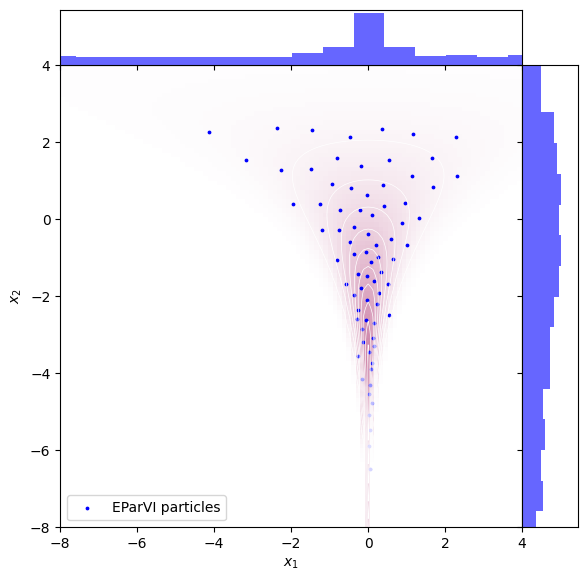

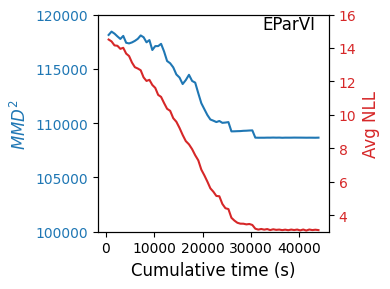

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.stats import norm

def target_p(x):
    x1, x2 = np.atleast_2d(x).T
    p_x2 = norm.pdf(x2, 0, 3.0) # # standard deviation for v
    p_x1_given_x2 = norm.pdf(x1, 0, np.exp(x2 / 2))
    return p_x1_given_x2 * p_x2
def plot_density(target_p, x_min, x_max, y_min, y_max, num_points=100):
    x = np.linspace(x_min, x_max, num_points)
    y = np.linspace(y_min, y_max, num_points)
    X, Y = np.meshgrid(x, y)
    Z = np.array([target_p(np.array([x, y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)

    # create a custom white-dark pink colormap
    colors = [(1, 1, 1), (0.6, 0, 0.3)]  # white to dark pink
    n_bins = 100  # Discretize the interpolation into 100 steps
    cmap_name = 'white_dark_pink'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    return X, Y, Z, cm

# parameters for plotting
low_xy, high_xy = -7, 3
margin = 1

ground_truth_samples = np.load(wd+'final results/Neal funnel/HMC_samples.npy')

MMD2_vec = []
NLL_vec = []
step_time_vec = []
for i in range(71):
    data = np.load(wd+f'final results/Neal funnel/Neals funnel EParVI/[step:{i}: x_neg, x_pos, step_time, mmd2_value, nll_value].npz')
    x_neg_current = data['x_neg']

    mask = (x_neg_current[:, 0] >= low_xy) & (x_neg_current[:, 0] <= high_xy) & (x_neg_current[:, 1] >= low_xy) & (x_neg_current[:, 1] <= high_xy)
    x_neg_current = x_neg_current[mask]

    mmd2_value = compute_mmd2(x_neg_current, ground_truth_samples)
    MMD2_vec.append(mmd2_value)

    nll_value = -np.mean(np.log(target_p(x_neg_current) + 1e-10))
    NLL_vec.append(nll_value)

    step_time = data['step_time']; step_time_vec.append(step_time)

final_data = np.load(wd+'final results/Neal funnel/Neals funnel EParVI/[step:70: x_neg, x_pos, step_time, mmd2_value, nll_value].npz')
final_particles = final_data['x_neg']

# plotting the samples and the density contours with marginal distributions
fig, ax_main = plt.subplots(figsize=(8, 6))

X, Y, Z, cm = plot_density(target_p, low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin)
img = ax_main.imshow(Z, extent=(low_xy - margin, high_xy + margin, low_xy - margin, high_xy + margin), origin='lower', cmap=cm, alpha=0.5)

# Plot the samples
scatter_samples = ax_main.scatter(final_particles[:, 0], final_particles[:, 1], c='blue', s=3, label='EParVI particles')

# Overlay contour lines
contour = ax_main.contour(X, Y, Z, levels=10, colors='white', linewidths=0.5)

# Set plot limits and labels
ax_main.set_xlim(low_xy - margin, high_xy + margin)
ax_main.set_ylim(low_xy - margin, high_xy + margin)
ax_main.set_xlabel(r'$x_1$')
ax_main.set_ylabel(r'$x_2$')
ax_main.legend(loc='lower left')

# Create inset axes for the histograms
ax_histx = inset_axes(ax_main, width="100%", height="60%", loc='upper center',
                      bbox_to_anchor=(0, 0.92, 1, 0.2), bbox_transform=ax_main.transAxes, borderpad=0)
ax_histy = inset_axes(ax_main, width="60%", height="100%", loc='center right',
                      bbox_to_anchor=(0.92, 0, 0.2, 1), bbox_transform=ax_main.transAxes, borderpad=0)

# Marginal histograms
ax_histx.hist(final_particles[:, 0], bins=30, density=True, color='blue', alpha=0.6)
ax_histy.hist(final_particles[:, 1], bins=30, density=True, color='blue', alpha=0.6, orientation='horizontal')

# Hide x labels and tick labels for the hist plots
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

# Disable y-ticks for the histograms
ax_histx.yaxis.set_ticks([])
ax_histy.xaxis.set_ticks([])

# Set the same x-ticks for the upper histogram
ax_histx.set_xlim(ax_main.get_xlim())
# Set the same y-ticks for the right histogram
ax_histy.set_ylim(ax_main.get_ylim())

plt.savefig(wd+f'final results/Neal funnel/EParVI.png')
plt.show()

# plot MMD^2 and NLL values over time
# Compute the cumulative sum of step times
cumulative_step_time = np.cumsum(step_time_vec)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(4,3))

# Plot MMD^2 on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Cumulative time (s)', fontsize=12)
ax1.set_ylabel(r'$MMD^2$', color=color, fontsize=12)
ax1.plot(cumulative_step_time, MMD2_vec, label=r'$MMD^2$', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([100000, 120000])
# ax1.legend(loc='upper left')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg NLL', color=color, fontsize=12)
ax2.plot(cumulative_step_time, NLL_vec, label='NLL', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([3, 16])
# ax2.legend(loc='upper right')

# Add text to the top right corner
fig.text(0.80, 0.93, 'EParVI', ha='right', va='top', fontsize=12, color='black')

# plt.title('MMD^2 and NLL vs Cumulative Time')
fig.tight_layout()  # to prevent overlap of y-axis labels
plt.show()

# BLR.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(111)

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = (iris.target == 0).astype(int)  # Binary classification: class 0 vs rest

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def assess_results(init_particles, final_particles, method=None):

    low_xy = -4
    high_xy = 4
    margin = 0

    reference_omega1 = -0.64
    reference_omega2 = 1.89

    # Plotting the samples and the density contours with marginal distributions
    fig, ax_main = plt.subplots(figsize=(8, 6))

    # Plot the samples
    scatter_samples_init = ax_main.scatter(init_particles[:, 0], init_particles[:, 1], c='grey', s=3, label=f'{method} init')
    scatter_samples_final = ax_main.scatter(final_particles[:, 0], final_particles[:, 1], c='blue', s=3, label=f'{method} final')
    scatter_reference = ax_main.scatter(reference_omega1, reference_omega2, c='red', s=60, label=f'LR reference')

    # Set plot limits and labels
    ax_main.set_xlim(low_xy - margin, high_xy + margin)
    ax_main.set_ylim(low_xy - margin, high_xy + margin)
    ax_main.set_xlabel(r'$\omega_1$', fontsize=18)
    ax_main.set_ylabel(r'$\omega_2$', fontsize=18)
    ax_main.legend(loc='lower right', fontsize=13)
    ax_main.set_xticklabels(ax_main.get_xticks(), fontsize=16)
    ax_main.set_yticklabels(ax_main.get_yticks(), fontsize=16)

    # Create inset axes for the histograms
    ax_histx = inset_axes(ax_main, width="100%", height="60%", loc='upper center',
                          bbox_to_anchor=(0, 0.92, 1, 0.2), bbox_transform=ax_main.transAxes, borderpad=0)
    ax_histy = inset_axes(ax_main, width="60%", height="100%", loc='center right',
                          bbox_to_anchor=(0.92, 0, 0.2, 1), bbox_transform=ax_main.transAxes, borderpad=0)

    # Marginal histograms
    ax_histx.hist(final_particles[:, 0], bins=20, density=True, color='blue', alpha=0.6)
    ax_histy.hist(final_particles[:, 1], bins=20, density=True, color='blue', alpha=0.6, orientation='horizontal')
    ax_histx.hist(init_particles[:, 0], bins=20, density=True, color='grey', alpha=0.6)
    ax_histy.hist(init_particles[:, 1], bins=20, density=True, color='grey', alpha=0.6, orientation='horizontal')

    # Hide x labels and tick labels for the hist plots
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)

    # Disable y-ticks for the histograms
    ax_histx.yaxis.set_ticks([])
    ax_histy.xaxis.set_ticks([])

    # Set the same x-ticks for the upper histogram
    ax_histx.set_xlim(ax_main.get_xlim())
    # Set the same y-ticks for the right histogram
    ax_histy.set_ylim(ax_main.get_ylim())

    plt.savefig(wd+f'final results/BLR/{method}.png')

    ### calculate MMD^2 and mean logp
    def polynomial_kernel(x, y):
        return (np.dot(x, y.T) / 3 + 1) ** 3
    def compute_mmd2(X, Y):
        N = X.shape[0]
        M = Y.shape[0]
        # Compute the polynomial kernel values
        Kxx = polynomial_kernel(X, X)  # Kernel between all pairs in X
        Kyy = polynomial_kernel(Y, Y)  # Kernel between all pairs in Y
        Kxy = polynomial_kernel(X, Y)  # Kernel between all pairs in X and Y
        # Compute the terms in the MMD squared formula
        term1 = (1 / (N * N)) * np.sum(Kxx)
        term2 = (1 / (M * M)) * np.sum(Kyy)
        term3 = (2 / (N * M)) * np.sum(Kxy)
        # Compute MMD squared
        mmd2 = term1 + term2 - term3
        return mmd2
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    def target_p(omega):
        alpha = 1.0
        # Ensure omega is 4-dimensional
        if omega.shape[0] != X_train_scaled.shape[1]:
            omega = np.resize(omega, (X_train_scaled.shape[1],))
        # Number of samples
        N = X_train_scaled.shape[0]
        # Compute the linear combination of features and coefficients
        linear_combination = np.dot(X_train_scaled, omega.reshape(-1, 1)).flatten()
        # Compute the likelihood term
        likelihood = np.prod(sigmoid(linear_combination) ** y_train * (1 - sigmoid(linear_combination)) ** (1 - y_train))
        # Compute the prior term
        prior = np.exp(-0.5 / alpha * np.dot(omega, omega))
        # Compute the unnormalized posterior
        posterior = likelihood * prior
        return posterior

    # Iris_data = np.load(wd+'final results/BLR/Iris_data.npz')
    X_train_scaled = Iris_data['X_train_scaled']
    y_train = Iris_data['y_train']

    ground_truth_samples = np.load(wd+'final results/BLR/HMC_BLR_samples.npy')

    samples_array = np.array(final_particles)
    mmd2_value = compute_mmd2(samples_array, ground_truth_samples)
    print(f'mmd2_value for final {method}:{mmd2_value}')

    nll_value = -np.mean(np.log(target_p(samples_array) + 1e-10))
    print(f'nll_value for final {method}:{nll_value}')

    ####
    # Predict on the test set: all posterior samples
    test_linear_combination = np.dot(X_test_scaled, samples_array.T)
    test_probs = 1 / (1 + np.exp(-test_linear_combination))
    test_preds = (np.mean(test_probs, axis=1) > 0.5).astype(int) #  mean prediction
    # Calculate accuracy on the test set
    accuracy = accuracy_score(y_test, test_preds)
    print(f'Accuracy on the test set (all samplles): {accuracy:.2f}')

    omega_mean = np.mean(samples_array, axis=0)
    # Predict on the test set using the mean of the posterior samples
    test_linear_combination = np.dot(X_test_scaled, omega_mean.reshape(-1, 1)).flatten()
    test_probs = 1 / (1 + np.exp(-test_linear_combination))
    test_preds = (test_probs > 0.5).astype(int)
    # Calculate accuracy on the test set
    accuracy = accuracy_score(y_test, test_preds)
    print(f'Accuracy on the test set (posterior mean): {accuracy:.2f}')


## LR via MLE.

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score

# Load the data from the .npz file
Iris_data = np.load(wd+'final results/BLR/Iris_data.npz')
X = Iris_data['X']
y = Iris_data['y']
X_train_scaled = Iris_data['X_train_scaled']
X_test_scaled = Iris_data['X_test_scaled']
y_train = Iris_data['y_train']
y_test = Iris_data['y_test']

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Log-likelihood function
def log_likelihood(coef, X, y):
    linear_combination = np.dot(X, coef)
    log_lik = -np.sum(y * np.log(sigmoid(linear_combination)) + (1 - y) * np.log(1 - sigmoid(linear_combination)))
    return log_lik

# Gradient of the log-likelihood
def gradient(coef, X, y):
    linear_combination = np.dot(X, coef)
    errors = y - sigmoid(linear_combination)
    grad = -np.dot(X.T, errors)
    return grad

# Initial guess for the coefficients
initial_coef = np.zeros(X_train_scaled.shape[1])

# Optimize the log-likelihood function
result = minimize(log_likelihood, initial_coef, args=(X_train_scaled, y_train), jac=gradient, method='BFGS')
coef_optimal = result.x
print(f'cofficients found by MLE: {coef_optimal}')

# Predict on the test set
linear_combination_test = np.dot(X_test_scaled, coef_optimal)
test_probs = sigmoid(linear_combination_test)
test_preds = (test_probs > 0.5).astype(int)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, test_preds)
print(f'Optimal coefficients: {coef_optimal}')
print(f'Accuracy on the test set: {accuracy:.2f}')

cofficients found by MLE: [  0.58501773   6.67985169 -12.16672918  -2.26147896]
Optimal coefficients: [  0.58501773   6.67985169 -12.16672918  -2.26147896]
Accuracy on the test set: 1.00


<ipython-input-91-9a465d561ca9>:19: RuntimeWarning: divide by zero encountered in log
  log_lik = -np.sum(y * np.log(sigmoid(linear_combination)) + (1 - y) * np.log(1 - sigmoid(linear_combination)))
<ipython-input-91-9a465d561ca9>:19: RuntimeWarning: invalid value encountered in multiply
  log_lik = -np.sum(y * np.log(sigmoid(linear_combination)) + (1 - y) * np.log(1 - sigmoid(linear_combination)))
<ipython-input-91-9a465d561ca9>:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-91-9a465d561ca9>:19: RuntimeWarning: divide by zero encountered in log
  log_lik = -np.sum(y * np.log(sigmoid(linear_combination)) + (1 - y) * np.log(1 - sigmoid(linear_combination)))
<ipython-input-91-9a465d561ca9>:19: RuntimeWarning: invalid value encountered in multiply
  log_lik = -np.sum(y * np.log(sigmoid(linear_combination)) + (1 - y) * np.log(1 - sigmoid(linear_combination)))


scikit-learn implements its own MLE.

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the data from the .npz file
Iris_data = np.load(wd+'final results/BLR/Iris_data.npz')
X = Iris_data['X']
y = Iris_data['y']
X_train_scaled = Iris_data['X_train_scaled']
X_test_scaled = Iris_data['X_test_scaled']
y_train = Iris_data['y_train']
y_test = Iris_data['y_test']

# Create and fit the logistic regression model without intercept
model = LogisticRegression(fit_intercept=False, solver='lbfgs')
model.fit(X_train_scaled, y_train)

# Get the coefficients
coef_optimal = model.coef_

# Predict on the test set
test_preds = model.predict(X_test_scaled)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, test_preds)

print(f'Optimal coefficients: {coef_optimal}')
print(f'Accuracy on the test set: {accuracy:.2f}')

Optimal coefficients: [[-0.64168886  1.8890332  -1.75160821 -1.66607369]]
Accuracy on the test set: 1.00


## HMC.

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(111)

# Define the Bayesian logistic regression model
with pm.Model() as model:
    # Prior for the regression coefficients
    alpha = 1.0
    omega = pm.Normal('omega', mu=0, sigma=alpha, shape=X_train_scaled.shape[1])

    # Linear combination
    linear_combination = pm.math.dot(X_train_scaled, omega)

    # Likelihood
    p = pm.Deterministic('p', pm.math.sigmoid(linear_combination))
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_train)

    # Sampling
    trace = pm.sample(2000, tune=1000, chains=1, cores=1, return_inferencedata=True, discard_tuned_samples=True, random_seed=111)

# Summary of the trace
summary = pm.summary(trace).round(2)

# Plot the trace
pm.plot_trace(trace)

omega_samples = trace.posterior['omega'].values
# Reshape omega_samples to (number of samples, number of coefficients) if needed
omega_samples = omega_samples.reshape(-1, omega_samples.shape[-1])
# Plot the omega samples
num_coefficients = omega_samples.shape[1]
fig, axes = plt.subplots(num_coefficients, 1, figsize=(8, 2 * num_coefficients))
for i in range(num_coefficients):
    axes[i].hist(omega_samples[:, i], bins=30, density=True, alpha=0.7, color='b')
    axes[i].set_title(f'Omega {i+1} samples')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
plt.tight_layout()
plt.show()

# Posterior predictive check
with model:
    posterior_predictive = pm.smple_posterior_predictive(trace, var_names=['omega'])
posterior_predictive

# Predict on the test set: all posterior samples
test_linear_combination = np.dot(X_test_scaled, omega_samples.T)
test_probs = 1 / (1 + np.exp(-test_linear_combination))
test_preds = (np.mean(test_probs, axis=1) > 0.5).astype(int) #  mean prediction
# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, test_preds)
print(f'Accuracy on the test set: {accuracy:.2f}')

omega_mean = np.mean(omega_samples, axis=0)
# Predict on the test set using the mean of the posterior samples
test_linear_combination = np.dot(X_test_scaled, omega_mean.reshape(-1, 1)).flatten()
test_probs = 1 / (1 + np.exp(-test_linear_combination))
test_preds = (test_probs > 0.5).astype(int)
# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, test_preds)
print(f'Accuracy on the test set using the mean of the posterior samples: {accuracy:.2f}')


HMC_BLR_samples = omega_samples.copy()[:400]
np.save(wd+'plots/HMC_BLR_samples', HMC_BLR_samples)

np.savez(wd+'plots/Iris_data.npz', X=X, y=y, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, X_train_scaled=X_train_scaled, X_test_scaled=X_test_scaled)

In [ ]:
HMC_final_particles = np.load(wd+f'final results/BLR/HMC_BLR_samples.npy')

# Predict on the test set: all posterior samples
test_linear_combination = np.dot(X_test_scaled, HMC_final_particles.T)
test_probs = 1 / (1 + np.exp(-test_linear_combination))
test_preds = (np.mean(test_probs, axis=1) > 0.5).astype(int) #  mean prediction
# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, test_preds)
print(f'Accuracy on the test set (all samplles): {accuracy:.2f}')

omega_mean = np.mean(HMC_final_particles, axis=0)
# Predict on the test set using the mean of the posterior samples
test_linear_combination = np.dot(X_test_scaled, omega_mean.reshape(-1, 1)).flatten()
test_probs = 1 / (1 + np.exp(-test_linear_combination))
test_preds = (test_probs > 0.5).astype(int)
# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, test_preds)
print(f'Accuracy on the test set (posterior mean): {accuracy:.2f}')

print(f'final_mean: {np.mean(HMC_final_particles, axis=0)}')

Accuracy on the test set (all samplles): 1.00
Accuracy on the test set (posterior mean): 1.00
final_mean: [-0.68589401  1.9805626  -1.84005437 -1.85596591]


<ipython-input-194-80a893631f3e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_xticklabels(ax_main.get_xticks(), fontsize=16)
<ipython-input-194-80a893631f3e>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_yticklabels(ax_main.get_yticks(), fontsize=16)


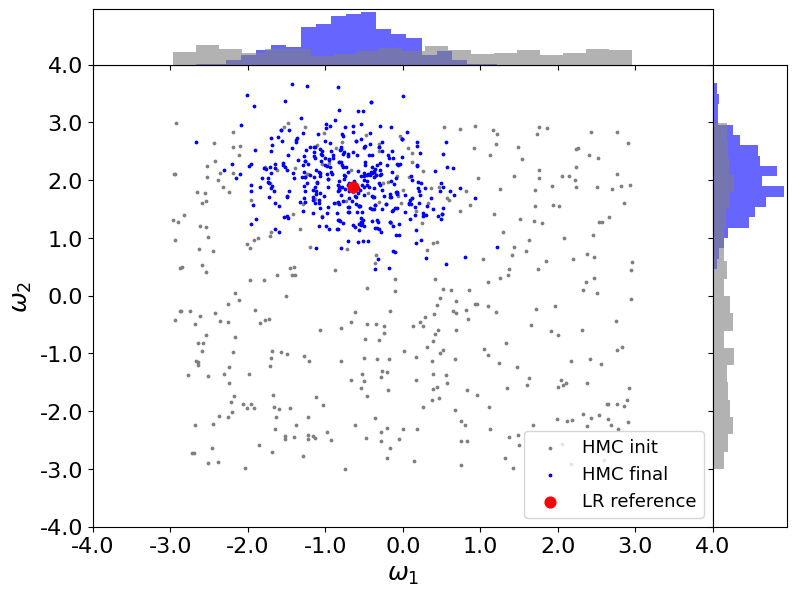

In [ ]:
low_xy = -4
high_xy = 4
margin = 0

reference_omega1 = -0.64
reference_omega2 = 1.89

init_particles = np.load(wd+'final results/BLR/x_neg_init.npy')
HMC_final_particles = np.load(wd+f'final results/BLR/HMC_BLR_samples.npy')

# Plotting the samples and the density contours with marginal distributions
fig, ax_main = plt.subplots(figsize=(8, 6))

# Plot the samples
scatter_samples_init = ax_main.scatter(init_particles[:, 0], init_particles[:, 1], c='grey', s=3, label=f'HMC init')
scatter_samples_final = ax_main.scatter(HMC_final_particles[:, 0], HMC_final_particles[:, 1], c='blue', s=3, label=f'HMC final')
scatter_reference = ax_main.scatter(reference_omega1, reference_omega2, c='red', s=60, label=f'LR reference')

# Set plot limits and labels
ax_main.set_xlim(low_xy - margin, high_xy + margin)
ax_main.set_ylim(low_xy - margin, high_xy + margin)
ax_main.set_xlabel(r'$\omega_1$', fontsize=18)
ax_main.set_ylabel(r'$\omega_2$', fontsize=18)
ax_main.legend(loc='lower right', fontsize=13)
ax_main.set_xticklabels(ax_main.get_xticks(), fontsize=16)
ax_main.set_yticklabels(ax_main.get_yticks(), fontsize=16)

# Create inset axes for the histograms
ax_histx = inset_axes(ax_main, width="100%", height="60%", loc='upper center',
                      bbox_to_anchor=(0, 0.92, 1, 0.2), bbox_transform=ax_main.transAxes, borderpad=0)
ax_histy = inset_axes(ax_main, width="60%", height="100%", loc='center right',
                      bbox_to_anchor=(0.92, 0, 0.2, 1), bbox_transform=ax_main.transAxes, borderpad=0)

# Marginal histograms
ax_histx.hist(HMC_final_particles[:, 0], bins=20, density=True, color='blue', alpha=0.6)
ax_histy.hist(HMC_final_particles[:, 1], bins=20, density=True, color='blue', alpha=0.6, orientation='horizontal')
ax_histx.hist(init_particles[:, 0], bins=20, density=True, color='grey', alpha=0.6)
ax_histy.hist(init_particles[:, 1], bins=20, density=True, color='grey', alpha=0.6, orientation='horizontal')

# Hide x labels and tick labels for the hist plots
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

# Disable y-ticks for the histograms
ax_histx.yaxis.set_ticks([])
ax_histy.xaxis.set_ticks([])

# Set the same x-ticks for the upper histogram
ax_histx.set_xlim(ax_main.get_xlim())
# Set the same y-ticks for the right histogram
ax_histy.set_ylim(ax_main.get_ylim())

plt.savefig(wd+f'final results/BLR/HMC.png')

## EParVI.

shared func.

In [ ]:
import numpy as np
from scipy.special import gamma
from matplotlib.colors import Normalize
import copy

np.random.seed(111)

# Compute the comparison metric MMD**2
def polynomial_kernel(x, y):
    return (np.dot(x, y.T) / 3 + 1) ** 3

def compute_mmd2(X, Y):
    N = X.shape[0]
    M = Y.shape[0]
    # Compute the polynomial kernel values
    Kxx = polynomial_kernel(X, X)  # Kernel between all pairs in X
    Kyy = polynomial_kernel(Y, Y)  # Kernel between all pairs in Y
    Kxy = polynomial_kernel(X, Y)  # Kernel between all pairs in X and Y
    # Compute the terms in the MMD squared formula
    term1 = (1 / (N * N)) * np.sum(Kxx)
    term2 = (1 / (M * M)) * np.sum(Kyy)
    term3 = (2 / (N * M)) * np.sum(Kxy)
    # Compute MMD squared
    mmd2 = term1 + term2 - term3
    return mmd2

# General parameters (can be overwritten later for each individual case)
def set_params(update_rule, overwrite_params_dict=None):
    M_neg = 400  # Number of negative charges
    M_pos = 50**2  # Number of positive charges
    d = 4        # Dimensionality (updated to 4)
    q_neg = np.ones(M_neg)  # Charge of negative particles
    q_pos = 1.0             # Charge of positive particles
    q_pos_auto_annealing = False
    epsilon_0 = 8.854e-12   # Permittivity of free space; alternatively: 55.26349406

    SEED = 111              # Random seed for reproducibility
    num_steps = 100         # Number of time steps
    plot_interval = 5       # Plot every 5 steps
    normalize_overall_forces = True  # Whether to normalize forces or not. It affects the choice of step size later.
    normalise_attr_forces = False    # Whether to normalize attracting forces or not
    particle_filtering = False
    move_threshold = 1e-4   # Movement threshold for early stopping
    patience = 5            # Number of consecutive steps with small movements to trigger early stopping

    tau = 0.1
    delta_t = 0.01
    noise_std = 0

    if update_rule == 'Euler':
        tau = 0.1              # Time step size
        noise_std = 0.01       # Standard deviation for Gaussian noise added to the positions
    elif update_rule == 'Verlet':
        q_pos = 5.0
        num_steps = 300
        delta_t = 0.01          # Time step size
        noise_std = 0           # Standard deviation for Gaussian noise added to the positions
    elif update_rule == 'damped_Verlet':
        q_pos = 5.0
        num_steps = 300
        tau = 0.5               # Parameter tau
        delta_t = 0.1           # Time step size
        noise_std = 0

    params_dict = {
        'M_neg': M_neg,
        'M_pos': M_pos,
        'd': d,
        'q_neg': q_neg,
        'q_pos': q_pos,
        'q_pos_auto_annealing': q_pos_auto_annealing,
        'epsilon_0': epsilon_0,
        'SEED': SEED,
        'num_steps': num_steps,
        'plot_interval': plot_interval,
        'normalize_overall_forces': normalize_overall_forces,
        'normalise_attr_forces': normalise_attr_forces,
        'particle_filtering': particle_filtering,
        'move_threshold': move_threshold,
        'patience': patience,
        'tau': tau,
        'delta_t': delta_t,
        'noise_std': noise_std
    }
    # Overwrite parameters if provided
    if overwrite_params_dict is not None:
        for key, value in overwrite_params_dict.items():
            if key in params_dict:
                params_dict[key] = value

    return params_dict

def initialize_positions(target_p, M_neg, M_pos, d, init_dict=None, SEED=111):
    np.random.seed(SEED)

    init_type = init_dict['init_type']

    # Initialize the positions of the positive charges on a grid within [low_xy, high_xy] x [low_xy, high_xy]
    grid_size = int(np.ceil(M_pos**(1/d)))
    linspace = np.linspace(init_dict['low_xy'], init_dict['high_xy'], grid_size)
    mesh = np.meshgrid(*([linspace]*d))
    x_pos = np.vstack([m.ravel() for m in mesh]).T[:M_pos]

    # Initialize the positions of the negative charges within [low_uniform, high_uniform] x [low_uniform, high_uniform]
    if init_type == 'uniform':
        x_neg = np.random.uniform(
            low=init_dict['low_uniform'],
            high=init_dict['high_uniform'],
            size=(M_neg, d)
        )
    elif init_type == 'gaussian':
        x_neg = np.random.normal(loc=init_dict['initial_gaussian_center'], scale=init_dict['initial_gaussian_std'], size=(M_neg, d))
        x_neg = np.clip(x_neg, init_dict['low_xy'], init_dict['high_xy'])
    elif init_type == 'probabilistic':
        # Grid points
        grid_size = 100
        linspace = np.linspace(init_dict['low_xy'], init_dict['high_xy'], grid_size)
        mesh = np.meshgrid(*([linspace] * d))
        grid_points = np.vstack([m.ravel() for m in mesh]).T

        # Compute probability mass at each grid point
        probabilities = target_p(grid_points)
        probabilities = probabilities.flatten()
        probabilities /= np.sum(probabilities)  # Normalize to sum to 1

        # Sample indices based on the probabilities
        sampled_indices = np.random.choice(len(grid_points), size=M_neg, p=probabilities)
        x_neg = grid_points[sampled_indices]
    else:
        raise ValueError("init_type must be either 'uniform', 'gaussian', or 'probabilistic'")

    return x_neg, x_pos

def compute_forces(x_neg, x_pos, q_neg, q_pos, target_p, epsilon_0, d, normalise_attr_forces):
    M_neg = x_neg.shape[0]
    M_pos = x_pos.shape[0]

    F_rep = np.zeros_like(x_neg)
    F_attr = np.zeros_like(x_neg)

    # Compute the normalization constant for target_p if normalization is enabled
    if normalise_attr_forces:
        attr_normalization_constant = np.sum([target_p(x_pos[i_prime]) for i_prime in range(M_pos)])
    else:
        attr_normalization_constant = 1  # Set to 1 to avoid altering the target_p values

    # Compute repulsive forces
    for j in range(M_neg):
        for i in range(M_neg):
            if i != j:
                r_ij = np.linalg.norm(x_neg[j] - x_neg[i])
                if r_ij > 0:
                    F_rep[j] += (q_neg[i] * q_neg[j] * gamma(d/2)) / (2 * np.pi**(d/2) * epsilon_0 * r_ij**(d-1)) * (x_neg[j] - x_neg[i]) / r_ij
    # Compute attractive forces
    for j in range(M_neg):
        for i_prime in range(M_pos):
            r_ij = np.linalg.norm(x_neg[j] - x_pos[i_prime])
            if r_ij > 0:
                normalized_target_p = target_p(x_pos[i_prime]) / attr_normalization_constant
                F_attr[j] -= (q_pos * normalized_target_p * q_neg[j] * gamma(d/2)) / (2 * np.pi**(d/2) * epsilon_0 * r_ij**(d-1)) * (x_neg[j] - x_pos[i_prime]) / r_ij

    print(f'F_rep:\n {F_rep[:10]} \n F_attr:\n {F_attr[:10]}')
    return F_rep, F_attr, F_rep + F_attr

def evolve_system(init_dict, update_rule, x_neg, x_pos, params_dict, target_p, ground_truth_samples):
    d = params_dict['d']
    q_neg = params_dict['q_neg']
    q_pos = params_dict['q_pos']
    q_pos_auto_annealing = params_dict['q_pos_auto_annealing']
    num_steps = params_dict['num_steps']
    plot_interval = params_dict['plot_interval']
    normalize_overall_forces = params_dict['normalize_overall_forces']
    normalise_attr_forces = params_dict['normalise_attr_forces']
    particle_filtering = params_dict['particle_filtering']
    move_threshold = params_dict['move_threshold']
    patience = params_dict['patience']
    noise_std = params_dict['noise_std']
    delta_t = params_dict['delta_t']
    epsilon_0 = params_dict['epsilon_0']
    tau = params_dict['tau']
    low_xy = init_dict['low_xy']
    high_xy = init_dict['high_xy']
    margin = init_dict['margin']

    x_neg_prev = x_neg.copy()
    consecutive_small_moves = 0

    # Create a dict to store all negative particle trajectories
    all_trajectories = {idx: [] for idx in range(params_dict['M_neg'])}

    # Move negative particles
    particle_counts_vec = []
    remained_neg_indices_all_iterations = []
    removed_neg_indices_all_iterations = []
    original_neg_indices = np.arange(params_dict['M_neg'])
    if q_pos_auto_annealing and normalise_attr_forces:  # Then q_pos=params_dict['q_pos'] is interpreted as how many times at initial the positive charge is
        init_F_rep = compute_forces(x_neg, x_pos, q_neg, q_pos, target_p, epsilon_0, d, normalise_attr_forces)[0]
        init_distances = cdist(x_neg, x_pos, metric='euclidean')
        median_init_distances = np.median(init_distances.flatten())
        q_pos0 = q_pos * np.max(np.abs(init_F_rep)) * median_init_distances**(d-1) * epsilon_0 * 2 * np.pi**(d/2) / (q_neg[0] * gamma(d/2))
        q_pos = copy.deepcopy(q_pos0)
    print(f'q_pos: {q_pos}')
    step_time_vec = []
    MMD2_vec = []
    NLL_vec = []
    for t in range(48, 48+num_steps):
        print(f'step: {t}')
        start_time = time.time()

        # Count how many of x_neg are lying within the square [low_xy,high_xy]×[low_xy,high_xy] in the current iteration.
        mask = (x_neg[:, 0] >= low_xy) & (x_neg[:, 0] <= high_xy) & (x_neg[:, 1] >= low_xy) & (x_neg[:, 1] <= high_xy)
        count = np.sum(mask)
        particle_counts_vec.append(count)
        print(f'no. of negative charges currently contained within the square [{low_xy},{high_xy}] (particle_filtering:{particle_filtering}): {count}')
        if particle_filtering:  # Remove those negative charges falling outside
            x_neg = x_neg[mask]
            remained_indices = original_neg_indices[mask]
            removed_indices = original_neg_indices[~mask]
            remained_neg_indices_all_iterations.append(remained_indices.tolist())
            removed_neg_indices_all_iterations.append(removed_indices.tolist())
            original_neg_indices = remained_indices
        else:
            remained_indices = original_neg_indices

        # Attach the trajectories
        for idx_original, idx_new in zip(remained_indices, np.arange(len(remained_indices))):
            all_trajectories[idx_original].append(x_neg[idx_new].copy())

        # Compute MMD^2 and mean logp
        mmd2_value = compute_mmd2(x_neg[remained_indices], ground_truth_samples)
        MMD2_vec.append(mmd2_value)
        nll_value = -np.mean(np.log(target_p(x_neg[remained_indices]) + 1e-10))
        NLL_vec.append(nll_value)

        # Now x_neg, x_pos (and q_pos) are both set up, we are ready to compute the forces.
        F_rep, F_attr, F = compute_forces(x_neg, x_pos, q_neg, q_pos, target_p, epsilon_0, d, normalise_attr_forces)
        if normalize_overall_forces:
            # Normalize the force vectors for each particle
            norm_F = np.linalg.norm(F, axis=1).reshape(-1, 1)
            norm_F[norm_F == 0] = 1  # Avoid division by zero
            F = F / norm_F

        if update_rule == 'Euler':
            # Simple Euler method
            delta_x = tau * F
        elif update_rule == 'Verlet':
            # Verlet Integration (Leapfrog Method)
            delta_x = F * (delta_t ** 2) + 2 * x_neg - x_neg_prev - x_neg
        elif update_rule == 'damped_Verlet':
            # Damped Verlet Integration (Modified Method)
            delta_x = tau * (F * (delta_t ** 2) + (x_neg - x_neg_prev))
        else:
            raise ValueError("Invalid update rule specified.")

        x_neg_next = x_neg + delta_x

        # Add Gaussian noise to the positions
        noise = np.random.normal(loc=0, scale=noise_std, size=x_neg.shape)
        x_neg_next += noise

        # Update positions
        x_neg_prev = x_neg.copy()
        x_neg = x_neg_next

        # Annealing q_pos
        if q_pos_auto_annealing and normalise_attr_forces:
            q_pos = np.max([(q_pos0 - 1) * np.exp(-0.1 * t) + 1, 0.5 * q_pos0])  # q_pos decreases from q_pos and lower bounded by 1 = q_neg
        print(f'q_pos: {q_pos}')

        end_time = time.time()
        step_time = end_time - start_time
        print(f'step time: {step_time} seconds')
        step_time_vec.append(step_time)

        # Save x_neg in each iteration
        np.savez(wd+f'plots/[step:{t}: x_neg, x_pos, step_time, mmd2_value, nll_value].npz',
                 x_neg=x_neg, x_pos=x_pos, step_time=step_time, mmd2_value=mmd2_value, nll_value=nll_value)

        # Check for early stopping
        if np.all(np.linalg.norm(delta_x + noise, axis=1) < move_threshold):
            consecutive_small_moves += 1
        else:
            consecutive_small_moves = 0

        if consecutive_small_moves >= patience:
            print(f"Early stopping at step {t} due to small movements.")
            break

    return x_neg, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec

# Plot the all_trajectories of selected particles
def trajectory_plot(all_trajectories, selected_indices, target_p, x_pos, low_xy, high_xy, margin, params_dict, init_dict, total_time):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create a colormap for the trajectories
    num_colors = len(selected_indices)
    colors = plt.cm.viridis(np.linspace(0, 1, num_colors))

    # Plot all trajectories
    for idx, color in zip(selected_indices, colors):
        traj = np.array(all_trajectories[idx])
        ax.plot(traj[:, 0], traj[:, 1], color=color, label='Trajectory' if idx == selected_indices[0] else "")  # Plot entire trajectory
        ax.scatter(traj[0, 0], traj[0, 1], color=color, marker='o', s=60, label='Initial position' if idx == selected_indices[0] else "")  # Initial position
        ax.scatter(traj[-1, 0], traj[-1, 1], color=color, marker='s', s=60, label='Final position' if idx == selected_indices[0] else "")  # Final position

    ax.set_xlim(low_xy - margin, high_xy + margin)
    ax.set_ylim(low_xy - margin, high_xy + margin)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title('Trajectories of selected particles')
    plt.savefig(wd+f"plots/selected_trajectories (M_neg:{params_dict['M_neg']},M_pos:{params_dict['M_pos']},num_steps:{params_dict['num_steps']},init_type:{init_dict['init_type']},total_time:{total_time}).png")
    plt.show()

main code.

In [ ]:
import numpy as np
import time
import pickle
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(111)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def target_p(omega):
    alpha = 1.0
    # Ensure omega is 4-dimensional
    if omega.shape[0] != X_train_scaled.shape[1]:
        omega = np.resize(omega, (X_train_scaled.shape[1],))
    # Number of samples
    N = X_train_scaled.shape[0]
    # Compute the linear combination of features and coefficients
    linear_combination = np.dot(X_train_scaled, omega.reshape(-1, 1)).flatten()
    # Compute the likelihood term
    likelihood = np.prod(sigmoid(linear_combination) ** y_train * (1 - sigmoid(linear_combination)) ** (1 - y_train))
    # Compute the prior term
    prior = np.exp(-0.5 / alpha * np.dot(omega, omega))
    # Compute the unnormalized posterior
    posterior = likelihood * prior
    return posterior

update_rule = 'Euler'
params_dict = set_params(update_rule, {'num_steps':60,
    'd': 4,
    'M_pos': 12**4,
    'q_pos': 1e7,
    'q_pos_auto_annealing': False,
    'normalize_overall_forces': True,
    'normalise_attr_forces': False,
    'particle_filtering': False,
    'noise_std': 0
})

init_dict = {'init_type': 'uniform', 'low_uniform': -3, 'high_uniform': 3, 'low_xy': -3, 'high_xy': 3, 'margin': 0}

start_time = time.time()
# Initialize positions with a seed for reproducibility
x_neg, x_pos = initialize_positions(target_p=target_p,
                                    M_neg=params_dict['M_neg'],
                                    M_pos=params_dict['M_pos'],
                                    d=params_dict['d'],
                                    init_dict=init_dict,
                                    SEED=params_dict['SEED'])
np.save(wd+'plots/x_neg_init.npy', x_neg)
# Generate 5000 ground truth samples
ground_truth_samples = np.load(wd+'plots/HMC_BLR_samples.npy')
# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    target_p=target_p,
    ground_truth_samples=ground_truth_samples)
end_time = time.time()
total_time = end_time - start_time
print(f'total run time: {total_time} seconds')

# Plot trajectories for selected particles
selected_indices = [2, 40, 141, 145]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                target_p=target_p,
                x_pos=x_pos,
                low_xy=init_dict['low_xy'],
                high_xy=init_dict['high_xy'],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# Save results
results_dict = {
    'update_rule': update_rule,
    'params_dict': params_dict,
    'init_dict': init_dict,
    'init_x_neg': x_neg,
    'init_x_pos': x_pos,
    'x_neg_final': x_neg_final,
    'all_trajectories': all_trajectories,
    'particle_counts_vec': particle_counts_vec,
    'selected_indices': selected_indices,
    'total_time': total_time,
    'step_time_vec': step_time_vec,
    'MMD2_vec': MMD2_vec,
    'NLL_vec': NLL_vec
}
# Saving the dictionary
with open(wd+'results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

run after interuption.

In [ ]:
import numpy as np
import time
import pickle
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

np.random.seed(111)

# Load the data from the .npz file
Iris_data = np.load(wd+'final results/BLR EparVI/Iris_data.npz')
X = Iris_data['X']
y = Iris_data['y']
X_train_scaled = Iris_data['X_train_scaled']
X_test_scaled = Iris_data['X_test_scaled']
y_train = Iris_data['y_train']
y_test = Iris_data['y_test']

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def target_p(omega):
    alpha = 1.0
    # Ensure omega is 4-dimensional
    if omega.shape[0] != X_train_scaled.shape[1]:
        omega = np.resize(omega, (X_train_scaled.shape[1],))
    # Number of samples
    N = X_train_scaled.shape[0]
    # Compute the linear combination of features and coefficients
    linear_combination = np.dot(X_train_scaled, omega.reshape(-1, 1)).flatten()
    # Compute the likelihood term
    likelihood = np.prod(sigmoid(linear_combination) ** y_train * (1 - sigmoid(linear_combination)) ** (1 - y_train))
    # Compute the prior term
    prior = np.exp(-0.5 / alpha * np.dot(omega, omega))
    # Compute the unnormalized posterior
    posterior = likelihood * prior
    return posterior

update_rule = 'Euler'
params_dict = set_params(update_rule, {'num_steps':13,
    'd': 4,
    'M_pos': 12**4,
    'q_pos': 1e7,
    'q_pos_auto_annealing': False,
    'normalize_overall_forces': True,
    'normalise_attr_forces': False,
    'particle_filtering': False,
    'noise_std': 0
})

init_dict = {'init_type': 'uniform', 'low_uniform': -3, 'high_uniform': 3, 'low_xy': -3, 'high_xy': 3, 'margin': 0}

start_time = time.time()
last_data = np.load(wd+f'plots/till 47/[step:47: x_neg, x_pos, step_time, mmd2_value, nll_value].npz')
x_neg = last_data['x_neg']
x_pos = last_data['x_pos']

# Generate 5000 ground truth samples
ground_truth_samples = np.load(wd+'plots/HMC_BLR_samples.npy')
# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    target_p=target_p,
    ground_truth_samples=ground_truth_samples)
end_time = time.time()
total_time = end_time - start_time
print(f'total run time: {total_time} seconds')

# Plot trajectories for selected particles
selected_indices = [2, 40, 141, 145]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                target_p=target_p,
                x_pos=x_pos,
                low_xy=init_dict['low_xy'],
                high_xy=init_dict['high_xy'],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# Save results
results_dict = {
    'update_rule': update_rule,
    'params_dict': params_dict,
    'init_dict': init_dict,
    'init_x_neg': x_neg,
    'init_x_pos': x_pos,
    'x_neg_final': x_neg_final,
    'all_trajectories': all_trajectories,
    'particle_counts_vec': particle_counts_vec,
    'selected_indices': selected_indices,
    'total_time': total_time,
    'step_time_vec': step_time_vec,
    'MMD2_vec': MMD2_vec,
    'NLL_vec': NLL_vec
}
# Saving the dictionary
with open(wd+'results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

analysis.

In [ ]:
results_data = np.load(wd+'plots/[step:0: x_neg, x_pos, step_time, mmd2_value, nll_value].npz')
x_neg_final = results_data['x_neg']
x_neg_init = x_neg

low_xy = -3
high_xy = 3

x_neg_plot = x_neg_final.copy()

whole_mean = np.mean(x_neg_plot, axis=0)
print(f'Overall mean of the particles: {whole_mean}')

# Create a mask for particles within the box
mask = (x_neg_plot[:, 0] >= low_xy) & (x_neg_plot[:, 0] <= high_xy) & \
       (x_neg_plot[:, 1] >= low_xy) & (x_neg_plot[:, 1] <= high_xy) & \
       (x_neg_plot[:, 2] >= low_xy) & (x_neg_plot[:, 2] <= high_xy) & \
       (x_neg_plot[:, 3] >= low_xy) & (x_neg_plot[:, 3] <= high_xy)

# Count the number of particles within the box
count = np.sum(mask)
print(f'Number of negative charges currently contained within the box [{low_xy},{high_xy}]: {count}')

# Calculate the mean of the particles within the box
mean_within_box = np.mean(x_neg_plot[mask], axis=0)
print(f'Mean of the particles within the box: {mean_within_box}')

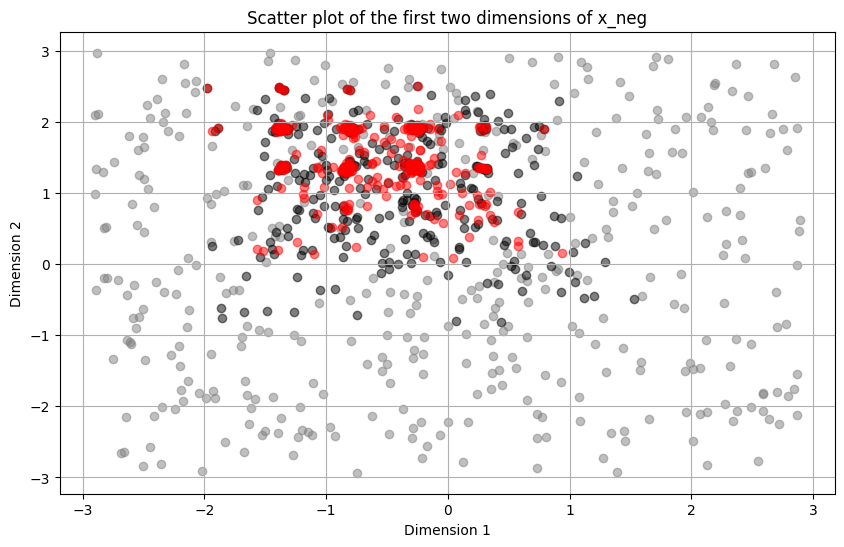

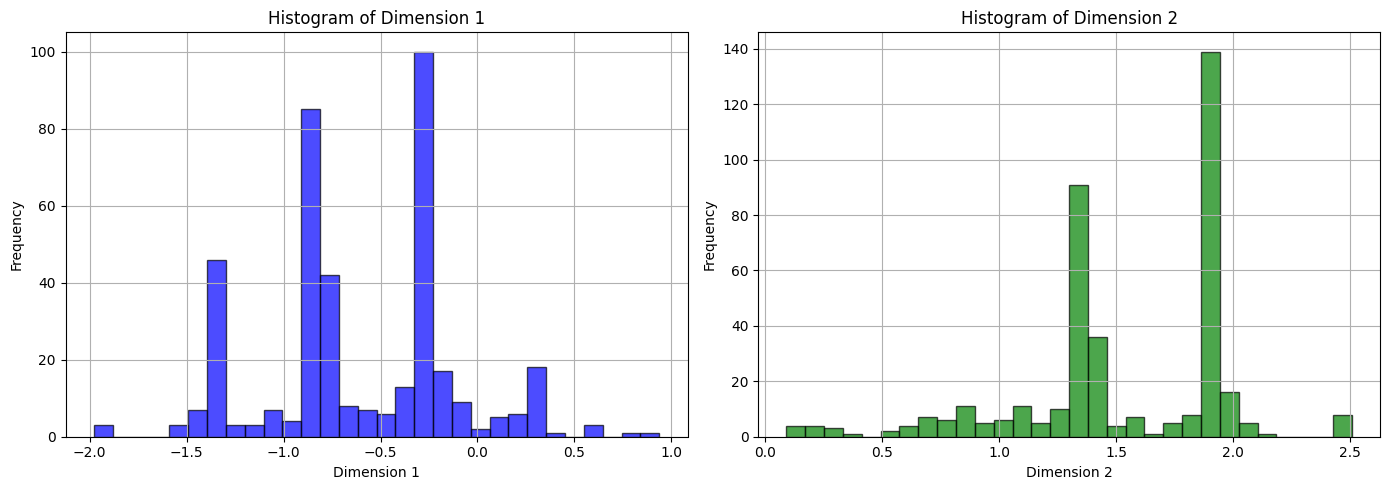

In [ ]:
init_EParVI_data = np.load(wd+f'test/[step 0 x_neg, x_pos, step_time, mmd2_value, nll_value].npz')
x_neg_init = init_EParVI_data['x_neg']
inter_EParVI_data = np.load(wd+f'test/[step 33 x_neg, x_pos, step_time, mmd2_value, nll_value].npz')
x_neg_inter = inter_EParVI_data['x_neg']
current_EParVI_data = np.load(wd+f'test/[step 47 x_neg, x_pos, step_time, mmd2_value, nll_value].npz')
x_neg_current = current_EParVI_data['x_neg']

plt.figure(figsize=(10, 6))
plt.scatter(x_neg_init[:, 0], x_neg_init[:, 1], alpha=0.5, color='grey')
plt.scatter(x_neg_inter[:, 0], x_neg_inter[:, 1], alpha=0.5, color='black')
plt.scatter(x_neg_current[:, 0], x_neg_current[:, 1], alpha=0.5, color='red')
plt.title('Scatter plot of the first two dimensions of x_neg')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# Create histograms for the marginal distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].hist(x_neg_current[:, 0], bins=30, alpha=0.7, color='blue', edgecolor='black')
ax[0].set_title('Histogram of Dimension 1')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Frequency')
ax[0].grid(True)

ax[1].hist(x_neg_current[:, 1], bins=30, alpha=0.7, color='green', edgecolor='black')
ax[1].set_title('Histogram of Dimension 2')
ax[1].set_xlabel('Dimension 2')
ax[1].set_ylabel('Frequency')
ax[1].grid(True)

plt.tight_layout()
plt.show()

<ipython-input-195-5baff74843c8>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_xticklabels(ax_main.get_xticks(), fontsize=16)
<ipython-input-195-5baff74843c8>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_yticklabels(ax_main.get_yticks(), fontsize=16)


mmd2_value for final EParVI:23.254191521153444
nll_value for final EParVI:11.316749623250768
Accuracy on the test set (all samplles): 1.00
Accuracy on the test set (posterior mean): 1.00
final_mean: [-0.64050836  1.61796446 -1.50114861 -1.41591158]


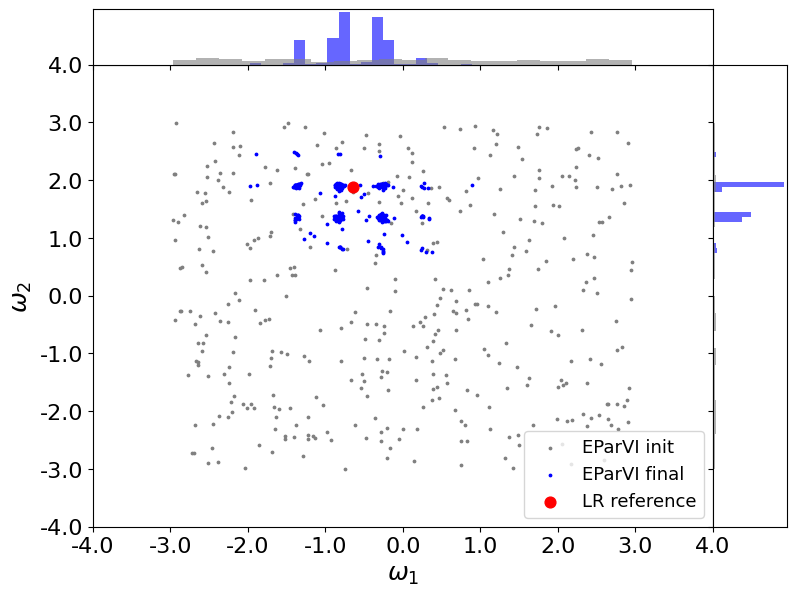

In [ ]:
EParVI_init_particles = np.load(wd+'final results/BLR/EParVI (full 60)/x_neg_init.npy')
EParVI_final_particles = np.load(wd+f'final results/BLR/EParVI (full 60)/[step_60_ x_neg, x_pos, step_time, mmd2_value, nll_value].npz')['x_neg']
assess_results(init_particles=EParVI_init_particles, final_particles=EParVI_final_particles, method='EParVI')

print(f'final_mean: {np.mean(EParVI_final_particles, axis=0)}')

## SVGD.

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

np.random.seed(111)

class SVGD():
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h=-1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist) ** 2
        if h < 0:  # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0] + 1))

        # compute the rbf kernel
        Kxy = np.exp(-pairwise_dists / h ** 2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:, i] + np.multiply(theta[:, i], sumkxy)
        dxkxy = dxkxy / (h ** 2)

        return Kxy, dxkxy

    def update(self, x0, lnprob, inner_iteration, outer_iteration, stepsize, X_test, y_test, evaluation, debug=False):
        n_iter = inner_iteration * outer_iteration

        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta = np.copy(x0)
        adag = np.zeros(theta.shape)
        results = []

        for iter in range(n_iter):
            if debug and (iter + 1) % 1000 == 0:
                print(f'iter {iter + 1}')

            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]
            adag += grad_theta ** 2  # update sum of gradient's square
            theta = theta + stepsize * grad_theta / np.sqrt(adag + 1e-12)
            if (iter + 1) % inner_iteration == 0:
                results.append(evaluation(theta, X_test, y_test))

        return np.asarray(results), theta

# Example usage with the Bayesian logistic regression model
import numpy as np
from scipy.special import expit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy.matlib as nm

def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

class BayesianLR:
    def __init__(self, X, Y, alpha):
        self.X, self.Y = X, Y
        self.alpha = alpha
        self.N = X.shape[0]
        self.dim = X.shape[1]
        self.iter = 0

    def dlnprob(self, theta):
        Xs = self.X
        Ys = self.Y
        w = theta  # logistic weights
        coff = np.matmul(Xs, w.T)
        y_hat = expit(coff)
        diff = (Ys.reshape(-1, 1) - y_hat).T
        dw_data = np.matmul(diff, Xs)
        dw_prior = -w / self.alpha
        dw = dw_data + dw_prior  # re-scale
        return dw  # first order derivative

    def evaluation(self, theta, X_test, y_test):
        M, n_test = theta.shape[0], len(y_test)
        prob = np.zeros([n_test, M])
        for t in range(M):
            coff = np.dot(X_test, theta[t, :])
            prob[:, t] = expit(coff)

        prob = np.mean(prob, axis=1)
        acc = np.mean(prob > 0.5)
        prob = replaceZeroes(prob)
        llh = np.mean(np.log(prob))
        return [acc, llh]

# Load the data from the .npz file
Iris_data = np.load(wd+'final results/BLR/Iris_data.npz')

# Extract each array
X = Iris_data['X']
y = Iris_data['y']
X_train = Iris_data['X_train_scaled']
X_test = Iris_data['X_test_scaled']
y_train = Iris_data['y_train']
y_test = Iris_data['y_test']

D = X_train.shape[1]

# Initialization
M = 400  # number of particles
alpha = 1.0
inner_iteration = 10000
outer_iteration = 20
n_iter = inner_iteration * outer_iteration
repeat = 1
results_SVGD = np.zeros(shape=(repeat, outer_iteration, 2))
final_particles = np.zeros((repeat, M, D))

for rep in range(repeat):
    theta0 = np.load(wd+'final results/BLR/x_neg_init.npy')
    # SVGD
    model = BayesianLR(X_train, y_train, alpha)  # batchsize = 32
    results, final_theta = SVGD().update(x0=theta0, lnprob=model.dlnprob, inner_iteration=inner_iteration,
                                         outer_iteration=outer_iteration, stepsize=0.01,
                                         X_test=X_test, y_test=y_test, evaluation=model.evaluation,
                                         debug=True)
    results_SVGD[rep, :, :] = results
    final_particles[rep, :, :] = final_theta

np.savez(wd+'plots/BLR_SVGD', results_mean=np.mean(results_SVGD, axis=0), results_var=np.std(results_SVGD, axis=0), init_particles=theta0,
         final_particles=final_particles)

# it take 14 mins 54 seconds to finish 200,000 iterations.

iter 1000
iter 2000
iter 3000
iter 4000
iter 5000
iter 6000
iter 7000
iter 8000
iter 9000
iter 10000
iter 11000
iter 12000
iter 13000
iter 14000
iter 15000
iter 16000
iter 17000
iter 18000
iter 19000
iter 20000
iter 21000
iter 22000
iter 23000
iter 24000
iter 25000
iter 26000
iter 27000
iter 28000
iter 29000
iter 30000
iter 31000
iter 32000
iter 33000
iter 34000
iter 35000
iter 36000
iter 37000
iter 38000
iter 39000
iter 40000
iter 41000
iter 42000
iter 43000
iter 44000
iter 45000
iter 46000
iter 47000
iter 48000
iter 49000
iter 50000
iter 51000
iter 52000
iter 53000
iter 54000
iter 55000
iter 56000
iter 57000
iter 58000
iter 59000
iter 60000
iter 61000
iter 62000
iter 63000
iter 64000
iter 65000
iter 66000
iter 67000
iter 68000
iter 69000
iter 70000
iter 71000
iter 72000
iter 73000
iter 74000
iter 75000
iter 76000
iter 77000
iter 78000
iter 79000
iter 80000
iter 81000
iter 82000
iter 83000
iter 84000
iter 85000
iter 86000
iter 87000
iter 88000
iter 89000
iter 90000
iter 91000
iter 920

<ipython-input-195-5baff74843c8>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_xticklabels(ax_main.get_xticks(), fontsize=16)
<ipython-input-195-5baff74843c8>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_yticklabels(ax_main.get_yticks(), fontsize=16)


mmd2_value for final SVGD:2.410378177214028
nll_value for final SVGD:12.829195184991667
Accuracy on the test set (all samplles): 1.00
Accuracy on the test set (posterior mean): 1.00
final_mean: [-0.76429208  1.86826802 -1.73942349 -1.67414353]


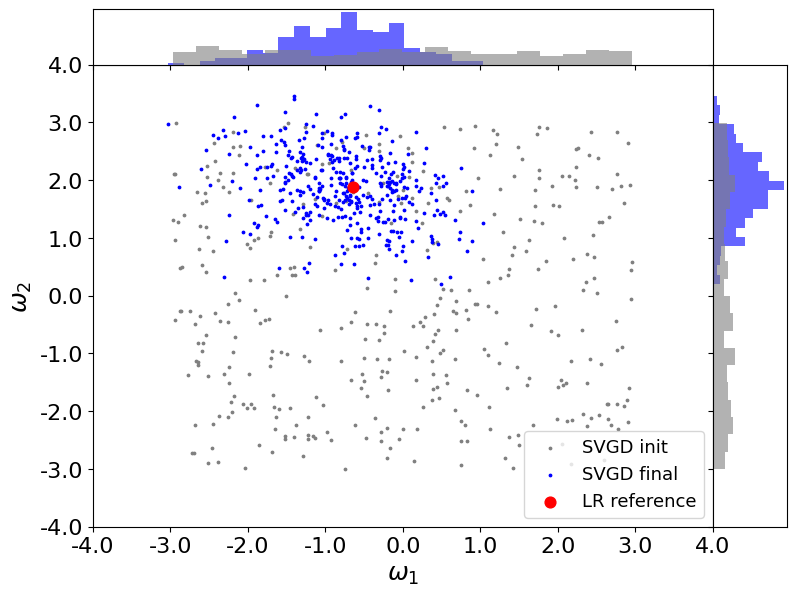

In [ ]:
SVGD_init_particles = np.load(wd+f'final results/BLR/BLR_SVGD.npz')['init_particles']
SVGD_final_particles = np.load(wd+f'final results/BLR/BLR_SVGD.npz')['final_particles'][0]
assess_results(init_particles=SVGD_init_particles, final_particles=SVGD_final_particles, method='SVGD')

print(f'final_mean: {np.mean(SVGD_final_particles, axis=0)}')

## EVI.

In [ ]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
import numpy.matlib as nm
from sklearn.preprocessing import scale
from scipy.special import expit
from sklearn.datasets import load_svmlight_file

class evi():

    def __init__(self):
        pass

    def rbf_kernel(self, theta, h=1):

        diff = theta[:, None, :] - theta[None, :, :]
        kxy = np.exp(-np.sum(diff ** 2, axis=-1) / (2 * h ** 2))
        sumkxy = np.sum(kxy, axis=1, keepdims=True)
        gradK = -diff * kxy[:, :, None] / h ** 2
        dxkxy = np.sum(gradK, axis=0)
        obj = np.sum(np.transpose(gradK, axes=[1,0,2]) / sumkxy, axis=1)

        return dxkxy, sumkxy, obj

    def gradient(self, x, x_initial, grad, tau, kernel='rbf', **kernel_params):
        assert x.shape == grad.shape, 'illegal inputs and grads'
        p_shape = np.shape(x)
        x = np.reshape(x, (np.shape(x)[0], -1))
        x_initial = np.reshape(x_initial, (np.shape(x_initial)[0], -1))
        grad = np.reshape(grad, (np.shape(grad)[0], -1))

        if kernel == 'rbf':
            dxkxy, sumkxy, obj = self.rbf_kernel(x, **kernel_params)

        Akxy = (x - x_initial) / tau + (- dxkxy / sumkxy - obj - grad)
        Akxy = np.reshape(Akxy, p_shape)

        return Akxy

    def evi_updates(self, x0, lnprob, inner_iteration, outer_iteration, tau, X_test, y_test, evaluation):
        particles = x0.copy()
        particles_initial = x0.copy()
        results = []
        N = particles.shape[0] * particles.shape[1]

        for i in range(outer_iteration):

            for j in range(inner_iteration):

                lnpgrad = lnprob(particles)
                updates_evi = self.gradient(particles, particles_initial, lnpgrad, tau, kernel='rbf')
                grad_now = np.reshape(updates_evi, (1, N))
                if np.sqrt(np.inner(grad_now, grad_now)) < 1e-8:
                    print(j)
                    break

                step_l = 1e-7
                # BB Step - length
                if j > 0:
                    y_k = grad_now - grad_old
                    s_k = np.reshape(particles, (1, N)) - np.reshape(particles_old, (1, N))
                    step_l = np.inner(s_k, s_k) / np.inner(s_k, y_k)

                grad_old = grad_now
                particles_old = particles
                particles = particles - step_l * updates_evi

            particles_initial = particles
            results.append(evaluation(particles, X_test, y_test))

        return np.asarray(results), particles


def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

class BayesianLR:
    def __init__(self, X, Y, alpha):
        self.X, self.Y = X, Y
        self.alpha = alpha
        self.N = X.shape[0]
        self.dim = X.shape[1]
        self.iter = 0

    def dlnprob(self, theta):
        Xs = self.X
        Ys = self.Y
        w = theta  # logistic weights
        coff = np.matmul(Xs, w.T)
        y_hat = expit(coff)
        diff = (Ys.reshape(-1, 1) - y_hat).T
        dw_data = np.matmul(diff, Xs)
        dw_prior = -w / self.alpha
        dw = dw_data + dw_prior  # re-scale
        return dw  # first order derivative

    def evaluation(self, theta, X_test, y_test):
        M, n_test = theta.shape[0], len(y_test)
        prob = np.zeros([n_test, M])
        for t in range(M):
            coff = np.dot(X_test, theta[t, :])
            prob[:, t] = expit(coff)

        prob = np.mean(prob, axis=1)
        acc = np.mean(prob > 0.5)
        prob = replaceZeroes(prob)
        llh = np.mean(np.log(prob))
        return [acc, llh]

# Load the data from the .npz file
Iris_data = np.load(wd+'final results/BLR/Iris_data.npz')

# Extract each array
X = Iris_data['X']
y = Iris_data['y']
X_train = Iris_data['X_train_scaled']
X_test = Iris_data['X_test_scaled']
y_train = Iris_data['y_train']
y_test = Iris_data['y_test']

D = X_train.shape[1]

# initialization
M = 400  # number of particles
alpha = 1.0
inner_iteration = 500000
outer_iteration = 500
n_iter = inner_iteration * outer_iteration
repeat = 1
results_EVI = np.zeros(shape=(repeat, outer_iteration, 2))
final_particles = np.zeros((repeat, M, D))

for rep in range(repeat):

    # theta0 = np.random.normal(0, np.sqrt(alpha), (M, D))
    theta0 = np.load(wd+'final results/BLR/x_neg_init.npy')
    # EVI
    model = BayesianLR(X_train, y_train, alpha)
    results, final_theta = evi().evi_updates(x0=theta0, lnprob=model.dlnprob, inner_iteration=inner_iteration, outer_iteration=outer_iteration,
                              tau=1e-3, X_test=X_test, y_test=y_test, evaluation=model.evaluation)
    results_EVI[rep, :, :] = results
    final_particles[rep, :, :] = final_theta

np.savez(wd+'plots/BLR_EVI', results_mean=np.mean(results_EVI, axis=0), results_var=np.std(results_EVI, axis=0), init_particles=theta0,
         final_particles=final_particles)

# it takes 19 seconds to finish 1e8 iterations.

9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
8
8
9
9
9
9
9
9
9
8
8
8
8
8
8
8
8
8
8
8
8
8
8
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


<ipython-input-195-5baff74843c8>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_xticklabels(ax_main.get_xticks(), fontsize=16)
<ipython-input-195-5baff74843c8>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_yticklabels(ax_main.get_yticks(), fontsize=16)


mmd2_value for final EVI:10.14289538769961
nll_value for final EVI:11.387736235051921
Accuracy on the test set (all samplles): 1.00
Accuracy on the test set (posterior mean): 1.00
final_mean: [-0.78263834  1.81295872 -1.63064817 -1.5648353 ]


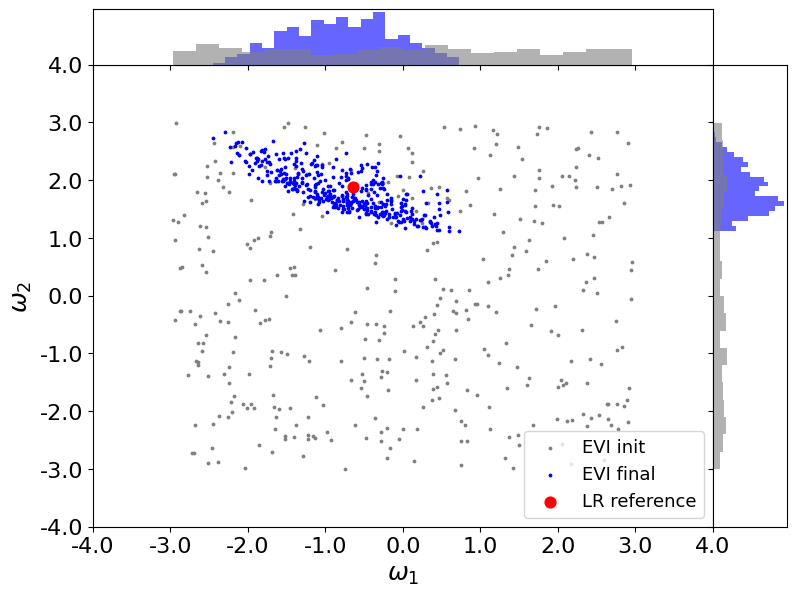

In [ ]:
EVI_init_particles = np.load(wd+f'final results/BLR/BLR_EVI.npz')['init_particles']
EVI_final_particles = np.load(wd+f'final results/BLR/BLR_EVI.npz')['final_particles'][0]
assess_results(init_particles=EVI_init_particles, final_particles=EVI_final_particles, method='EVI')

print(f'final_mean: {np.mean(EVI_final_particles, axis=0)}')

# Star-shaped.
computationally intensive - not run

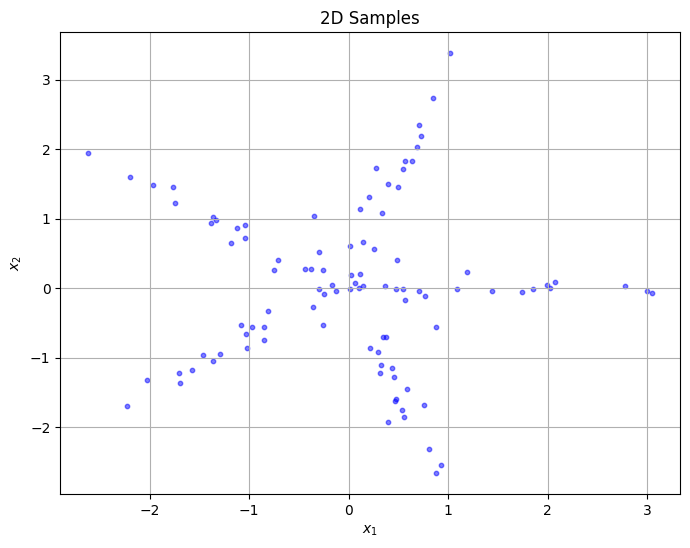

In [ ]:
from scipy.stats import multivariate_normal

np.random.seed(111)

class star_gaussian(object):
	def __init__(self, skewness, n):
		self.d = 2
		self.dimension = 2
		self.K = n
		theta = 2*np.pi/n
		U = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])

		self.mu = np.zeros([self.K, self.d])
		self.sigma = np.zeros([self.K, self.d, self.d])
		self.inv_sigma = np.zeros_like(self.sigma)

		self.mu[0,:] = 1.5 * np.array([1.,0.])
		self.sigma[0,:,:] = np.diag([1.,1./skewness])
		self.inv_sigma[0,:,:] = np.diag([1.,skewness])

		for i in range(1,n):
			self.mu[i,:] = np.matmul(U,self.mu[i-1,:])
			self.sigma[i,:,:] = np.matmul(U, np.matmul(self.sigma[i-1,:,:],U.T))
			self.inv_sigma[i,:,:] = np.matmul(U, np.matmul(self.inv_sigma[i-1,:,:],U.T))

		self.mean = np.mean(self.mu)
		self.x2 = self.mean * self.mean * self.K
		for i in range(self.K):
			self.x2 += np.diag(self.sigma[i,:,:])
		self.x2 /= self.K

	def sample(self, n_samples):
		n = int(n_samples/self.K)
		x = np.zeros([self.K * n, self.d])
		for k in range(self.K):
			x[k*n:(k+1)*n,:] = np.random.multivariate_normal(self.mu[k,:], self.sigma[k,:,:], n)
		np.random.shuffle(x)
		return x

	def logp(self, x):
		if x.ndim == 1:
			x = x.reshape(1, -1)  # Reshape to (1, d) if x is 1D
		n,d = x.shape
		Fx = np.zeros(n)
		for k in range(self.K):
			pdfi = multivariate_normal.pdf(x, mean = self.mu[k,:], cov = self.sigma[k,:,:])
			Fx += pdfi
		return np.log(Fx / self.K)

	def grad_log_p(self, x):
		n = x.shape[0]
		Fx = np.zeros(n)
		Jx = np.zeros_like(x)
		for k in range(self.K):
			pdfi = multivariate_normal.pdf(x, mean = self.mu[k,:], cov = self.sigma[k,:,:]) + 1e-20
			Fx += pdfi
			Jx += pdfi[:, None] * np.matmul(self.mu[k,:] - x, self.inv_sigma[k,:,:])
		return Jx/Fx[:, None]

	def Hessian_log_p(self, x):
		n, d = x.shape
		Fx = np.zeros(n)
		Hx = np.zeros([n,d,d])
		for k in range(self.K):
			pdfi = multivariate_normal.pdf(x, mean = self.mu[k,:], cov = self.sigma[k,:,:]) + 1e-20
			Fx += pdfi
			Hx += pdfi[:, None, None] * self.inv_sigma[k,:,:]
		return Hx/Fx[:, None, None]

	def inv_avg_Hessian(self, Q):
		return np.linalg.inv(Q)

star_samples = star_gaussian(100, 5).sample(100)
plt.figure(figsize=(8, 6))
plt.scatter(star_samples[:, 0], star_samples[:, 1], alpha=0.5, s=10, c='blue')
plt.title('2D Samples')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.show()

## E-ParVI.

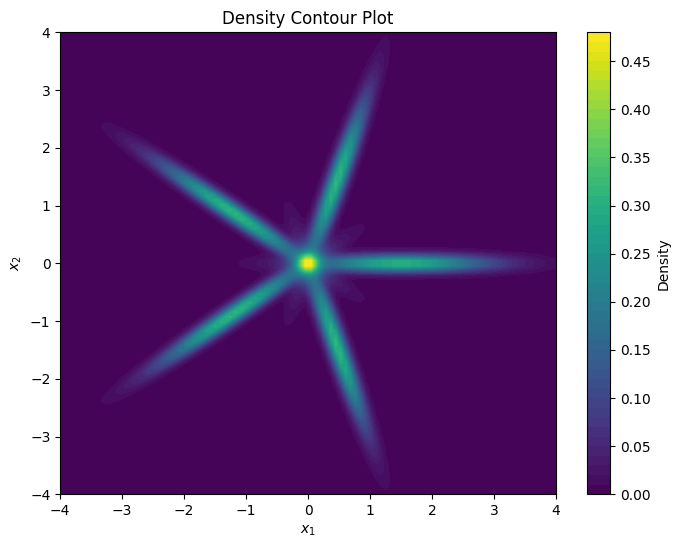

In [ ]:
skewness = 100
n = 5

d = 2
K = n
theta = 2*np.pi/n
U = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])

mu = np.zeros([K, 2])
sigma = np.zeros([K, d, d])
inv_sigma = np.zeros_like(sigma)

mu[0,:] = 1.5 * np.array([1.,0.])
sigma[0,:,:] = np.diag([1.,1./skewness])
inv_sigma[0,:,:] = np.diag([1.,skewness])

for i in range(1,n):
  mu[i,:] = np.matmul(U, mu[i-1,:])
  sigma[i,:,:] = np.matmul(U, np.matmul(sigma[i-1,:,:],U.T))

def target_p(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)  # Reshape to (1, d) if x is 1D
    n, d = x.shape
    Fx = np.zeros(n)
    for k in range(K):
        pdfi = multivariate_normal.pdf(x, mean = mu[k,:], cov = sigma[k,:,:])
        Fx += pdfi
    return Fx / K
target_p(np.array([1,2]))

# Create a grid
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.column_stack([X.ravel(), Y.ravel()])

# Evaluate the density over the grid
Z = target_p(grid_points).reshape(X.shape)

# Plotting the density
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Density')
plt.title('Density Contour Plot')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

q_pos: 1.0
step: 0
no. of negative charges currently contained within the square [-4,4] (particle_filtering:False): 400


KeyboardInterrupt: 

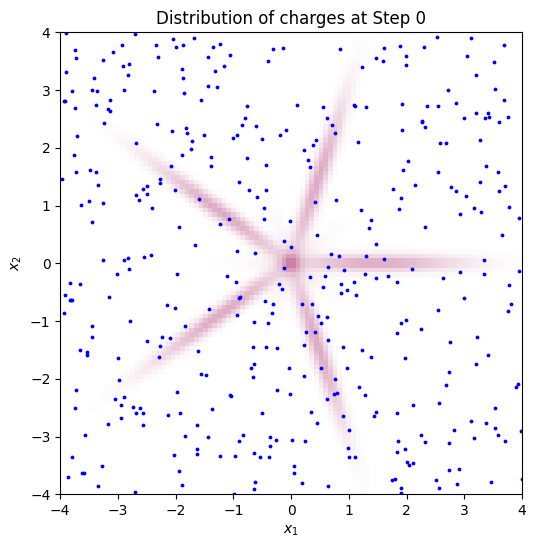

In [ ]:
np.random.seed(111)

def target_p(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)  # reshape to (1, d) if x is 1D
    n, d = x.shape
    Fx = np.zeros(n)
    for k in range(K):
        pdfi = multivariate_normal.pdf(x, mean = mu[k,:], cov = sigma[k,:,:])
        Fx += pdfi
    return Fx / K

update_rule = 'Euler'
params_dict = set_params(update_rule,{'M_pos':100**2,
                                      'q_pos': 1.0,
                                      'q_pos_auto_annealing': False,
                                      'normalize_overall_forces': True,
                                      'normalise_attr_forces': False,
                                      'particle_filtering': False,
                                      'noise_std':0})
init_dict = {'init_type':'uniform', 'low_uniform':-4, 'high_uniform':4, 'low_xy': -4, 'high_xy': 4, 'margin':0}

start_time = time.time()
# Initialize positions with a seed for reproducibility
x_neg, x_pos = initialize_positions(target_p=target_p,
                                    M_neg=params_dict['M_neg'],
                                    M_pos=params_dict['M_pos'],
                                    d=params_dict['d'],
                                    init_dict=init_dict,
                                    SEED=params_dict['SEED'])
# Egenerate 5000 ground truth samples
samples = star_gaussian(skewness, n).sample(5000)
# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    target_p=target_p,
    ground_truth_samples=samples)
end_time = time.time(); total_time = end_time - start_time; print(f'total run time: {total_time} seconds')

# plot trajectories for selected particles
selected_indices = [0,100,200,299]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                target_p=target_p,
                x_pos=x_pos,
                low_xy=init_dict['low_xy'],
                high_xy=init_dict['high_xy'],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# save results
results_dict = {'update_rule':update_rule,
                'params_dict':params_dict,
                'init_dict':init_dict,
                'init_x_neg':x_neg,
                'init_x_pos':x_pos,
                'x_neg_final':x_neg_final,
                'all_trajectories':all_trajectories,
                'particle_counts_vec': particle_counts_vec,
                'selected_indices':selected_indices,
                'total_time':total_time,
                'step_time_vec':step_time_vec,
                'MMD2_vec':MMD2_vec,
                'NLL_vec':NLL_vec}
# saving the dictionary
with open(wd+'plots/results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

## Langevin.

In [ ]:
def sample_langevin(n, model, max_iter = 10000, a = 0.01, b = 1, c = 0.55):
	d = model.dimension
	x = np.zeros([n, d])
	for t in range(max_iter):
		epsilon = a*np.exp(np.log(b+t) *(- c))
		x += epsilon * model.grad_log_p(x)
		x += 2 * np.sqrt(epsilon) * np.random.randn(n,d)
	# plt.scatter(x[:,0], x[:,1])
	return x

sample_langevin(n=100, model=star_gaussian(100, 5))

## SVGD.

In [ ]:
from scipy.spatial.distance import pdist, squareform


class SVGD():

    def __init__(self):
        pass

    def svgd_kernel(self, theta, h=-1):


        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist) ** 2
        if h < 0:  # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0] + 1))

        # compute the rbf kernel
        Kxy = np.exp(-pairwise_dists / h ** 2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:, i] + np.multiply(theta[:, i], sumkxy)
        dxkxy = dxkxy / (h ** 2)

        return (Kxy, dxkxy)

    def svgd_updates(self, x0, lnprob, inner_iteration, outer_iteration, stepsize, X_test, y_test, evaluation, debug=False):

        n_iter = inner_iteration * outer_iteration

        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta = np.copy(x0)
        adag = np.zeros(theta.shape)
        results = []
        # results.append(evaluation(theta, X_test, y_test))

        for iter in range(n_iter):
            if debug and (iter + 1) % 1000 == 0:
                print
                'iter ' + str(iter + 1)

            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]
            adag += grad_theta ** 2  # update sum of gradient's square
            theta = theta + stepsize * grad_theta / np.sqrt(adag + 1e-12)
            if (iter+1) % inner_iteration == 0:

                 results.append(evaluation(theta, X_test, y_test))

        return np.asarray(results)

## EVI.

In [ ]:
class evi():

    def __init__(self):
        pass

    def rbf_kernel(self, theta, h=0.05):

        diff = theta[:, None, :] - theta[None, :, :]
        kxy = np.exp(-np.sum(diff ** 2, axis=-1) / (2 * h ** 2))
        sumkxy = np.sum(kxy, axis=1, keepdims=True)
        gradK = -diff * kxy[:, :, None] / h ** 2
        dxkxy = np.sum(gradK, axis=0)
        obj = np.sum(np.transpose(gradK, axes=[1, 0, 2]) / sumkxy, axis=1)

        return dxkxy, sumkxy, obj

    def gradient(self, x, x_initial, grad, tau, kernel='rbf', **kernel_params):
        assert x.shape == grad.shape, 'illegal inputs and grads'
        p_shape = np.shape(x)
        x = np.reshape(x, (np.shape(x)[0], -1))
        x_initial = np.reshape(x_initial, (np.shape(x_initial)[0], -1))
        grad = np.reshape(grad, (np.shape(grad)[0], -1))

        if kernel == 'rbf':
            dxkxy, sumkxy, obj = self.rbf_kernel(x, **kernel_params)

        Akxy = (x - x_initial) / tau + (- dxkxy / sumkxy - obj - grad)
        Akxy = np.reshape(Akxy, p_shape)

        return Akxy

    def evi_updates(self, x0, lnprob, inner_iteration, outer_iteration, tau, X_test, y_test, evaluation):
        particles = x0.copy()
        particles_initial = x0.copy()
        results = []
        N = particles.shape[0] * particles.shape[1]
        lr = .1

        for i in range(outer_iteration):
            adag = np.zeros(particles.shape)

            for j in range(inner_iteration):

                lnpgrad = lnprob(particles)
                updates_evi = self.gradient(particles, particles_initial, lnpgrad, tau, kernel='rbf')

                '''
                grad_now = np.reshape(updates_evi, (1, N))
                if np.sqrt(np.inner(grad_now, grad_now)) < 1e-8:
                    print(j)
                    break

                step_l = 1e-7
                # BB Step - length
                if j > 0:
                    y_k = grad_now - grad_old
                    s_k = np.reshape(particles, (1, N)) - np.reshape(particles_old, (1, N))
                    step_l = np.inner(s_k, s_k) / np.inner(s_k, y_k)

                grad_old = grad_now
                particles_old = particles
                particles = particles - step_l * updates_evi
                '''

                adag += updates_evi ** 2  # update sum of gradient's square
                particles = particles - lr * updates_evi / np.sqrt(adag + 1e-12)

            particles_initial = particles
            results.append(evaluation(particles, X_test, y_test))

        return np.asarray(results)

## EVI train.

In [ ]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
import numpy.matlib as nm
from svgd import SVGD
from evi import evi
from sklearn.preprocessing import scale
from scipy.special import expit
from sklearn.datasets import load_svmlight_file

def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data


class BayesianLR:
    def __init__(self, X, Y, batchsize, alpha):
        self.X, self.Y = X, Y
        self.batchsize = min(batchsize, X.shape[0])

        self.N = X.shape[0]
        self.dim = X.shape[1]
        self.permutation = np.random.permutation(self.N)
        self.iter = 0
        self.alpha = alpha

    def dlnprob(self, theta):

        if self.batchsize > 0:
            batch = [i % self.N for i in range(self.iter * self.batchsize, (self.iter + 1) * self.batchsize)]
            ridx = self.permutation[batch]
            self.iter += 1
        else:
            ridx = np.random.permutation(self.X.shape[0])

        Xs = self.X[ridx, :]
        Ys = self.Y[ridx]

        w = theta  # logistic weights
        coff = np.matmul(Xs, w.T)
        y_hat = expit(coff)
        diff = ((nm.repmat(np.vstack(Ys), 1, theta.shape[0]) + 1) / 2.0 - y_hat).T  # change from {-1,1} to {0,1}
        dw_data = np.matmul(diff, Xs)
        dw_prior = -w/self.alpha
        dw = dw_data * self.X.shape[0] / Xs.shape[0] + dw_prior  # re-scale

        '''
        grad_loglik_W = np.expand_dims(diff, 2) * np.expand_dims(Xs, 0)
        mean_dW = np.mean(grad_loglik_W, axis=1, keepdims=True)
        diff_dW = grad_loglik_W - mean_dW
        cov_dW = np.matmul(np.transpose(diff_dW, axes=[0, 2, 1]), diff_dW) / self.batchsize
        # H_inv = np.linalg.inv(cov_dW + 1e-2 * np.expand_dims(np.eye(self.dim), 0))
        '''
        return dw  # first order derivative


    def evaluation(self, theta, X_test, y_test):

        M, n_test = theta.shape[0], len(y_test)
        prob = np.zeros([n_test, M])
        for t in range(M):
            coff = np.multiply(y_test, np.sum(-1 * np.multiply(nm.repmat(theta[t, :], n_test, 1), X_test), axis=1))
            prob[:, t] = expit(-coff)

        prob = np.mean(prob, axis=1)
        acc = np.mean(prob > 0.5)
        prob = replaceZeroes(prob)
        llh = np.mean(np.log(prob))
        return [acc, llh]


if __name__ == '__main__':

    # covertype
    data = scipy.io.loadmat('covertype.mat')
    X_input = scale(data['covtype'][:, 1:])
    # X_input = data['covtype'][:, 1:]
    y_input = data['covtype'][:, 0]
    y_input[y_input == 2] = -1

    N = X_input.shape[0]
    # X_input = np.hstack([X_input, np.ones([N, 1])])
    d = X_input.shape[1]
    D = d

    # initialization
    M = 20  # number of particles
    alpha = 1
    inner_iteration = 100
    outer_iteration = 20
    n_iter = inner_iteration * outer_iteration
    repeat = 20
    results_EVI = np.zeros(shape=(repeat, outer_iteration, 2))


    for rep in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2)

        theta0 = np.random.normal(0, np.sqrt(alpha), (M, D))
        # EVI
        model = BayesianLR(X_train, y_train, 256, alpha)  # batchsize = 32
        results_EVI[rep, :, :] = evi().evi_updates(x0=theta0, lnprob=model.dlnprob, inner_iteration=inner_iteration, outer_iteration=outer_iteration,
                                  tau=1e-1, X_test=X_test, y_test=y_test, evaluation=model.evaluation)
        print('one trial ends')


    np.savez('lr_evi', results_mean=np.mean(results_EVI, axis=0), results_var=np.std(results_EVI, axis=0))

# LV system.

In [ ]:
# a = alpha
# b = beta
# c = delta
# d = gamma
# X: hare
# Y: lynx

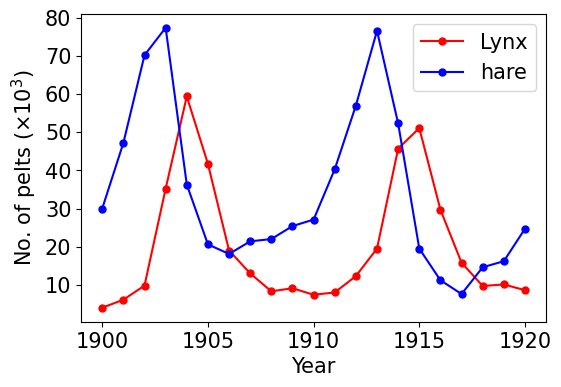

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

years = np.array([1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920])
lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4, 8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
# dataset credit given to: 'https://github.com/stan-dev/example-models/blob/master/knitr/lotka-volterra/hudson-bay-lynx-hare.csv'

plt.figure(figsize=(6,4))
plt.plot(years,lynx,'.-',markersize=10,color='red',label='Lynx')
plt.plot(years,hare,'.-',markersize=10,color='blue',label='hare')
plt.xticks([1900,1905,1910,1915,1920],fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('Year',fontsize=15); plt.ylabel(r'No. of pelts ($\times 10^3$)',fontsize=15)
plt.legend(fontsize=15)

the LV dynamics. \\
X: hare \\
Y: lynx. \\

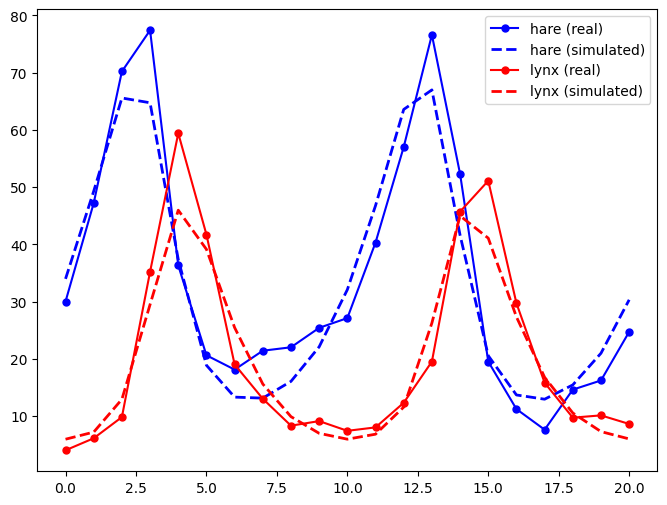

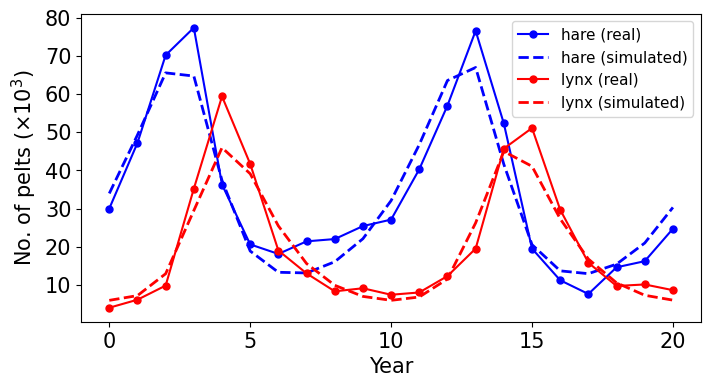

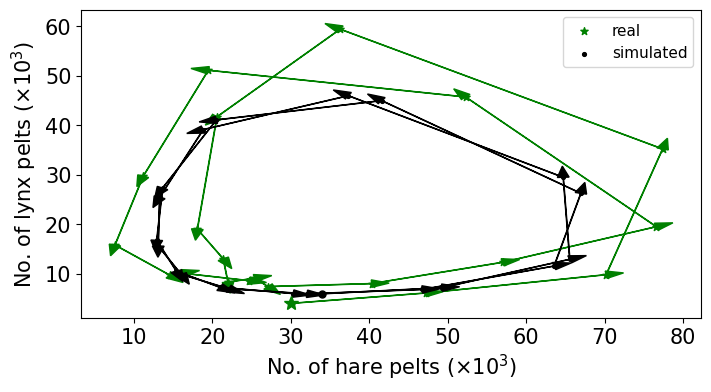

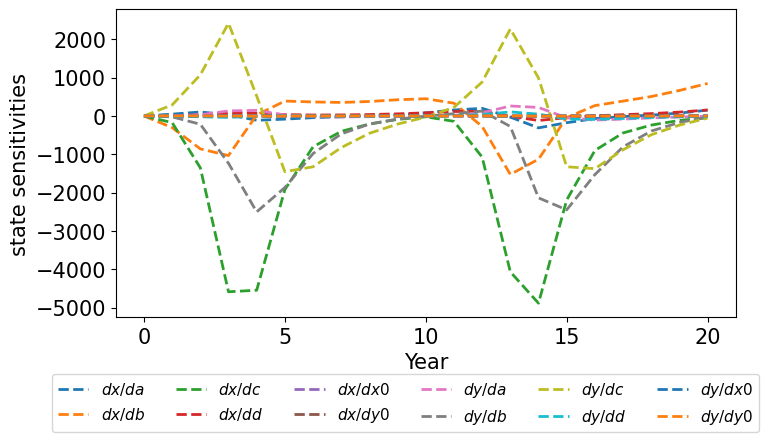

In [ ]:
from scipy.integrate import odeint

n_states = 2
n_odeparams = 4
n_ivs = 2

class LotkaVolterraModel:
    def __init__(self, n_states, n_odeparams, n_ivs, y0=None):
        self._n_states = n_states
        self._n_odeparams = n_odeparams
        self._n_ivs = n_ivs
        self._y0 = y0

    def simulate(self, parameters, times):
        return self._simulate(parameters, times, False)

    def simulate_with_sensitivities(self, parameters, times):
        return self._simulate(parameters, times, True)

    def _simulate(self, parameters, times, sensitivities):
        alpha, beta, gamma, delta, Xt0, Yt0 = [x for x in parameters]

        def r(y, t, p):
            X, Y = y
            dX_dt = alpha * X - beta * X * Y
            dY_dt = -gamma * Y + delta * X * Y
            return dX_dt, dY_dt

        if sensitivities:

            def jac(y):
                X, Y = y
                ret = np.zeros((self._n_states, self._n_states))
                ret[0, 0] = alpha - beta * Y
                ret[0, 1] = -beta * X
                ret[1, 0] = delta * Y
                ret[1, 1] = -gamma + delta * X
                return ret

            def dfdp(y):
                X, Y = y
                ret = np.zeros(
                    (self._n_states, self._n_odeparams + self._n_ivs)
                )  # except the following entries
                ret[
                    0, 0
                ] = X  # \frac{\partial  [\alpha X - \beta XY]}{\partial \alpha}, and so on...
                ret[0, 1] = -X * Y
                ret[1, 2] = -Y
                ret[1, 3] = X * Y

                return ret

            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0 : self._n_states]
                dydp = y_and_dydp[self._n_states :].reshape(
                    (self._n_states, self._n_odeparams + self._n_ivs)
                )
                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac(y), dydp) + dfdp(y)
                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))

            y0 = np.zeros((2 * (n_odeparams + n_ivs)) + n_states)
            y0[6] = 1.0  # \frac{\partial  [X]}{\partial Xt0} at t==0, and same below for Y
            y0[13] = 1.0
            y0[0:n_states] = [Xt0, Yt0]
            result = odeint(rhs, y0, times, (parameters,), rtol=1e-6, atol=1e-5)
            values = result[:, 0 : self._n_states]
            dvalues_dp = result[:, self._n_states :].reshape(
                (len(times), self._n_states, self._n_odeparams + self._n_ivs)
            )
            return values, dvalues_dp
        else:
            values = odeint(r, [Xt0, Yt0], times, (parameters,), rtol=1e-6, atol=1e-5)
            return values

ode_model = LotkaVolterraModel(n_states, n_odeparams, n_ivs)

# abcd=(0.55,0.028,0.024,0.80), x_0=33.956, y_0=5.933
tspan = np.arange(0,len(years),1)

# a = alpha
# b = beta
# c = delta
# d = gamma

### simulate without sensitivities ###
xy_vec = ode_model.simulate(parameters=(0.55,0.028,0.80,0.024,33.956,5.933), times=tspan) # parameters = [alpha, beta, gamma, delta, Xt0, Yt0]
x_vec = [xx[0] for xx in xy_vec]
y_vec = [xx[1] for xx in xy_vec]

plt.figure(figsize=(8,6))
plt.plot(np.arange(0,len(hare), 1), hare, '.-', markersize=10, color='blue', label='hare (real)')
plt.plot(tspan, x_vec, '--', linewidth=2, color='blue', label='hare (simulated)')
plt.plot(np.arange(0,len(lynx), 1), lynx, '.-', markersize=10, color='red', label='lynx (real)')
plt.plot(tspan, y_vec, '--', linewidth=2, color='red', label='lynx (simulated)')
plt.legend()

### simulate with sensitivities ###
xy_vec, dxy_dp = ode_model.simulate_with_sensitivities(parameters=(0.55,0.028,0.80,0.024,33.956,5.933), times=tspan)
xy_vec.shape
dxy_dp.shape
x_vec = [xx[0] for xx in xy_vec]
y_vec = [xx[1] for xx in xy_vec]
dxda_vec = [xx[0,0] for xx in dxy_dp]
dxdb_vec = [xx[0,1] for xx in dxy_dp]
dxdd_vec = [xx[0,2] for xx in dxy_dp]
dxdc_vec = [xx[0,3] for xx in dxy_dp]
dxdx0_vec = [xx[0,4] for xx in dxy_dp]
dxdy0_vec = [xx[0,5] for xx in dxy_dp]
dyda_vec = [xx[1,0] for xx in dxy_dp]
dydb_vec = [xx[1,1] for xx in dxy_dp]
dydd_vec = [xx[1,2] for xx in dxy_dp]
dydc_vec = [xx[1,3] for xx in dxy_dp]
dydx0_vec = [xx[1,4] for xx in dxy_dp]
dydy0_vec = [xx[1,5] for xx in dxy_dp]

plt.figure(figsize=(8,4))
plt.plot(np.arange(0,len(hare), 1), hare, '.-', markersize=10, color='blue', label='hare (real)')
plt.plot(tspan, x_vec, '--', linewidth=2, color='blue', label='hare (simulated)')
plt.plot(np.arange(0,len(lynx), 1), lynx, '.-', markersize=10, color='red', label='lynx (real)')
plt.plot(tspan, y_vec, '--', linewidth=2, color='red', label='lynx (simulated)')
plt.xticks([0,5,10,15,20],fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('Year',fontsize=15); plt.ylabel(r'No. of pelts ($\times 10^3$)',fontsize=15)
plt.legend(fontsize=11)

plt.figure(figsize=(8,4))
plt.scatter(hare,lynx,marker='*',s=30,color='green', label='real')
plt.plot(hare[0],lynx[0], '*', markersize=10, color='green') # starting point
for i in range(len(years)-1):
  plt.arrow(x=hare[i],y=lynx[i],dx=hare[i+1]-hare[i],dy=lynx[i+1]-lynx[i], color='green', head_width =1.5, width =0.05)
plt.scatter(x_vec,y_vec,marker='.',s=30,color='black', label='simulated')
plt.plot(x_vec[0],y_vec[0], '.', markersize=10, color='black') # starting point
for i in range(len(years)-1):
  plt.arrow(x=x_vec[i],y=y_vec[i],dx=x_vec[i+1]-x_vec[i],dy=y_vec[i+1]-y_vec[i], color='black', head_width =1.5, width =0.05)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel(r'No. of hare pelts ($\times 10^3$)',fontsize=15); plt.ylabel(r'No. of lynx pelts ($\times 10^3$)',fontsize=15)
plt.legend(fontsize=11)

plt.figure(figsize=(8,4))
plt.xticks([0,5,10,15,20],fontsize=15);plt.yticks(fontsize=15)
plt.plot(tspan, dxda_vec,  '--', linewidth=2, label=r'$dx/da$')
plt.plot(tspan, dxdb_vec,  '--', linewidth=2, label=r'$dx/db$')
plt.plot(tspan, dxdc_vec,  '--', linewidth=2, label=r'$dx/dc$')
plt.plot(tspan, dxdd_vec,  '--', linewidth=2, label=r'$dx/dd$')
plt.plot(tspan, dxdx0_vec,  '--', linewidth=2, label=r'$dx/dx0$')
plt.plot(tspan, dxdy0_vec,  '--', linewidth=2, label=r'$dx/dy0$')
plt.plot(tspan, dyda_vec,  '--', linewidth=2, label=r'$dy/da$')
plt.plot(tspan, dydb_vec,  '--', linewidth=2, label=r'$dy/db$')
plt.plot(tspan, dydc_vec,  '--', linewidth=2, label=r'$dy/dc$')
plt.plot(tspan, dydd_vec,  '--', linewidth=2, label=r'$dy/dd$')
plt.plot(tspan, dydx0_vec,  '--', linewidth=2, label=r'$dy/dx0$')
plt.plot(tspan, dydy0_vec,  '--', linewidth=2, label=r'$dy/dy0$')
plt.xlabel('Year',fontsize=15)
plt.ylabel(r'state sensitivities',fontsize=15)
plt.legend(bbox_to_anchor=(1.05, -0.16), ncol=6, fontsize=11)

## HMC.

In [ ]:
!pip install numpy==1.19.5
!pip install theano-pymc
!pip install pymc3==3.11.5
!pip install arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 20.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: Could not build wheels for numpy, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529960 sha256=58a580ed8daee328f553e9d8ea44cd8e42d0cae340cf239c0e6541c3f595cab1
  Stored in directory: /root/.cache/pip/wheels/c2/da/87/4e3e2d14772741721d4ebe739c16bcf10ca3c6

In [ ]:
import os

os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'blas__check_openmp=False,optimizer=None'

# Import the necessary libraries
import numpy as np
import scipy
import pymc3 as pm
import theano
import arviz as az

# Print versions to verify
print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)
print("PyMC3 version:", pm.__version__)
print("Theano version:", theano.__version__)
print("ArviZ version:", az.__version__)

NumPy version: 1.22.1
SciPy version: 1.7.3
PyMC3 version: 3.11.5
Theano version: 1.1.2
ArviZ version: 0.12.1


with known x0, y0, noiseSigma.

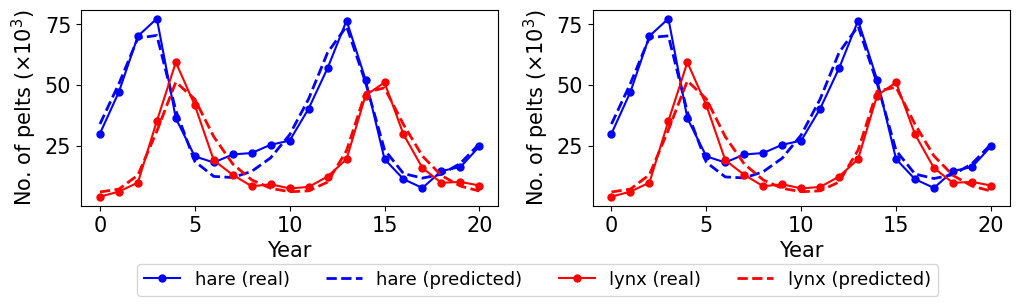

In [ ]:
# %env MKL_THREADING_LAYER=GNU
import numpy as np

SEED = 111
import random; random.seed(SEED)

class ODEGradop(theano.tensor.Op): # only requires numpy_vsp()
    def __init__(self, numpy_vsp):
        self._numpy_vsp = numpy_vsp # numpy_vsp() takes x and g as input arguments. x = current state + param values

    def make_node(self, x, g):
        x = theano.tensor.as_tensor_variable(x)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.tensor.Apply(self, [x, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        g = inputs_storage[1]
        out = output_storage[0]
        out[0] = self._numpy_vsp(x, g)  # get the numerical VSP

class ODEop(theano.tensor.Op):
    def __init__(self, state, numpy_vsp): # needs state() and numpy_vsp(), sensitivity_or_not
        self._state = state
        self._numpy_vsp = numpy_vsp

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)
        return theano.tensor.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        out[0] = self._state(x)  # get the numerical solution of ODE states, the output of state(x) has been reshaped into a vector in the state() function

    def grad(self, inputs, output_grads):
        x = inputs[0]
        g = output_grads[0] # g is dlop/dstate

        grad_op = ODEGradop(self._numpy_vsp)  # pass the VSP when asked for gradient
        grad_op_apply = grad_op(x, g)

        return [grad_op_apply] # a vector

times = np.arange(0, 21)  # number of measurement points (see below)

# the same simulation has run twice using the same set of parameter values - an alternative way of doing this is to run it once and cached the results
def state(x): # x: parameters, x = current state + param values
    State = ode_model.simulate(x, times)
    return State.reshape((n_states * len(State),)) # flatten all state trajectories, convert State into a vector

# State shape: (len(times), n_states)
# Sens shape: ((len(times), self._n_states, self._n_odeparams + self._n_ivs))

def numpy_vsp(x, g): # g is dlop/dstate
    State, Sens = ode_model.simulate_with_sensitivities(x, times)
    numpy_sens = Sens.reshape((n_states * len(times), len(x))) # convert numpy_sens into a 2D matrix
    return numpy_sens.T.dot(g) # the output is a vector


# Define the data matrix
Y = np.vstack((hare, lynx)).T

# Now instantiate the theano custom ODE op
my_ODEop = ODEop(state, numpy_vsp)

# the probabilistic model
with pm.Model() as pm_LV_model:

    # uniform priors
    min_a=0.001; max_a=1.0
    min_b=0.001; max_b=0.05
    min_c=0.001; max_c=0.05
    min_d=0.001; max_d=1.0
    alpha = pm.Uniform("ɑ", lower=min_a, upper=max_a) #a
    beta = pm.Uniform("β", lower=min_b, upper=max_b) #b
    gamma = pm.Uniform("γ", lower=min_d, upper=max_d) #d
    delta = pm.Uniform("δ", lower=min_c, upper=max_c) #c
    x0 = 33.956
    y0 = 5.933
    sigma = np.exp(0.25)

    # Forward model
    all_params = pm.math.stack([alpha, beta, gamma, delta, x0, y0], axis=0)
    ode_sol = my_ODEop(all_params)
    sol = ode_sol.reshape(Y.shape)

    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=sol, sigma=sigma, observed=Y) # type(Y_obs): pymc3.model.ObservedRV

    #sampling: <trace20 corresponds to normal.log-normal priors
    random.seed(SEED)
    trace = pm.sample(400, tune=1500, init='jitter+adapt_diag', step=pm.NUTS(target_accept=0.8), cores=1, chains=2, discard_tuned_samples=True, random_seed=111)

trace["diverging"].sum()

import pickle
with open(wd+'pm_LV_model_uniformPriors_dict', 'wb') as buff:
    pickle.dump({'model': pm_LV_model, 'trace': trace}, buff)

# save the trace as a NumPy array
trace_arr = np.array([trace[varname] for varname in trace.varnames])
np.save(wd+'trace_uniformPriors.npy', trace_arr)

# save the trace as a dictionary
trace_dict = {varname: trace.get_values(varname) for varname in trace.varnames}
with open(wd+'trace_uniformPriors_dict.pkl', 'wb') as f:
    pickle.dump(trace_dict, f)

with open(wd+'pm_LV_model_uniformPriors.pkl', 'wb') as f:
    pickle.dump(pm_LV_model, f)
pm.save_trace(trace, wd+'LV.trace_uniformPriors', overwrite=True)
# with pm_LV_model:
#     trace = pm.load_trace(wd+'LV.trace (single sigma, Normal and LogNormal priors)')

### ad-hoc analysis
pm.traceplot(trace, compact=False); plt.tight_layout(pad=0)
# pm.plot_trace(trace, compact=False); plt.tight_layout(pad=0)
# pm.traceplot(trace, lines={'ɑ':0.55, 'β':0.028, 'δ':0.024, 'γ':0.80, 'x0':33.96, 'y0':5.93, 'σ':0.5}, compact=False); plt.tight_layout(pad=0)
# with pm_LV_model:
#     az.plot_trace(trace, compact=False); plt.tight_layout(pad=0)

summary = az.summary(trace)
STAN_mus = [0.549, 0.028, 0.797, 0.024] #ɑ/a, β/b, γ/d, δ/c, x0, y0, σ
STAN_sds = [0.065, 0.004, 0.091, 0.004] #ɑ/a, β/b, γ/d, δ/c, x0, y0, σ
summary["STAN_mus"] = pd.Series(np.array(STAN_mus), index=summary.index)
summary["STAN_sds"] = pd.Series(np.array(STAN_sds), index=summary.index)
summary

# focus on trace 1
trace_chain0_dict = {var:trace.get_values(var, chains=1) for var in trace.varnames}
with open(wd+'HMC_chain0_uniformPriors.pkl', 'wb') as f:
    pickle.dump(trace_chain0_dict, f)
import seaborn as sns
ground_truth_vals = {'ɑ':0.55, 'β':0.028, 'δ':0.024, 'γ':0.80, 'x0':33.96, 'y0':5.93, 'σ':0.25}
VarNames_dict = {'ɑ':"a",  'β':"b", 'δ':"c", 'γ':"d", 'x0':'x0', 'y0':'y0', 'σ':'σ'}
posterior_mean_vec = []
posterior_MAP_vec = []
for varname in trace_chain0_dict.keys():
  if varname in ["ɑ","β","γ","δ","x0","y0","σ"]:
    trace_arr = trace_chain0_dict[varname]
    len(trace_arr)
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)

    plt.hist(trace_arr, density=True, color='lightgray', bins=15)
    ax = sns.kdeplot(np.array(trace_arr).flatten(), color='black')
    xs_kde = ax.lines[0].get_xdata()
    ys_kde = ax.lines[0].get_ydata()
    posterior_MAP = xs_kde[np.argmax(ys_kde)]; posterior_MAP_vec.append(posterior_MAP)
    posterior_mean = np.mean(trace_arr); posterior_mean_vec.append(posterior_mean)
    plt.axvline(x=ground_truth_vals[varname], color='r', linestyle='--')
    plt.title(f"{VarNames_dict[varname]}")

    # plot the trace for sigma
    plt.subplot(1, 2, 2)
    plt.plot(trace_arr, color='gray')

    plt.tight_layout()
    plt.show()

fig, axs = plt.subplots(1,2, figsize=(10,3))
# fig.suptitle('Posterior predictive (left: posterior MAP, right: posterior mean)')
xy_vec = ode_model.simulate(parameters=np.concatenate([[posterior_MAP_vec[xx] for xx in [0,1,2,3]],[33.956,5.933]]), times=tspan) # parameters = [alpha, beta, gamma, delta, Xt0, Yt0]
x_vec = [xx[0] for xx in xy_vec]
y_vec = [xx[1] for xx in xy_vec]
axs[0].plot(np.arange(0,len(hare), 1), hare, '.-', markersize=10, color='blue', label='hare (real)')
axs[0].plot(tspan, x_vec, '--', linewidth=2, color='blue', label='hare (predicted)')
axs[0].plot(np.arange(0,len(lynx), 1), lynx, '.-', markersize=10, color='red', label='lynx (real)')
axs[0].plot(tspan, y_vec, '--', linewidth=2, color='red', label='lynx (predicted)')
axs[0].set_xticks([0,5,10,15,20]);
axs[0].xaxis.set_tick_params(labelsize=15); axs[0].yaxis.set_tick_params(labelsize=15)
axs[0].set_xlabel('Year',fontsize=15); axs[0].set_ylabel(r'No. of pelts ($\times 10^3$)',fontsize=15)

xy_vec = ode_model.simulate(parameters=np.concatenate([[posterior_mean_vec[xx] for xx in [0,1,2,3]],[33.956,5.933]]), times=tspan) # parameters = [alpha, beta, gamma, delta, Xt0, Yt0]
x_vec = [xx[0] for xx in xy_vec]
y_vec = [xx[1] for xx in xy_vec]
axs[1].plot(np.arange(0,len(hare), 1), hare, '.-', markersize=10, color='blue', label='hare (real)')
axs[1].plot(tspan, x_vec, '--', linewidth=2, color='blue', label='hare (predicted)')
axs[1].plot(np.arange(0,len(lynx), 1), lynx, '.-', markersize=10, color='red', label='lynx (real)')
axs[1].plot(tspan, y_vec, '--', linewidth=2, color='red', label='lynx (predicted)')
axs[1].set_xticks([0,5,10,15,20]);
axs[1].xaxis.set_tick_params(labelsize=15); axs[1].yaxis.set_tick_params(labelsize=15)
axs[1].set_xlabel('Year',fontsize=15); axs[1].set_ylabel(r'No. of pelts ($\times 10^3$)',fontsize=15)

axs[1].legend(bbox_to_anchor=(0.85,-0.25), ncol=4, fontsize=13)

plt.tight_layout(pad=0, w_pad=-30, h_pad=1)

## LMC.

In [ ]:
# Constants and global variables
min_a = 0.001
min_b = 0.001
min_c = 0.001
min_d = 0.001
max_a = 1.0
max_b = 0.05
max_c = 0.05
max_d = 1.0
sigma = 0.25

# Data (assuming hare and lynx are defined elsewhere)
X_prime = hare.copy()
Y_prime = lynx.copy()

def target_p(theta):
    global X_prime, Y_prime
    a, b, c, d = theta

    global min_a, min_b, min_c, min_d, max_a, max_b, max_c, max_d, sigma

    xy_vec = ode_model.simulate(parameters=(a, b, d, c, 33.956, 5.933), times=tspan)  # parameters = [alpha, beta, gamma, delta, Xt0, Yt0]
    X = np.array([xx[0] for xx in xy_vec])
    Y = np.array([xx[1] for xx in xy_vec])

    N = len(X_prime)

    # Check for invalid values
    if np.any(X <= 0) or np.any(Y <= 0):
        return None

    # log-likelihood: log p(X', Y'|a, b, c, d, x0, y0, sigma)
    log_p_XY_prime = -2 * N * np.log(np.sqrt(2 * np.pi) * sigma) - np.sum(np.log(X_prime) + np.log(Y_prime)) - (1 / (2 * sigma**2)) * np.sum((np.log(X_prime) - np.log(X))**2 + (np.log(Y_prime) - np.log(Y))**2)
    # log-posterior
    log_posterior = np.log(1/(max_a - min_a)) + np.log(1/(max_b - min_b)) + np.log(1/(max_c - min_c)) + np.log(1/(max_d - min_d)) + log_p_XY_prime

    return log_posterior

class posterior_score_uniformPrior:
    def __init__(self):
        pass
    def _dLda(self, x_obs: list, x_ode: list, y_obs: list, y_ode: list, noise_sigma: float, dx_da: list, dy_da: list, min_a: float, max_a: float, a: float):
        return 1/(noise_sigma**2) * (((np.log(x_obs)-np.log(x_ode))/x_ode).dot(dx_da) + ((np.log(y_obs)-np.log(y_ode))/y_ode).dot(dy_da)) #+ (mu_a-a)/(sigma_a**2)
    def _dLdb(self, x_obs: list, x_ode: list, y_obs: list, y_ode: list, noise_sigma: float, dx_db: list, dy_db: list, min_b: float, max_b: float, b: float):
        return 1/(noise_sigma**2) * (((np.log(x_obs)-np.log(x_ode))/x_ode).dot(dx_db) + ((np.log(y_obs)-np.log(y_ode))/y_ode).dot(dy_db)) #+ (mu_b-b)/(sigma_b**2)
    def _dLdc(self, x_obs: list, x_ode: list, y_obs: list, y_ode: list, noise_sigma: float, dx_dc: list, dy_dc: list, min_c: float, max_c: float, c: float):
        return 1/(noise_sigma**2) * (((np.log(x_obs)-np.log(x_ode))/x_ode).dot(dx_dc) + ((np.log(y_obs)-np.log(y_ode))/y_ode).dot(dy_dc)) #+ (mu_c-c)/(sigma_c**2)
    def _dLdd(self, x_obs: list, x_ode: list, y_obs: list, y_ode: list, noise_sigma: float, dx_dd: list, dy_dd: list, min_d: float, max_d: float, d: float):
        return 1/(noise_sigma**2) * (((np.log(x_obs)-np.log(x_ode))/x_ode).dot(dx_dd) + ((np.log(y_obs)-np.log(y_ode))/y_ode).dot(dy_dd)) #+ (mu_d-d)/(sigma_d**2)
    def _dLdx0(self, x_obs: list, x_ode: list, y_obs: list, y_ode: list, noise_sigma: float, dx_dx0: list, dy_dx0: list, min_x0: float, max_x0: float, x0: float):
        return 1/(noise_sigma**2) * (((np.log(x_obs)-np.log(x_ode))/x_ode).dot(dx_dx0) + ((np.log(y_obs)-np.log(y_ode))/y_ode).dot(dy_dx0)) #+ (1/x0) *((mu_x0-np.log(x0))/(sigma_x0**2) - 1)
    def _dLdy0(self, x_obs: list, x_ode: list, y_obs: list, y_ode: list, noise_sigma: float, dx_dy0: list, dy_dy0: list, min_y0: float, max_y0: float, y0: float):
        return 1/(noise_sigma**2) * (((np.log(x_obs)-np.log(x_ode))/x_ode).dot(dx_dy0) + ((np.log(y_obs)-np.log(y_ode))/y_ode).dot(dy_dy0)) #+ (1/y0) *((mu_y0-np.log(y0))/(sigma_y0**2) - 1)
    def _dLdsigma(self, x_obs: list, x_ode: list, y_obs: list, y_ode: list, min_noise_sigma: float, max_noise_sigma: float, noise_sigma: float):
        return - 2*len(x_obs)/noise_sigma + 1/(noise_sigma**3) * np.sum((np.log(x_obs)-np.log(x_ode))**2 + (np.log(y_obs)-np.log(y_ode))**2) #+ (1/noise_sigma) *((mu_noise_sigma-np.log(noise_sigma))/(sigma_noise_sigma**2) - 1)
    def score_vec(self,
                  min_noise_sigma: float, max_noise_sigma: float, noise_sigma: float,
                  x_obs: list, x_ode: list,
                  y_obs: list, y_ode: list,
                  dx_da: list, dy_da: list, min_a: float, max_a: float, a: float,
                  dx_db: list, dy_db: list, min_b: float, max_b: float, b: float,
                  dx_dc: list, dy_dc: list, min_c: float, max_c: float, c: float,
                  dx_dd: list, dy_dd: list, min_d: float, max_d: float, d: float,
                  dx_dx0: list, dy_dx0: list, min_x0: float, max_x0: float, x0: float,
                  dx_dy0: list, dy_dy0: list, min_y0: float, max_y0: float, y0: float
                  ):
        dLda = self._dLda(x_obs=x_obs, x_ode=x_ode, y_obs=y_obs, y_ode=y_ode, noise_sigma=noise_sigma, dx_da=dx_da, dy_da=dy_da, min_a=min_a, max_a=max_a, a=a)
        dLdb = self._dLdb(x_obs=x_obs, x_ode=x_ode, y_obs=y_obs, y_ode=y_ode, noise_sigma=noise_sigma, dx_db=dx_db, dy_db=dy_db, min_b=min_b, max_b=max_b, b=b)
        dLdc = self._dLdc(x_obs=x_obs, x_ode=x_ode, y_obs=y_obs, y_ode=y_ode, noise_sigma=noise_sigma, dx_dc=dx_dc, dy_dc=dy_dc, min_c=min_c, max_c=max_c, c=c)
        dLdd = self._dLdd(x_obs=x_obs, x_ode=x_ode, y_obs=y_obs, y_ode=y_ode, noise_sigma=noise_sigma, dx_dd=dx_dd, dy_dd=dy_dd, min_d=min_d, max_d=max_d, d=d)
        dLdx0 = self._dLdx0(x_obs=x_obs, x_ode=x_ode, y_obs=y_obs, y_ode=y_ode, noise_sigma=noise_sigma, dx_dx0=dx_dx0, dy_dx0=dy_dx0, min_x0=min_x0, max_x0=max_x0, x0=x0)
        dLdy0 = self._dLdy0(x_obs=x_obs, x_ode=x_ode, y_obs=y_obs, y_ode=y_ode, noise_sigma=noise_sigma, dx_dy0=dx_dy0, dy_dy0=dy_dy0, min_y0=min_y0, max_y0=max_y0, y0=y0)
        dLdsigma = self._dLdsigma(x_obs=x_obs, x_ode=x_ode, y_obs=y_obs, y_ode=y_ode, min_noise_sigma=min_noise_sigma, max_noise_sigma=max_noise_sigma, noise_sigma=noise_sigma)
        return np.array([dLda,dLdb,dLdc,dLdd,dLdsigma,dLdx0,dLdy0])

def grad_log_target_p(theta):
    a, b, c, d = theta
    xy_vec, dxy_dp = ode_model.simulate_with_sensitivities(parameters=(a,b,d,c,33.956,5.933), times=tspan) # parameters in (a,b,d,c,x0,y0) sequence
    x_vec = [xx[0] for xx in xy_vec]
    y_vec = [xx[1] for xx in xy_vec]
    dxda_vec = [xx[0,0] for xx in dxy_dp]
    dxdb_vec = [xx[0,1] for xx in dxy_dp]
    dxdd_vec = [xx[0,2] for xx in dxy_dp]
    dxdc_vec = [xx[0,3] for xx in dxy_dp]
    dxdx0_vec = [xx[0,4] for xx in dxy_dp]
    dxdy0_vec = [xx[0,5] for xx in dxy_dp]
    dyda_vec = [xx[1,0] for xx in dxy_dp]
    dydb_vec = [xx[1,1] for xx in dxy_dp]
    dydd_vec = [xx[1,2] for xx in dxy_dp]
    dydc_vec = [xx[1,3] for xx in dxy_dp]
    dydx0_vec = [xx[1,4] for xx in dxy_dp]
    dydy0_vec = [xx[1,5] for xx in dxy_dp]

    score_vec = posterior_score_uniformPrior().score_vec(
                                                    min_noise_sigma=0.25, max_noise_sigma=0.25, noise_sigma=0.25,
                                                    x_obs=hare, x_ode=x_vec,
                                                    y_obs=lynx, y_ode=y_vec,
                                                    dx_da=dxda_vec, dy_da=dyda_vec, min_a=min_a, max_a=max_a, a=a,
                                                    dx_db=dxdb_vec, dy_db=dydb_vec, min_b=min_b, max_b=max_b, b=b,
                                                    dx_dc=dxdc_vec, dy_dc=dydc_vec, min_c=min_c, max_c=max_c, c=c,
                                                    dx_dd=dxdd_vec, dy_dd=dydd_vec, min_d=min_d, max_d=max_d, d=d,
                                                    dx_dx0=dxdx0_vec, dy_dx0=dydx0_vec, min_x0=33.956, max_x0=33.956, x0=33.956,
                                                    dx_dy0=dxdy0_vec, dy_dy0=dydy0_vec, min_y0=5.933, max_y0=5.933, y0=5.933
                                                    ) # return np.array([dLda,dLdb,dLdc,dLdd,dLdsigma,dLdx0,dLdy0])

    return score_vec[:4]

In [ ]:
import numpy as np
import time

# Langevin sampling
def sample_langevin(d, x0, grad_log_target_p, max_iter=10000, a=0.01, b=1, c=0.55, ground_truth_samples=None):
    num_samples = x0.shape[0]  # Number of initial samples
    x_samples = np.zeros((num_samples, max_iter, d))  # Array to store all samples
    NLL_vec = np.zeros((num_samples, max_iter))  # Array to store NLL values
    MMD2_vec = np.zeros((num_samples, max_iter))  # Array to store MMD^2 values

    for sample_idx in range(num_samples):
        x = x0[sample_idx].copy()  # Initial sample
        for t in range(max_iter):
            samples_array = np.array(x); print(f'samples_array:{samples_array}')

            # mmd2_value = compute_mmd2(samples_array, ground_truth_samples); print(f'mmd2_value:{mmd2_value}')
            # MMD2_vec[sample_idx, t] = mmd2_value

            # nll_value = -np.mean(target_p(samples_array)); print(f'nll_value:{nll_value}')
            # NLL_vec[sample_idx, t] = nll_value

            epsilon = a * np.exp(np.log(b + t) * (-c))
            x += epsilon * grad_log_target_p(x)
            x += 2 * np.sqrt(epsilon) * np.random.randn(d)

            x_samples[sample_idx, t] = x

    return x_samples, MMD2_vec, NLL_vec

# Example usage:
np.random.seed(111)

# Parameters for sampling
x0 = np.load(wd + 'plots/x_neg_init.npy')
d = 4  # Dimensionality of the samples
max_iter = 10000  # Maximum number of iterations for Langevin sampling
LMC_a = 0.00000001

# Generate samples using Langevin sampling
start_time = time.time()
Langevin_samples, MMD2_vec, NLL_vec = sample_langevin(d=d, x0=x0, grad_log_target_p=grad_log_target_p, max_iter=max_iter, a=LMC_a)
end_time = time.time()
total_time = end_time - start_time
print(f'total run time: {total_time} seconds')

np.savez(wd + f'plots/Langevin_all_iteration_steptime_mmd2_nll(LMC_a={LMC_a}).npz', Langevin_samples=Langevin_samples, max_iter=max_iter, LMC_a=LMC_a)

In [ ]:
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def assess_results(init_particles, final_particles, method=None):

    global plot_dim, plot_ranges, plot_dim, ground_truth_values

    low_xy_1 = plot_ranges[plot_dim[0]][0]
    high_xy_1 = plot_ranges[plot_dim[0]][1]
    low_xy_2 = plot_ranges[plot_dim[1]][0]
    high_xy_2 = plot_ranges[plot_dim[1]][1]
    margin = 0

    # Plotting the samples and the density contours with marginal distributions
    fig, ax_main = plt.subplots(figsize=(8, 6))

    # Plot the samples
    scatter_samples_init = ax_main.scatter(init_particles[:, plot_dim[0]], init_particles[:, plot_dim[1]], c='grey', s=3, label=f'{method} init')
    scatter_samples_final = ax_main.scatter(final_particles[:, plot_dim[0]], final_particles[:, plot_dim[1]], c='blue', s=3, label=f'{method} final')
    scatter_reference1 = ax_main.scatter(ground_truth_values[plot_dim[0]], ground_truth_values[plot_dim[1]], c='black', s=60, label=f'Reference')
    scatter_reference2 = ax_main.scatter(max_posterior_coordinate[plot_dim[0]], max_posterior_coordinate[plot_dim[1]], c='red', s=100, marker='*', label='MAP estimate')

    # Set plot limits and labels
    ax_main.set_xlim(low_xy_1 - margin, high_xy_1 + margin)
    ax_main.set_ylim(low_xy_2 - margin, high_xy_2 + margin)
    ax_main.set_xlabel(f'{ground_trueth_labels[plot_dim[0]]}', fontsize=18)
    ax_main.set_ylabel(f'{ground_trueth_labels[plot_dim[1]]}', fontsize=18)
    ax_main.legend(loc='lower right', fontsize=13)
    # ax_main.set_xticklabels(np.linspace(low_xy_1, high_xy_1,6), fontsize=16)
    # ax_main.set_yticklabels(np.linspace(low_xy_2, high_xy_2,5), fontsize=16)
    ax_main.tick_params(axis='x', labelsize=16)
    ax_main.tick_params(axis='y', labelsize=16)

    # Create inset axes for the histograms
    ax_histx = inset_axes(ax_main, width="100%", height="60%", loc='upper center',
                          bbox_to_anchor=(0, 0.92, 1, 0.2), bbox_transform=ax_main.transAxes, borderpad=0)
    ax_histy = inset_axes(ax_main, width="60%", height="100%", loc='center right',
                          bbox_to_anchor=(0.92, 0, 0.2, 1), bbox_transform=ax_main.transAxes, borderpad=0)

    # Marginal histograms
    ax_histx.hist(final_particles[:, plot_dim[0]], bins=20, density=True, color='blue', alpha=0.6)
    ax_histy.hist(final_particles[:, plot_dim[1]], bins=20, density=True, color='blue', alpha=0.6, orientation='horizontal')
    ax_histx.hist(init_particles[:, plot_dim[0]], bins=20, density=True, color='grey', alpha=0.6)
    ax_histy.hist(init_particles[:, plot_dim[1]], bins=20, density=True, color='grey', alpha=0.6, orientation='horizontal')

    # Hide x labels and tick labels for the hist plots
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histx.get_yticklabels(), visible=False)
    ax_histx.set_xlabel('')
    ax_histx.set_xticks([])
    ax_histx.set_yticks([])

    # Hide y labels and tick labels for the hist plots
    plt.setp(ax_histy.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)
    ax_histy.set_ylabel('')
    ax_histy.set_xticks([])
    ax_histy.set_yticks([])

    # Set the same x-ticks for the upper histogram
    ax_histx.set_xlim(ax_main.get_xlim())
    # Set the same y-ticks for the right histogram
    ax_histy.set_ylim(ax_main.get_ylim())

plot_dim = [0,1]
not_plot_dim = [2,3]
plot_ranges = [[0,1],[0,0.05],[0,0.05],[0,1]]

a=0.55
b=0.028
c=0.024
d=0.80
ground_truth_values = [a,b,c,d]
ground_trueth_labels = ['a','b','c','d']

q_pos = 1e-5

positive_charge_magnitudes = np.load(wd+f'plots/positive_charge_magnitudes.npz', allow_pickle=True)['positive_charge_magnitudes']
len(positive_charge_magnitudes)
positive_charge_magnitudes = positive_charge_magnitudes.astype(float)
positive_charge_magnitudes = np.nan_to_num(positive_charge_magnitudes, nan=np.nanmin(positive_charge_magnitudes))
positive_charge_magnitudes = positive_charge_magnitudes - np.nanmin(positive_charge_magnitudes)
positive_charge_magnitudes = q_pos * positive_charge_magnitudes

x_pos = np.load(wd+f'plots/x_pos_init.npy')

len(x_pos)

MAP_index = np.argmax(positive_charge_magnitudes)

# Get the coordinate corresponding to the maximum posterior value
max_posterior_coordinate = x_pos[MAP_index]
print("The coordinate of the MAP position is:", max_posterior_coordinate)

The coordinate of the MAP position is: [0.53892308 0.02678947 0.02421053 0.79507692]


no. of nan drops: 15
size of final_particles_cleaned: 385
mean_value: [0.48296708 0.0264202  0.02542047 0.54632702]
no. of nan drops: 21
size of final_particles_cleaned: 379
mean_value: [0.48162956 0.02759297 0.02250104 0.55489094]
no. of nan drops: 21
size of final_particles_cleaned: 379
mean_value: [0.48168099 0.02783163 0.02174187 0.55497054]
no. of nan drops: 21
size of final_particles_cleaned: 379
mean_value: [0.48166303 0.02798616 0.02129161 0.55499549]
no. of nan drops: 21
size of final_particles_cleaned: 379
mean_value: [0.48170031 0.02810161 0.02094802 0.55499698]
posterior_MAP_vec:[0.548994507950644, 0.01321030319146438, 0.017739387597345023, 0.6498017738341595]
posterior_MAP_vec:[0.5563028709456981, 0.017130045031043796, 0.017945844523471123, 0.6511031229010082]
posterior_MAP_vec:[0.5568637654973567, 0.017905033817881742, 0.02027863614256819, 0.6509413987708926]
posterior_MAP_vec:[0.5568727680833498, 0.018490842534609964, 0.020760675731938655, 0.6512535872559319]
posterior_M

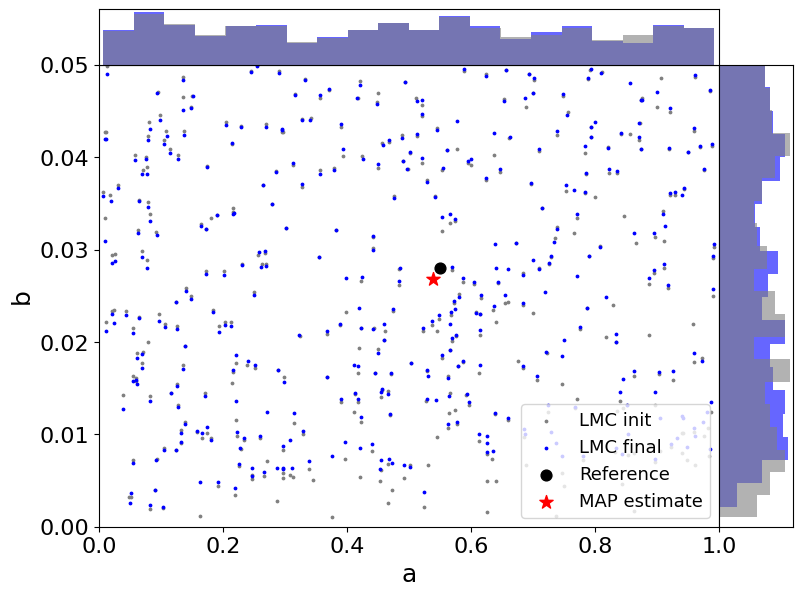

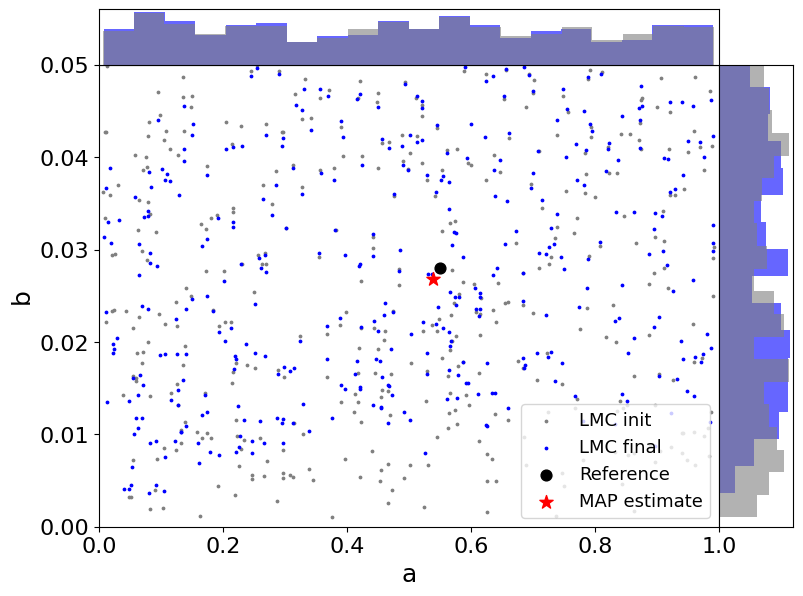

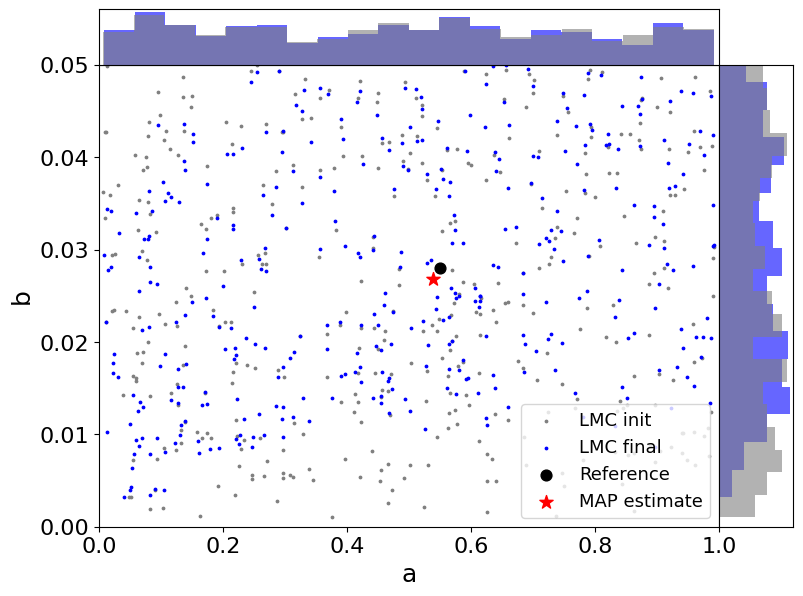

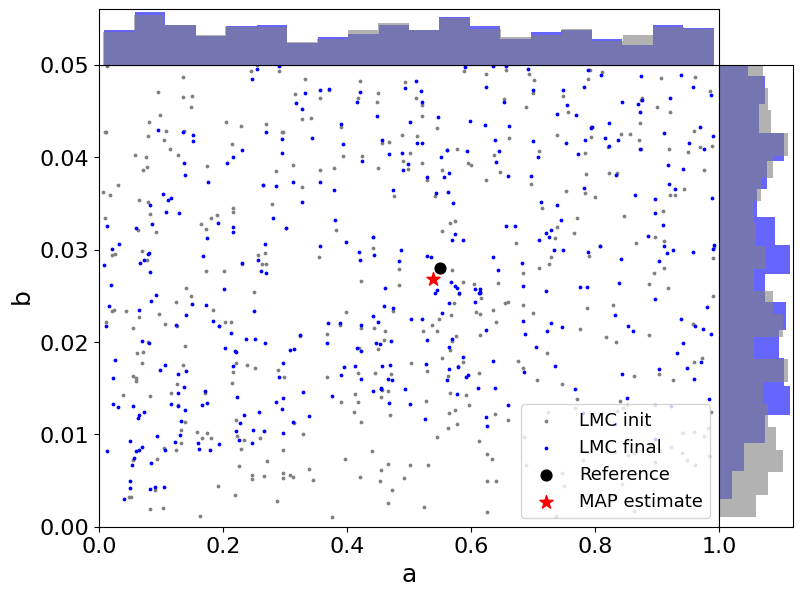

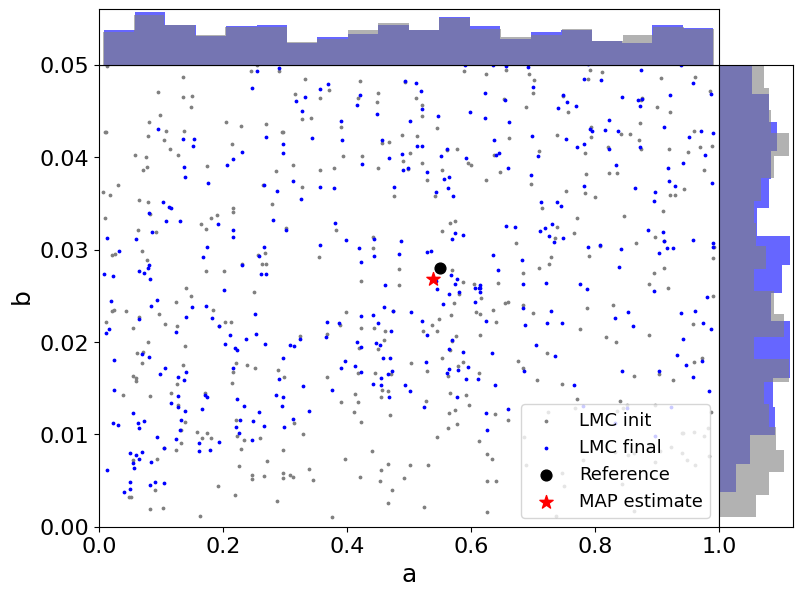

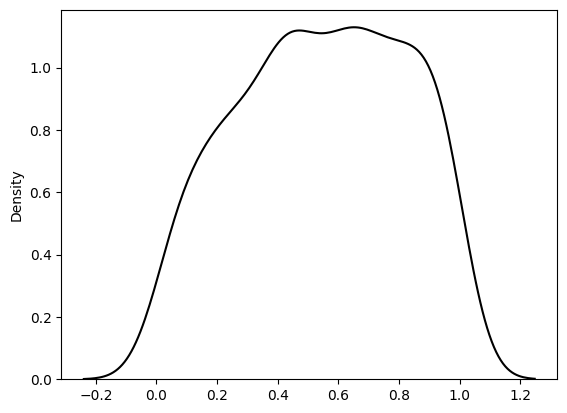

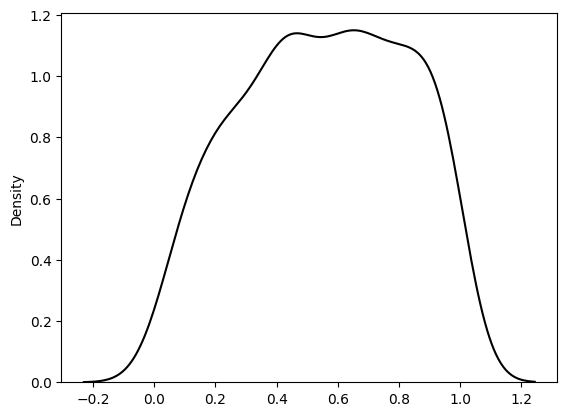

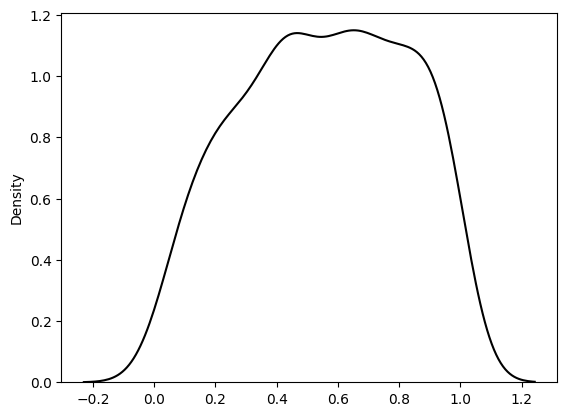

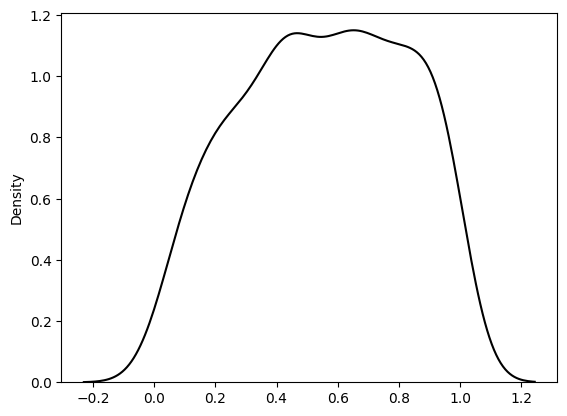

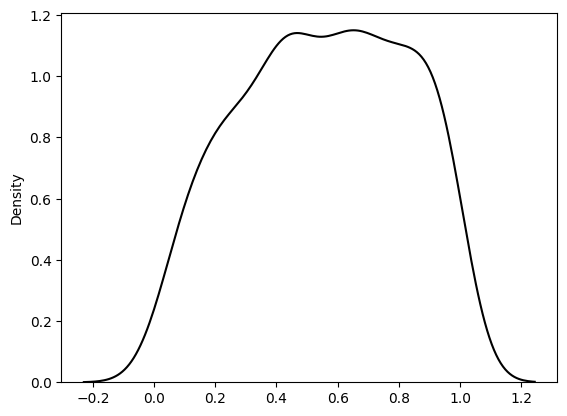

In [ ]:
import seaborn as sns
for select_iter in [0,50,100,150,199]:
    final_particles = Langevin_samples[:,select_iter,:]
    assess_results(init_particles=x0, final_particles=final_particles, method='LMC')
    print(f'no. of nan drops: {np.sum(np.isnan(final_particles).any(axis=1))}')
    final_particles_cleaned = final_particles[~np.isnan(final_particles).any(axis=1)]
    print(f'size of final_particles_cleaned: {len(final_particles_cleaned)}')
    mean_value = np.mean(final_particles_cleaned, axis=0)
    print(f'mean_value: {mean_value}')
for select_iter in [0,50,100,150,199]:
    final_particles = Langevin_samples[:,select_iter,:]
    posterior_MAP_vec = []
    plt.figure()
    for dim in range(4):
        plt.cla()  # Clear the current axis
        ax = sns.kdeplot(np.array(final_particles[:,dim]).flatten(), color='black')
        xs_kde = ax.lines[0].get_xdata()
        ys_kde = ax.lines[0].get_ydata()
        posterior_MAP = xs_kde[np.argmax(ys_kde)]; posterior_MAP_vec.append(posterior_MAP)
    print(f'posterior_MAP_vec:{posterior_MAP_vec}')

## EVI (not used).

In [ ]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
import numpy.matlib as nm
from sklearn.preprocessing import scale
from scipy.special import expit
from sklearn.datasets import load_svmlight_file

class evi():

    def __init__(self):
        pass

    def rbf_kernel(self, theta, h=1):

        diff = theta[:, None, :] - theta[None, :, :]
        kxy = np.exp(-np.sum(diff ** 2, axis=-1) / (2 * h ** 2))
        sumkxy = np.sum(kxy, axis=1, keepdims=True)
        gradK = -diff * kxy[:, :, None] / h ** 2
        dxkxy = np.sum(gradK, axis=0)
        obj = np.sum(np.transpose(gradK, axes=[1,0,2]) / sumkxy, axis=1)

        return dxkxy, sumkxy, obj

    def gradient(self, x, x_initial, grad, tau, kernel='rbf', **kernel_params):
        assert x.shape == grad.shape, 'illegal inputs and grads'
        p_shape = np.shape(x)
        x = np.reshape(x, (np.shape(x)[0], -1))
        x_initial = np.reshape(x_initial, (np.shape(x_initial)[0], -1))
        grad = np.reshape(grad, (np.shape(grad)[0], -1))

        if kernel == 'rbf':
            dxkxy, sumkxy, obj = self.rbf_kernel(x, **kernel_params)

        Akxy = (x - x_initial) / tau + (- dxkxy / sumkxy - obj - grad)
        Akxy = np.reshape(Akxy, p_shape)

        return Akxy

    def evi_updates(self, x0, lnprob, inner_iteration, outer_iteration, tau, evaluation):
        particles = x0.copy()
        particles_initial = x0.copy()
        results = []
        N = particles.shape[0] * particles.shape[1]

        for i in range(outer_iteration):

            for j in range(inner_iteration):

                lnpgrad = lnprob(particles)
                updates_evi = self.gradient(particles, particles_initial, lnpgrad, tau, kernel='rbf')
                grad_now = np.reshape(updates_evi, (1, N))
                if np.sqrt(np.inner(grad_now, grad_now)) < 1e-8:
                    print(j)
                    break

                step_l = 1e-8
                # BB Step - length
                if j > 0:
                    y_k = grad_now - grad_old
                    s_k = np.reshape(particles, (1, N)) - np.reshape(particles_old, (1, N))
                    step_l = np.inner(s_k, s_k) / np.inner(s_k, y_k)

                grad_old = grad_now
                particles_old = particles
                particles = particles - step_l * updates_evi

            particles_initial = particles
            results.append(evaluation(particles))

        return np.asarray(results), particles

def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

class LV_model:
    def __init__(self):
        pass

    def target_p(theta):
        return target_p(theta)

    def dlnprob(self, theta): # first order derivative
        d_log_prob_vec = np.zeros([theta.shape[0], theta.shape[1]])
        for i in range(theta.shape[0]):
            d_log_prob_vec[i,:] = grad_log_target_p(theta[i])
        return d_log_prob_vec

    def evaluation(self, theta):
        prob_vec = np.zeros(theta.shape[0])
        for i in range(theta.shape[0]):
            prob_vec[i] = target_p(theta[i])
        mean_prob = np.mean(prob_vec)
        return [mean_prob]

# initialization
D = 4
M = 400  # number of particles
alpha = 1.0
inner_iteration = 10
outer_iteration = 10
n_iter = inner_iteration * outer_iteration
repeat = 1
results_EVI = np.zeros(shape=(repeat, outer_iteration, 1))
final_particles = np.zeros((repeat, M, D))

for rep in range(repeat):
    # theta0 = np.random.normal(0, np.sqrt(alpha), (M, D))
    theta0 = np.load(wd+'plots/x_neg_init.npy')
    # EVI
    model = LV_model()
    results, final_theta = evi().evi_updates(x0=theta0, lnprob=model.dlnprob, inner_iteration=inner_iteration, outer_iteration=outer_iteration,
                              tau=1e-3, evaluation=model.evaluation)
    results_EVI[rep, :, :] = results
    final_particles[rep, :, :] = final_theta

np.savez(wd+'plots/LV_EVI', results_mean=np.mean(results_EVI, axis=0), results_var=np.std(results_EVI, axis=0), init_particles=theta0, final_particles=final_particles)


## EParVI.

### shared func.

In [ ]:
import numpy as np
from scipy.special import gamma
from matplotlib.colors import Normalize
import copy

np.random.seed(111)

# Compute the comparison metric MMD**2
def polynomial_kernel(x, y):
    return (np.dot(x, y.T) / 3 + 1) ** 3

def compute_mmd2(X, Y):
    N = X.shape[0]
    M = Y.shape[0]
    # Compute the polynomial kernel values
    Kxx = polynomial_kernel(X, X)  # Kernel between all pairs in X
    Kyy = polynomial_kernel(Y, Y)  # Kernel between all pairs in Y
    Kxy = polynomial_kernel(X, Y)  # Kernel between all pairs in X and Y
    # Compute the terms in the MMD squared formula
    term1 = (1 / (N * N)) * np.sum(Kxx)
    term2 = (1 / (M * M)) * np.sum(Kyy)
    term3 = (2 / (N * M)) * np.sum(Kxy)
    # Compute MMD squared
    mmd2 = term1 + term2 - term3
    return mmd2

# General parameters (can be overwritten later for each individual case)
def set_params(update_rule, overwrite_params_dict=None):
    M_neg = 400  # Number of negative charges
    M_pos = 50**2  # Number of positive charges
    d = 4        # Dimensionality (updated to 4)
    q_neg = np.ones(M_neg)  # Charge of negative particles
    q_pos = 1.0             # Charge of positive particles
    q_pos_auto_annealing = False
    epsilon_0 = 8.854e-12   # Permittivity of free space; alternatively: 55.26349406

    SEED = 111              # Random seed for reproducibility
    num_steps = 100         # Number of time steps
    plot_interval = 5       # Plot every 5 steps
    normalize_overall_forces = True  # Whether to normalize forces or not. It affects the choice of step size later.
    normalise_attr_forces = False    # Whether to normalize attracting forces or not
    particle_filtering = False
    move_threshold = 1e-4   # Movement threshold for early stopping
    patience = 5            # Number of consecutive steps with small movements to trigger early stopping

    tau = 0.1
    delta_t = 0.01
    noise_std = 0

    if update_rule == 'Euler':
        tau = 0.1              # Time step size
        noise_std = 0.01       # Standard deviation for Gaussian noise added to the positions
    elif update_rule == 'Verlet':
        q_pos = 5.0
        num_steps = 300
        delta_t = 0.01          # Time step size
        noise_std = 0           # Standard deviation for Gaussian noise added to the positions
    elif update_rule == 'damped_Verlet':
        q_pos = 5.0
        num_steps = 300
        tau = 0.5               # Parameter tau
        delta_t = 0.1           # Time step size
        noise_std = 0

    params_dict = {
        'M_neg': M_neg,
        'M_pos': M_pos,
        'd': d,
        'q_neg': q_neg,
        'q_pos': q_pos,
        'q_pos_auto_annealing': q_pos_auto_annealing,
        'epsilon_0': epsilon_0,
        'SEED': SEED,
        'num_steps': num_steps,
        'plot_interval': plot_interval,
        'normalize_overall_forces': normalize_overall_forces,
        'normalise_attr_forces': normalise_attr_forces,
        'particle_filtering': particle_filtering,
        'move_threshold': move_threshold,
        'patience': patience,
        'tau': tau,
        'delta_t': delta_t,
        'noise_std': noise_std
    }
    # Overwrite parameters if provided
    if overwrite_params_dict is not None:
        for key, value in overwrite_params_dict.items():
            if key in params_dict:
                params_dict[key] = value

    return params_dict

def initialize_positions(target_p, M_neg, M_pos, d, init_dict=None, SEED=111):
    np.random.seed(SEED)

    init_type = init_dict['init_type']

    # Initialize the positions of the positive charges on a grid within specified bounds and grid sizes for each axis
    linspaces = [np.linspace(init_dict[f'low_xy_{i}'], init_dict[f'high_xy_{i}'], init_dict[f'grid_size_{i}']) for i in range(d)]

    # Create meshgrid
    mesh = np.meshgrid(*linspaces)
    # x_pos = np.vstack([m.ravel() for m in mesh]).T[:M_pos]
    x_pos = np.vstack([m.ravel() for m in mesh]).T

    # Initialize the positions of the negative charges
    if init_type == 'uniform':
        lows = [init_dict[f'low_uniform_{i}'] for i in range(d)]
        highs = [init_dict[f'high_uniform_{i}'] for i in range(d)]
        x_neg = np.random.uniform(low=lows, high=highs, size=(M_neg, d))
    elif init_type == 'gaussian':
        x_neg = np.random.normal(loc=init_dict['initial_gaussian_center'], scale=init_dict['initial_gaussian_std'], size=(M_neg, d))
        for i in range(d):
            x_neg[:, i] = np.clip(x_neg[:, i], init_dict[f'low_xy_{i}'], init_dict[f'high_xy_{i}'])
    elif init_type == 'probabilistic':
        # Grid points
        linspaces = [np.linspace(init_dict[f'low_xy_{i}'], init_dict[f'high_xy_{i}'], init_dict[f'grid_size_{i}']) for i in range(d)]
        mesh = np.meshgrid(*linspaces)
        grid_points = np.vstack([m.ravel() for m in mesh]).T

        # Compute probability mass at each grid point
        probabilities = target_p(grid_points)
        probabilities = probabilities.flatten()
        probabilities /= np.sum(probabilities)  # Normalize to sum to 1

        # Sample indices based on the probabilities
        sampled_indices = np.random.choice(len(grid_points), size=M_neg, p=probabilities)
        x_neg = grid_points[sampled_indices]
    else:
        raise ValueError("init_type must be either 'uniform', 'gaussian', or 'probabilistic'")

    return x_neg, x_pos

def compute_forces(x_neg, x_pos, q_neg, q_pos, positive_charge_magnitudes, epsilon_0, d, normalise_attr_forces):
    M_neg = x_neg.shape[0]
    M_pos = x_pos.shape[0]

    F_rep = np.zeros_like(x_neg)
    F_attr = np.zeros_like(x_neg)

    # Compute the normalization constant for target_p if normalization is enabled
    if normalise_attr_forces:
        attr_normalization_constant = np.sum([positive_charge_magnitudes[i_prime] for i_prime in range(M_pos)])
    else:
        attr_normalization_constant = 1  # Set to 1 to avoid altering the target_p values

    # Compute repulsive forces
    for j in range(M_neg):
        for i in range(M_neg):
            if i != j:
                r_ij = np.linalg.norm(x_neg[j] - x_neg[i])
                if r_ij > 0:
                    F_rep[j] += (q_neg[i] * q_neg[j] * gamma(d/2)) / (2 * np.pi**(d/2) * epsilon_0 * r_ij**(d-1)) * (x_neg[j] - x_neg[i]) / r_ij
    # Compute attractive forces
    for j in range(M_neg):
        for i_prime in range(M_pos):
            r_ij = np.linalg.norm(x_neg[j] - x_pos[i_prime])
            if r_ij > 0:
                normalized_target_p = positive_charge_magnitudes[i_prime] / attr_normalization_constant
                F_attr[j] -= (q_pos * normalized_target_p * q_neg[j] * gamma(d/2)) / (2 * np.pi**(d/2) * epsilon_0 * r_ij**(d-1)) * (x_neg[j] - x_pos[i_prime]) / r_ij

    print(f'F_rep:\n {F_rep[:10]} \n F_attr:\n {F_attr[:10]}')
    return F_rep, F_attr, F_rep + F_attr

def evolve_system(init_dict, update_rule, x_neg, x_pos, params_dict, positive_charge_magnitudes, target_p, ground_truth_samples):
    d = params_dict['d']
    q_neg = params_dict['q_neg']
    q_pos = params_dict['q_pos']
    q_pos_auto_annealing = params_dict['q_pos_auto_annealing']
    num_steps = params_dict['num_steps']
    plot_interval = params_dict['plot_interval']
    normalize_overall_forces = params_dict['normalize_overall_forces']
    normalise_attr_forces = params_dict['normalise_attr_forces']
    particle_filtering = params_dict['particle_filtering']
    move_threshold = params_dict['move_threshold']
    patience = params_dict['patience']
    noise_std = params_dict['noise_std']
    delta_t = params_dict['delta_t']
    epsilon_0 = params_dict['epsilon_0']
    tau = params_dict['tau']
    low_xy = [init_dict[f'low_xy_{i}'] for i in range(d)]
    high_xy = [init_dict[f'high_xy_{i}'] for i in range(d)]
    margin = init_dict['margin']

    x_neg_prev = x_neg.copy()
    consecutive_small_moves = 0

    # Create a dict to store all negative particle trajectories
    all_trajectories = {idx: [] for idx in range(params_dict['M_neg'])}

    # Move negative particles
    particle_counts_vec = []
    remained_neg_indices_all_iterations = []
    removed_neg_indices_all_iterations = []
    original_neg_indices = np.arange(params_dict['M_neg'])
    if q_pos_auto_annealing and normalise_attr_forces:  # Then q_pos=params_dict['q_pos'] is interpreted as how many times at initial the positive charge is
        init_F_rep = compute_forces(x_neg, x_pos, q_neg, q_pos, positive_charge_magnitudes, epsilon_0, d, normalise_attr_forces)[0]
        init_distances = cdist(x_neg, x_pos, metric='euclidean')
        median_init_distances = np.median(init_distances.flatten())
        q_pos0 = q_pos * np.max(np.abs(init_F_rep)) * median_init_distances**(d-1) * epsilon_0 * 2 * np.pi**(d/2) / (q_neg[0] * gamma(d/2))
        q_pos = copy.deepcopy(q_pos0)
    print(f'q_pos: {q_pos}')
    step_time_vec = []
    MMD2_vec = []
    NLL_vec = []
    for t in range(52, 52+num_steps):
        print(f'step: {t}')
        start_time = time.time()

        # Count how many of x_neg are lying within the hyperrectangle defined by low_xy and high_xy in the current iteration.
        mask = np.ones(x_neg.shape[0], dtype=bool)
        for i in range(d):
            mask &= (x_neg[:, i] >= low_xy[i]) & (x_neg[:, i] <= high_xy[i])
        count = np.sum(mask)
        particle_counts_vec.append(count)
        print(f'no. of negative charges currently contained within the bounds {[low_xy, high_xy]} (particle_filtering:{particle_filtering}): {count}')
        if particle_filtering:  # Remove those negative charges falling outside
            x_neg = x_neg[mask]
            remained_indices = original_neg_indices[mask]
            removed_indices = original_neg_indices[~mask]
            remained_neg_indices_all_iterations.append(remained_indices.tolist())
            removed_neg_indices_all_iterations.append(removed_indices.tolist())
            original_neg_indices = remained_indices
        else:
            remained_indices = original_neg_indices

        # Attach the trajectories
        for idx_original, idx_new in zip(remained_indices, np.arange(len(remained_indices))):
            all_trajectories[idx_original].append(x_neg[idx_new].copy())

        # Compute MMD^2 and mean logp
        mmd2_value = compute_mmd2(x_neg[remained_indices], ground_truth_samples)
        MMD2_vec.append(mmd2_value)
        # nll_value = -np.mean(np.log(target_p(x_neg[remained_indices]) + 1e-10))
        nll_value = -np.mean(target_p(x_neg[remained_indices]))
        NLL_vec.append(nll_value)

        # Now x_neg, x_pos (and q_pos) are both set up, we are ready to compute the forces.
        F_rep, F_attr, F = compute_forces(x_neg, x_pos, q_neg, q_pos, positive_charge_magnitudes, epsilon_0, d, normalise_attr_forces)
        if normalize_overall_forces:
            # Normalize the force vectors for each particle
            norm_F = np.linalg.norm(F, axis=1).reshape(-1, 1)
            norm_F[norm_F == 0] = 1  # avoid division by zero
            F = F / norm_F

        if update_rule == 'Euler':
            # Simple Euler method
            delta_x = tau * F
        elif update_rule == 'Verlet':
            # Verlet Integration (Leapfrog Method)
            delta_x = F * (delta_t ** 2) + 2 * x_neg - x_neg_prev - x_neg
        elif update_rule == 'damped_Verlet':
            # Damped Verlet Integration (Modified Method)
            delta_x = tau * (F * (delta_t ** 2) + (x_neg - x_neg_prev))
        else:
            raise ValueError("Invalid update rule specified.")

        x_neg_next = x_neg + delta_x

        # Add Gaussian noise to the positions
        noise = np.random.normal(loc=0, scale=noise_std, size=x_neg.shape)
        x_neg_next += noise

        # Update positions
        x_neg_prev = x_neg.copy()
        x_neg = x_neg_next

        # Annealing q_pos
        if q_pos_auto_annealing and normalise_attr_forces:
            q_pos = np.max([(q_pos0 - 1) * np.exp(-0.1 * t) + 1, 0.5 * q_pos0])  # q_pos decreases from q_pos and lower bounded by 1 = q_neg
        print(f'q_pos: {q_pos}')

        end_time = time.time()
        step_time = end_time - start_time
        print(f'step time: {step_time} seconds')
        step_time_vec.append(step_time)

        # Save x_neg in each iteration
        np.savez(wd+f'plots/[step:{t}: x_neg, x_pos, step_time, mmd2_value, nll_value].npz',
                 x_neg=x_neg, x_pos=x_pos, step_time=step_time, mmd2_value=mmd2_value, nll_value=nll_value)

        # Check for early stopping
        if np.all(np.linalg.norm(delta_x + noise, axis=1) < move_threshold):
            consecutive_small_moves += 1
        else:
            consecutive_small_moves = 0

        if consecutive_small_moves >= patience:
            print(f"Early stopping at step {t} due to small movements.")
            break

    return x_neg, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec

# Plot the all_trajectories of selected particles
def trajectory_plot(all_trajectories, selected_indices, low_xy, high_xy, margin, params_dict, init_dict, total_time):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create a colormap for the trajectories
    num_colors = len(selected_indices)
    colors = plt.cm.viridis(np.linspace(0, 1, num_colors))

    # Plot all trajectories
    for idx, color in zip(selected_indices, colors):
        traj = np.array(all_trajectories[idx])
        ax.plot(traj[:, 0], traj[:, 1], color=color, label='Trajectory' if idx == selected_indices[0] else "")  # Plot entire trajectory
        ax.scatter(traj[0, 0], traj[0, 1], color=color, marker='o', s=60, label='Initial position' if idx == selected_indices[0] else "")  # Initial position
        ax.scatter(traj[-1, 0], traj[-1, 1], color=color, marker='s', s=60, label='Final position' if idx == selected_indices[0] else "")  # Final position

    ax.set_xlim(low_xy[0] - margin, high_xy[0] + margin)
    ax.set_ylim(low_xy[1] - margin, high_xy[1] + margin)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title('Trajectories of selected particles')
    plt.savefig(wd+f"plots/selected_trajectories (M_neg:{params_dict['M_neg']},M_pos:{params_dict['M_pos']},num_steps:{params_dict['num_steps']},init_type:{init_dict['init_type']},total_time:{total_time}).png")
    plt.show()

In [ ]:
import numpy as np

min_a = 0.001
min_b = 0.001
min_c = 0.001
min_d = 0.001
max_a = 1.0
max_b = 0.05
max_c = 0.05
max_d = 1.0

sigma=0.25

X_prime = hare.copy()
Y_prime = lynx.copy()

# def target_p(theta):
#     global X_prime, Y_prime
#     a, b, c, d = theta

#     small_number = -1e6

#     global min_a,min_b,min_c,min_d,max_a,max_b,max_c,max_d,sigma

#     xy_vec = ode_model.simulate(parameters=(a,b,d,c,33.956,5.933), times=tspan) # parameters = [alpha, beta, gamma, delta, Xt0, Yt0]
#     X = np.array([xx[0] for xx in xy_vec])
#     Y = np.array([xx[1] for xx in xy_vec])

#     N = len(X_prime)

#     # log-likelihood: log p(X', Y'|a, b, c, d, x0, y0, sigma)
#     if np.any(X<=0) or np.any(Y<=0):
#         log_posterior = small_number
#     else:
#         log_p_XY_prime = -2 * N * np.log(np.sqrt(2 * np.pi) * sigma) - np.sum(np.log(X_prime) + np.log(Y_prime)) - (1 / (2 * sigma**2)) * np.sum((np.log(X_prime) - np.log(X))**2 + (np.log(Y_prime) - np.log(Y))**2)
#         # log-poterior
#         log_posterior = np.log(1/(max_a-min_a)) + np.log(1/(max_b-min_b)) + np.log(1/(max_c-min_c)) + np.log(1/(max_d-min_d)) + log_p_XY_prime

#     return log_posterior

def target_p(theta):
    global X_prime, Y_prime
    a, b, c, d = theta

    global min_a, min_b, min_c, min_d, max_a, max_b, max_c, max_d, sigma

    xy_vec = ode_model.simulate(parameters=(a, b, d, c, 33.956, 5.933), times=tspan)  # parameters = [alpha, beta, gamma, delta, Xt0, Yt0]
    X = np.array([xx[0] for xx in xy_vec])
    Y = np.array([xx[1] for xx in xy_vec])

    N = len(X_prime)

    # Check for invalid values
    if np.any(X <= 0) or np.any(Y <= 0):
        return None

    # log-likelihood: log p(X', Y'|a, b, c, d, x0, y0, sigma)
    log_p_XY_prime = -2 * N * np.log(np.sqrt(2 * np.pi) * sigma) - np.sum(np.log(X_prime) + np.log(Y_prime)) - (1 / (2 * sigma**2)) * np.sum((np.log(X_prime) - np.log(X))**2 + (np.log(Y_prime) - np.log(Y))**2)
    # log-posterior
    log_posterior = np.log(1/(max_a - min_a)) + np.log(1/(max_b - min_b)) + np.log(1/(max_c - min_c)) + np.log(1/(max_d - min_d)) + log_p_XY_prime

    return log_posterior

def vectorized_target_p(theta_array):
    # Check if the input is a single 4-dimensional vector
    if theta_array.ndim == 1:
        return target_p(theta_array)
    else:
        # Apply the target_p function to each row of the input array
        results = np.apply_along_axis(target_p, 1, theta_array)
        return results

### Initial run.

In [ ]:
import pickle, time

np.random.seed(111)

update_rule = 'Euler'
params_dict = set_params(update_rule, {'num_steps':300,
    'd': 4,
    'M_pos': None,
    'M_neg': 400,
    'q_pos': 1e-5,
    'tau': 1e-2,
    'q_pos_auto_annealing': False,
    'normalize_overall_forces': True,
    'normalise_attr_forces': False,
    'particle_filtering': False,
    'noise_std': 0
})

init_dict = {'init_type': 'uniform',  # or 'gaussian' or 'probabilistic'
             'low_xy_0': min_a, 'high_xy_0': max_a, 'grid_size_0': 40,  # bounds and grid size for axis 0 for assigning x_pos
             'low_xy_1': min_b, 'high_xy_1': max_b, 'grid_size_1': 20,
             'low_xy_2': min_c, 'high_xy_2': max_c, 'grid_size_2': 20,
             'low_xy_3': min_d, 'high_xy_3': max_d, 'grid_size_3': 40,
             'low_uniform_0': min_a, 'high_uniform_0': max_a,  # uniform bounds for axis 0 for assigning x_neg
             'low_uniform_1': min_b, 'high_uniform_1': max_b,
             'low_uniform_2': min_c, 'high_uniform_2': max_c,
             'low_uniform_3': min_d, 'high_uniform_3': max_d,
             'margin': 0}

start_time = time.time()
# Initialize positions with a seed for reproducibility
x_neg, x_pos = initialize_positions(target_p=vectorized_target_p,
                                    M_neg=params_dict['M_neg'],
                                    M_pos=params_dict['M_pos'],
                                    d=params_dict['d'],
                                    init_dict=init_dict,
                                    SEED=params_dict['SEED'])
np.save(wd+'plots/x_neg_init.npy', x_neg)
np.save(wd+'plots/x_pos_init.npy', x_pos)

# load HMC samples as ground truth samples for calculating MMD^2
with open(wd + 'LV/HMC_uniformPriors/HMC_chain0_uniformPriors.pkl', 'rb') as f:
    trace_chain0_dict = pickle.load(f)
# a = alpha, b = beta, c = delta, d = gamma
ground_truth_samples = np.array(list(zip(trace_chain0_dict['ɑ'],trace_chain0_dict['β'],trace_chain0_dict['δ'], trace_chain0_dict['γ'])))

# pre-calculate all positive charges' magnitudes.
positive_charge_magnitudes = []
for i_pos in range(len(x_pos)):
    positive_charge_magnitudes.append(target_p(x_pos[i_pos]))
positive_charge_magnitudes = np.array(positive_charge_magnitudes)
print(f'positive_charge_magnitudes:{positive_charge_magnitudes[:5]}')
np.savez(wd+f'plots/positive_charge_magnitudes.npz', positive_charge_magnitudes=positive_charge_magnitudes)
# uplift all log posterior so that all values are non-negative
positive_charge_magnitudes = positive_charge_magnitudes.astype(float)
positive_charge_magnitudes = np.nan_to_num(positive_charge_magnitudes, nan=np.nanmin(positive_charge_magnitudes))
positive_charge_magnitudes = positive_charge_magnitudes - np.nanmin(positive_charge_magnitudes)

# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    positive_charge_magnitudes = positive_charge_magnitudes,
    target_p=vectorized_target_p,
    ground_truth_samples=ground_truth_samples)
end_time = time.time()
total_time = end_time - start_time
print(f'total run time: {total_time} seconds')

# plot trajectories for selected particles
selected_indices = [2, 40, 141, 145]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                low_xy=[min_a,min_b,min_c,min_d],
                high_xy=[max_a,max_b,max_c,max_d],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# Save results
results_dict = {
    'update_rule': update_rule,
    'params_dict': params_dict,
    'init_dict': init_dict,
    'init_x_neg': x_neg,
    'init_x_pos': x_pos,
    'x_neg_final': x_neg_final,
    'all_trajectories': all_trajectories,
    'particle_counts_vec': particle_counts_vec,
    'selected_indices': selected_indices,
    'total_time': total_time,
    'step_time_vec': step_time_vec,
    'MMD2_vec': MMD2_vec,
    'NLL_vec': NLL_vec
}
# Saving the dictionary
with open(wd+'plots/results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

positive_charge_magnitudes:[-324.42302367547575 -387.10902260773696 -479.15811873993243
 -600.7578744002595 -752.0589583006547]
q_pos: 1e-05
step: 0
no. of negative charges currently contained within the bounds [[0.001, 0.001, 0.001, 0.001], [1.0, 0.05, 0.05, 1.0]] (particle_filtering:False): 400
F_rep:
 [[ 2.38636593e+14 -2.01718975e+14 -9.64051277e+13 -2.13163524e+14]
 [ 3.74582207e+13 -9.13793228e+13 -1.40681850e+14 -7.22732363e+13]
 [-1.54309300e+15 -3.26206397e+13  1.02860488e+15  2.80801564e+13]
 [-1.51298967e+14 -9.32231871e+13  1.59018361e+14  1.26113595e+14]
 [-3.87711252e+14 -1.82645811e+14 -1.55070232e+14  2.97517945e+13]
 [ 1.50707618e+13  1.57968882e+13  3.12710238e+13  6.70551046e+13]
 [ 5.30388790e+13  4.48612358e+13 -3.75393493e+13 -5.93406922e+13]
 [ 1.72738450e+14 -1.82179286e+14  4.21711365e+14 -4.53460426e+13]
 [ 2.69830287e+13 -9.57874202e+13  2.27375929e+14 -8.10257609e+13]
 [ 4.52045685e+13  1.03117357e+13 -1.94116164e+13 -1.26138566e+14]] 
 F_attr:
 [[ 3.8381583

### Continuous run after interuption.

In [ ]:
import pickle, time

np.random.seed(111)

update_rule = 'Euler'
params_dict = set_params(update_rule, {'num_steps':300,
    'd': 4,
    'M_pos': None,
    'M_neg': 400,
    'q_pos': 1e-5,
    'tau': 1e-2,
    'q_pos_auto_annealing': False,
    'normalize_overall_forces': True,
    'normalise_attr_forces': False,
    'particle_filtering': False,
    'noise_std': 0
})

init_dict = {'init_type': 'uniform',  # or 'gaussian' or 'probabilistic'
             'low_xy_0': min_a, 'high_xy_0': max_a, 'grid_size_0': 40,  # bounds and grid size for axis 0 for assigning x_pos
             'low_xy_1': min_b, 'high_xy_1': max_b, 'grid_size_1': 20,
             'low_xy_2': min_c, 'high_xy_2': max_c, 'grid_size_2': 20,
             'low_xy_3': min_d, 'high_xy_3': max_d, 'grid_size_3': 40,
             'low_uniform_0': min_a, 'high_uniform_0': max_a,  # uniform bounds for axis 0 for assigning x_neg
             'low_uniform_1': min_b, 'high_uniform_1': max_b,
             'low_uniform_2': min_c, 'high_uniform_2': max_c,
             'low_uniform_3': min_d, 'high_uniform_3': max_d,
             'margin': 0}

start_time = time.time()
last_data = np.load(wd+f'LV/EParVI/[step:51: x_neg, x_pos, step_time, mmd2_value, nll_value].npz')
x_neg = last_data['x_neg']
x_pos = last_data['x_pos']

# load HMC samples as ground truth samples for calculating MMD^2
with open(wd + 'LV/HMC_uniformPriors/HMC_chain0_uniformPriors.pkl', 'rb') as f:
    trace_chain0_dict = pickle.load(f)
# a = alpha, b = beta, c = delta, d = gamma
ground_truth_samples = np.array(list(zip(trace_chain0_dict['ɑ'],trace_chain0_dict['β'],trace_chain0_dict['δ'], trace_chain0_dict['γ'])))

# pre-calculate all positive charges' magnitudes.
positive_charge_magnitudes = np.load(wd+f'plots/positive_charge_magnitudes.npz', allow_pickle=True)['positive_charge_magnitudes']
# uplift all log posterior so that all values are non-negative
positive_charge_magnitudes = positive_charge_magnitudes.astype(float)
positive_charge_magnitudes = np.nan_to_num(positive_charge_magnitudes, nan=np.nanmin(positive_charge_magnitudes))
positive_charge_magnitudes = positive_charge_magnitudes - np.nanmin(positive_charge_magnitudes)

# Evolve the system and plot intermediate steps
x_neg_final, all_trajectories, particle_counts_vec, remained_neg_indices_all_iterations, removed_neg_indices_all_iterations, step_time_vec, MMD2_vec, NLL_vec = evolve_system(
    init_dict=init_dict,
    update_rule=update_rule,
    x_neg=x_neg,
    x_pos=x_pos,
    params_dict=params_dict,
    positive_charge_magnitudes = positive_charge_magnitudes,
    target_p=vectorized_target_p,
    ground_truth_samples=ground_truth_samples)
end_time = time.time()
total_time = end_time - start_time
print(f'total run time: {total_time} seconds')

# plot trajectories for selected particles
selected_indices = [2, 40, 141, 145]
trajectory_plot(all_trajectories=all_trajectories,
                selected_indices=selected_indices,
                low_xy=[min_a,min_b,min_c,min_d],
                high_xy=[max_a,max_b,max_c,max_d],
                margin=init_dict['margin'],
                params_dict=params_dict,
                init_dict=init_dict,
                total_time=total_time)

# Save results
results_dict = {
    'update_rule': update_rule,
    'params_dict': params_dict,
    'init_dict': init_dict,
    'init_x_neg': x_neg,
    'init_x_pos': x_pos,
    'x_neg_final': x_neg_final,
    'all_trajectories': all_trajectories,
    'particle_counts_vec': particle_counts_vec,
    'selected_indices': selected_indices,
    'total_time': total_time,
    'step_time_vec': step_time_vec,
    'MMD2_vec': MMD2_vec,
    'NLL_vec': NLL_vec
}
# Saving the dictionary
with open(wd+'plots/results_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

q_pos: 1e-05
step: 52
no. of negative charges currently contained within the bounds [[0.001, 0.001, 0.001, 0.001], [1.0, 0.05, 0.05, 1.0]] (particle_filtering:False): 399
F_rep:
 [[ 2.19670318e+13  1.41059907e+13  2.05410905e+13 -5.86355745e+14]
 [ 4.49749549e+14  1.91517342e+13 -1.31094698e+13 -2.37134482e+14]
 [-5.57796704e+14  4.78638848e+12  1.58309080e+12  1.73893560e+14]
 [-8.45844765e+13  1.18760484e+13 -3.11431925e+12  4.35156571e+13]
 [ 1.50136412e+15 -8.25314571e+15  1.45186246e+16  1.10902463e+16]
 [-3.19313191e+13  2.32321116e+10  8.75359552e+10  7.04492204e+13]
 [ 5.01182656e+14  1.15504970e+13 -1.54510194e+13 -1.30753105e+14]
 [ 6.81627823e+14 -2.92412612e+12 -9.42891945e+11  7.98822764e+14]
 [ 4.06739002e+14  5.46975403e+12  4.64925374e+12 -1.49396904e+14]
 [ 2.34591393e+13  6.20809676e+12 -9.77825652e+12 -4.16420652e+13]] 
 F_attr:
 [[ 4.45799446e+17  3.82065337e+16  3.87210508e+16  5.42813417e+17]
 [-9.98790586e+17  1.37202101e+17 -1.25184244e+17  5.75132334e+17]
 [-4.

### Analysis.

mean_final_particles: [0.48738504 0.0263313  0.0239714  0.52854521]
mode_final_particles: [0.5491382298229502, 0.025759572702097423, 0.02534506587388504, 0.6451291037436825]


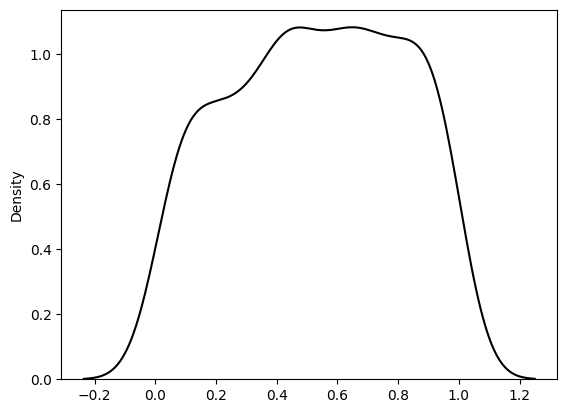

In [ ]:
final_particles = np.load(wd+f'LV/EParVI/[step:82: x_neg, x_pos, step_time, mmd2_value, nll_value].npz', allow_pickle=True)['x_neg']

from scipy.stats import mode
import seaborn as sns

mean_final_particles = np.mean(final_particles, axis=0)

mode_final_particles = []
for dim in range(4):
    plt.cla()  # Clear the current axis
    ax = sns.kdeplot(np.array(final_particles[:,dim]).flatten(), color='black')
    xs_kde = ax.lines[0].get_xdata()
    ys_kde = ax.lines[0].get_ydata()
    posterior_MAP = xs_kde[np.argmax(ys_kde)]; mode_final_particles.append(posterior_MAP)

print(f'mean_final_particles: {mean_final_particles}')
print(f'mode_final_particles: {mode_final_particles}')

#### posterior predictive.

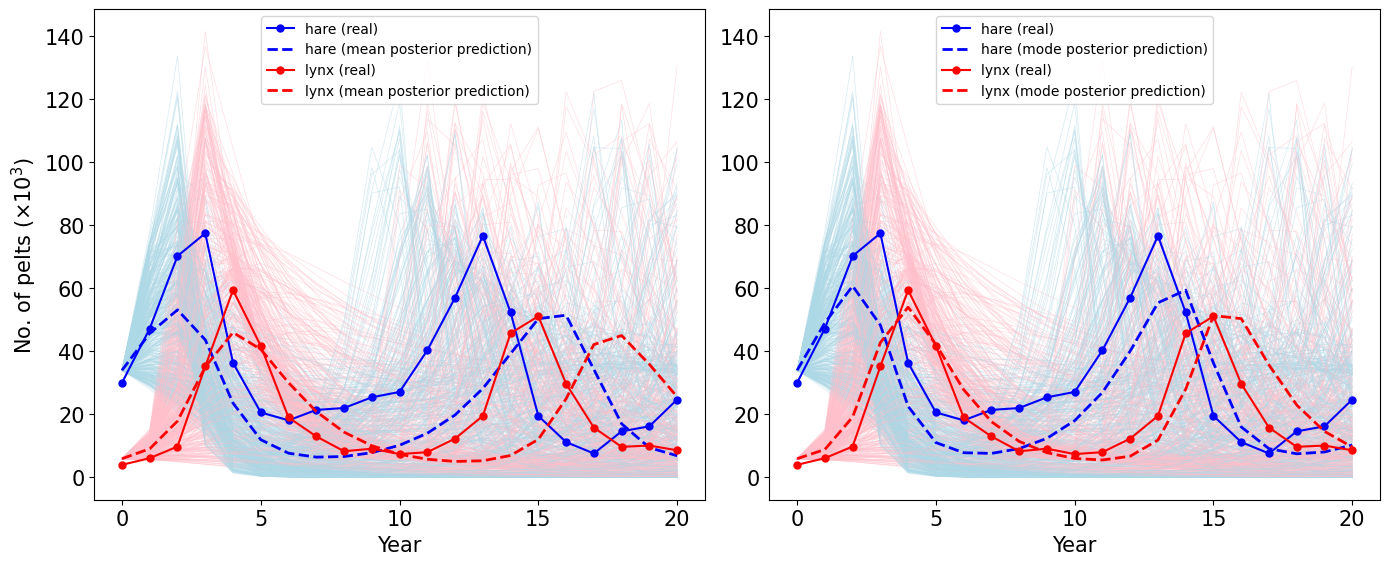

In [ ]:
def simulate_particle(theta):
    a, b, c, d = theta
    xy_vec = ode_model.simulate(parameters=(a, b, d, c, 33.956, 5.933), times=tspan)
    x_vec = [xx[0] for xx in xy_vec]
    y_vec = [xx[1] for xx in xy_vec]
    return x_vec, y_vec

# Simulate for mean and mode particles
x_mean, y_mean = simulate_particle(mean_final_particles)
x_mode, y_mode = simulate_particle(mode_final_particles)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('Posterior predictive (left: posterior mean, right: posterior mode)')

# Plot uncertainties for all particles
for particle in final_particles:
    x_vec, y_vec = simulate_particle(particle)
    axs[0].plot(tspan, x_vec, color='lightblue', alpha=0.5, linewidth=0.5)
    axs[1].plot(tspan, x_vec, color='lightblue', alpha=0.5, linewidth=0.5)
    axs[0].plot(tspan, y_vec, color='pink', alpha=0.5, linewidth=0.5)
    axs[1].plot(tspan, y_vec, color='pink', alpha=0.5, linewidth=0.5)

# Plot the hare and lynx data along with mean and mode trajectories
axs[0].plot(np.arange(0, len(hare), 1), hare, '.-', markersize=10, color='blue', label='hare (real)')
axs[0].plot(tspan, x_mode, '--', linewidth=2, color='blue', label='hare (mode posterior prediction)')
axs[0].plot(np.arange(0, len(lynx), 1), lynx, '.-', markersize=10, color='red', label='lynx (real)')
axs[0].plot(tspan, y_mode, '--', linewidth=2, color='red', label='lynx (mode posterior prediction)')
axs[0].set_xticks([0, 5, 10, 15, 20])
axs[0].xaxis.set_tick_params(labelsize=15)
axs[0].yaxis.set_tick_params(labelsize=15)
axs[0].set_xlabel('Year', fontsize=15)
axs[0].set_ylabel(r'No. of pelts ($\times 10^3$)', fontsize=15)
axs[0].legend()

axs[1].plot(np.arange(0, len(hare), 1), hare, '.-', markersize=10, color='blue', label='hare (real)')
axs[1].plot(tspan, x_mean, '--', linewidth=2, color='blue', label='hare (mean posterior prediction)')
axs[1].plot(np.arange(0, len(lynx), 1), lynx, '.-', markersize=10, color='red', label='lynx (real)')
axs[1].plot(tspan, y_mean, '--', linewidth=2, color='red', label='lynx (mean posterior prediction)')
axs[1].set_xticks([0, 5, 10, 15, 20])
axs[1].xaxis.set_tick_params(labelsize=15)
axs[1].yaxis.set_tick_params(labelsize=15)
axs[1].set_xlabel('Year', fontsize=15)
# axs[1].set_ylabel(r'No. of pelts ($\times 10^3$)', fontsize=15)
axs[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### MAP of all positive charge magnitudes.

In [ ]:
positive_charge_magnitudes = np.load(wd+f'plots/positive_charge_magnitudes.npz', allow_pickle=True)['positive_charge_magnitudes']
len(positive_charge_magnitudes)
positive_charge_magnitudes = positive_charge_magnitudes.astype(float)
positive_charge_magnitudes = np.nan_to_num(positive_charge_magnitudes, nan=np.nanmin(positive_charge_magnitudes))
positive_charge_magnitudes = positive_charge_magnitudes - np.nanmin(positive_charge_magnitudes)
positive_charge_magnitudes = q_pos * positive_charge_magnitudes

x_pos = np.load(wd+f'plots/x_pos_init.npy')

len(x_pos)

MAP_index = np.argmax(positive_charge_magnitudes)

# Get the coordinate corresponding to the maximum posterior value
max_posterior_coordinate = x_pos[MAP_index]
print("The coordinate of the MAP position is:", max_posterior_coordinate)

#### plot final results.

In [ ]:
x_neg_init = np.load(wd+f'plots/x_neg_init.npy')
x_neg_inter = np.load(wd+f'plots/[step_51_ x_neg, x_pos, step_time, mmd2_value, nll_value].npz')['x_neg']
x_neg_current = np.load(wd+f'plots/[step_82_ x_neg, x_pos, step_time, mmd2_value, nll_value].npz')['x_neg']

plot_dim = [0,1]
not_plot_dim = [2,3]
plot_ranges = [[0,1],[0,0.05],[0,0.05],[0,1]]

a=0.55
b=0.028
c=0.024
d=0.80
ground_truth_values = [a,b,c,d]
ground_trueth_labels = ['a','b','c','d']

plt.figure(figsize=(10, 6))
plt.vlines(x=ground_truth_values[plot_dim[0]], ymin=0, ymax=0.05, color='pink', linestyle='-')
plt.hlines(y=ground_truth_values[plot_dim[1]], xmin=0, xmax=1, color='pink', linestyle='-')
plt.scatter(x_neg_init[:, plot_dim[0]], x_neg_init[:, plot_dim[1]], alpha=0.5, color='grey')
plt.scatter(x_neg_inter[:, plot_dim[0]], x_neg_inter[:, plot_dim[1]], alpha=0.5, color='black')
plt.scatter(x_neg_current[:, plot_dim[0]], x_neg_current[:, plot_dim[1]], alpha=0.5, color='red')
plt.title('Scatter plot of the first two dimensions of x_neg')
plt.xlabel(f'{ground_trueth_labels[plot_dim[0]]}', fontsize=16)
plt.ylabel(f'{ground_trueth_labels[plot_dim[1]]}', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.xlim([plot_ranges[plot_dim[0]][0], plot_ranges[plot_dim[0]][1]])
plt.ylim([plot_ranges[plot_dim[1]][0], plot_ranges[plot_dim[1]][1]])
plt.grid(True)
plt.show()

# Create histograms for the marginal distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].hist(x_neg_current[:, 0], bins=30, alpha=0.7, color='blue', edgecolor='black')
ax[0].set_title(f'Histogram of Dimension {plot_dim[0]+1}')
ax[0].set_xlabel(f'{ground_trueth_labels[plot_dim[0]]}')
ax[0].set_ylabel('Frequency')
ax[0].grid(True)

ax[1].hist(x_neg_current[:, 1], bins=30, alpha=0.7, color='green', edgecolor='black')
ax[1].set_title(f'Histogram of Dimension {plot_dim[1]+1}')
ax[1].set_xlabel(f'{ground_trueth_labels[plot_dim[1]]}')
ax[1].set_ylabel('Frequency')
ax[1].grid(True)

plt.tight_layout()
plt.show()

#### distribution of initial and final particles.

In [ ]:
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def assess_results(init_particles, final_particles, method=None):

    global plot_dim, plot_ranges, plot_dim, ground_truth_values

    low_xy_1 = plot_ranges[plot_dim[0]][0]
    high_xy_1 = plot_ranges[plot_dim[0]][1]
    low_xy_2 = plot_ranges[plot_dim[1]][0]
    high_xy_2 = plot_ranges[plot_dim[1]][1]
    margin = 0

    # Plotting the samples and the density contours with marginal distributions
    fig, ax_main = plt.subplots(figsize=(8, 6))

    # Plot the samples
    scatter_samples_init = ax_main.scatter(init_particles[:, plot_dim[0]], init_particles[:, plot_dim[1]], c='grey', s=3, label=f'{method} init')
    scatter_samples_final = ax_main.scatter(final_particles[:, plot_dim[0]], final_particles[:, plot_dim[1]], c='blue', s=3, label=f'{method} final')
    scatter_reference1 = ax_main.scatter(ground_truth_values[plot_dim[0]], ground_truth_values[plot_dim[1]], c='black', s=60, label=f'Reference')
    scatter_reference2 = ax_main.scatter(max_posterior_coordinate[plot_dim[0]], max_posterior_coordinate[plot_dim[1]], c='red', s=100, marker='*', label='MAP estimate')

    # Set plot limits and labels
    ax_main.set_xlim(low_xy_1 - margin, high_xy_1 + margin)
    ax_main.set_ylim(low_xy_2 - margin, high_xy_2 + margin)
    ax_main.set_xlabel(f'{ground_trueth_labels[plot_dim[0]]}', fontsize=18)
    ax_main.set_ylabel(f'{ground_trueth_labels[plot_dim[1]]}', fontsize=18)
    ax_main.legend(loc='lower right', fontsize=13)
    # ax_main.set_xticklabels(np.linspace(low_xy_1, high_xy_1,6), fontsize=16)
    # ax_main.set_yticklabels(np.linspace(low_xy_2, high_xy_2,5), fontsize=16)
    ax_main.tick_params(axis='x', labelsize=16)
    ax_main.tick_params(axis='y', labelsize=16)

    # Create inset axes for the histograms
    ax_histx = inset_axes(ax_main, width="100%", height="60%", loc='upper center',
                          bbox_to_anchor=(0, 0.92, 1, 0.2), bbox_transform=ax_main.transAxes, borderpad=0)
    ax_histy = inset_axes(ax_main, width="60%", height="100%", loc='center right',
                          bbox_to_anchor=(0.92, 0, 0.2, 1), bbox_transform=ax_main.transAxes, borderpad=0)

    # Marginal histograms
    ax_histx.hist(final_particles[:, plot_dim[0]], bins=20, density=True, color='blue', alpha=0.6)
    ax_histy.hist(final_particles[:, plot_dim[1]], bins=20, density=True, color='blue', alpha=0.6, orientation='horizontal')
    ax_histx.hist(init_particles[:, plot_dim[0]], bins=20, density=True, color='grey', alpha=0.6)
    ax_histy.hist(init_particles[:, plot_dim[1]], bins=20, density=True, color='grey', alpha=0.6, orientation='horizontal')

    # Hide x labels and tick labels for the hist plots
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histx.get_yticklabels(), visible=False)
    ax_histx.set_xlabel('')
    ax_histx.set_xticks([])
    ax_histx.set_yticks([])

    # Hide y labels and tick labels for the hist plots
    plt.setp(ax_histy.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)
    ax_histy.set_ylabel('')
    ax_histy.set_xticks([])
    ax_histy.set_yticks([])

    # Set the same x-ticks for the upper histogram
    ax_histx.set_xlim(ax_main.get_xlim())
    # Set the same y-ticks for the right histogram
    ax_histy.set_ylim(ax_main.get_ylim())

    ### calculate MMD^2 and mean logp
    def polynomial_kernel(x, y):
        return (np.dot(x, y.T) / 3 + 1) ** 3
    def compute_mmd2(X, Y):
        N = X.shape[0]
        M = Y.shape[0]
        # Compute the polynomial kernel values
        Kxx = polynomial_kernel(X, X)  # Kernel between all pairs in X
        Kyy = polynomial_kernel(Y, Y)  # Kernel between all pairs in Y
        Kxy = polynomial_kernel(X, Y)  # Kernel between all pairs in X and Y
        # Compute the terms in the MMD squared formula
        term1 = (1 / (N * N)) * np.sum(Kxx)
        term2 = (1 / (M * M)) * np.sum(Kyy)
        term3 = (2 / (N * M)) * np.sum(Kxy)
        # Compute MMD squared
        mmd2 = term1 + term2 - term3
        return mmd2
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    def target_p(theta):
        global X_prime, Y_prime
        a, b, c, d = theta

        global min_a, min_b, min_c, min_d, max_a, max_b, max_c, max_d, sigma

        xy_vec = ode_model.simulate(parameters=(a, b, d, c, 33.956, 5.933), times=tspan)  # parameters = [alpha, beta, gamma, delta, Xt0, Yt0]
        X = np.array([xx[0] for xx in xy_vec])
        Y = np.array([xx[1] for xx in xy_vec])

        N = len(X_prime)

        # Check for invalid values
        if np.any(X <= 0) or np.any(Y <= 0):
            return None

        # log-likelihood: log p(X', Y'|a, b, c, d, x0, y0, sigma)
        log_p_XY_prime = -2 * N * np.log(np.sqrt(2 * np.pi) * sigma) - np.sum(np.log(X_prime) + np.log(Y_prime)) - (1 / (2 * sigma**2)) * np.sum((np.log(X_prime) - np.log(X))**2 + (np.log(Y_prime) - np.log(Y))**2)
        # log-posterior
        log_posterior = np.log(1/(max_a - min_a)) + np.log(1/(max_b - min_b)) + np.log(1/(max_c - min_c)) + np.log(1/(max_d - min_d)) + log_p_XY_prime

        return log_posterior
    def vectorized_target_p(theta_array):
        # Check if the input is a single 4-dimensional vector
        if theta_array.ndim == 1:
            return target_p(theta_array)
        else:
            # Apply the target_p function to each row of the input array
            results = np.apply_along_axis(target_p, 1, theta_array)
            return results
    with open(wd + 'plots/HMC_chain0_uniformPriors.pkl', 'rb') as f:
        trace_chain0_dict = pickle.load(f)
    # a = alpha, b = beta, c = delta, d = gamma
    ground_truth_samples = np.array(list(zip(trace_chain0_dict['ɑ'],trace_chain0_dict['β'],trace_chain0_dict['δ'], trace_chain0_dict['γ'])))

    samples_array = np.array(final_particles)
    mmd2_value = compute_mmd2(samples_array, ground_truth_samples)
    print(f'mmd2_value for final {method}:{mmd2_value}')

    nll_value = -np.mean(np.log(vectorized_target_p(samples_array) + 1e-10))
    print(f'nll_value for final {method}:{nll_value}')

assess_results(init_particles=x_neg_init, final_particles=x_neg_current, method='EParVI')
print(f'final_mean: {np.mean(x_neg_current, axis=0)}')

#### new grid: evaluate the log posterior at finer grid of mesh points.

In [ ]:
from matplotlib.colors import Normalize
from concurrent.futures import ProcessPoolExecutor
from functools import partial

q_pos = 1e-5

def target_p(theta, X_prime, Y_prime, sigma, min_a, max_a, min_b, max_b, min_c, max_c, min_d, max_d):
    a, b, c, d = theta
    xy_vec = ode_model.simulate(parameters=(a, b, d, c, 33.956, 5.933), times=tspan)
    X = np.array([xx[0] for xx in xy_vec])
    Y = np.array([xx[1] for xx in xy_vec])

    N = len(X_prime)

    if np.any(X <= 0) or np.any(Y <= 0):
        return None

    # log-likelihood: log p(X', Y'|a, b, c, d, x0, y0, sigma)
    log_p_XY_prime = -2 * N * np.log(np.sqrt(2 * np.pi) * sigma) - np.sum(np.log(X_prime) + np.log(Y_prime)) - \
     (1 / (2 * sigma**2)) * np.sum((np.log(X_prime) - np.log(X))**2 + (np.log(Y_prime) - np.log(Y))**2)
    # log-posterior
    log_posterior = np.log(1/(max_a - min_a)) + np.log(1/(max_b - min_b)) + np.log(1/(max_c - min_c)) + np.log(1/(max_d - min_d)) + log_p_XY_prime
    return log_posterior

def call_target_p(theta, X_prime, Y_prime, sigma, min_a, max_a, min_b, max_b, min_c, max_c, min_d, max_d):
    return target_p(theta, X_prime, Y_prime, sigma, min_a, max_a, min_b, max_b, min_c, max_c, min_d, max_d)

def evaluate_grid(grid_4d, X_prime, Y_prime, sigma, min_a, max_a, min_b, max_b, min_c, max_c, min_d, max_d):
    with ProcessPoolExecutor() as executor:
        func = partial(call_target_p, X_prime=X_prime, Y_prime=Y_prime, sigma=sigma, min_a=min_a, max_a=max_a, min_b=min_b, max_b=max_b, min_c=min_c, max_c=max_c, min_d=min_d, max_d=max_d)
        results = list(executor.map(func, grid_4d))
    return results

# Generate grid points in 4D space
n_grid_points_per_dim = 30  # Number of points per dimension
a_range = np.linspace(min_a, max_a, n_grid_points_per_dim)
b_range = np.linspace(min_b, max_b, n_grid_points_per_dim)
c_range = np.linspace(min_c, max_c, n_grid_points_per_dim)
d_range = np.linspace(min_d, max_d, n_grid_points_per_dim)
all_ranges = [a_range, b_range, c_range, d_range]

# Create meshgrid for the two dimensions we're plotting
xi, yi = np.meshgrid(all_ranges[plot_dim[0]], all_ranges[plot_dim[1]])  # Assuming plot_dim[0] = 0 and plot_dim[1] = 1

# Prepare 4D grid points
grid_4d = np.array([[a, b, c, d]
                    for a in a_range for b in b_range for c in c_range for d in d_range])

z_values = evaluate_grid(grid_4d, X_prime, Y_prime, sigma, min_a, max_a, min_b, max_b, min_c, max_c, min_d, max_d)
np.save(wd+'plots/z_values.npy', z_values)


import copy

original_z_values = np.load(wd+'plots/z_values.npy', allow_pickle=True)

z_values = copy.deepcopy(original_z_values)
z_values = np.array(z_values)
# uplift all log posterior so that all values are non-negative
z_values = z_values.astype(float)
z_values = np.nan_to_num(z_values, nan=np.nanmin(z_values))
z_values = z_values - np.nanmin(z_values)
z_values = q_pos * z_values

z_values_reshaped = z_values.reshape((n_grid_points_per_dim, n_grid_points_per_dim, n_grid_points_per_dim, n_grid_points_per_dim))
# reshaped_z_values.shape

#### new grid: marginalisation.

In [ ]:
# Exponentiate log values to get probabilities
probabilities = np.exp(z_values - np.max(z_values))  # Subtract max for numerical stability
# probabilities = np.exp(z_values)

probabilities = probabilities / np.sum(probabilities)
# probabilities = q_pos * probabilities / np.sum(probabilities)

# Reshape the flat array to 4D for easy marginalization
probabilities_reshaped = probabilities.reshape((n_grid_points_per_dim, n_grid_points_per_dim, n_grid_points_per_dim, n_grid_points_per_dim))

#### 2D marginal log posteriors
# sum over the first two dimensions to marginalize them out
C, D = np.meshgrid(c_range, d_range)
ab_marginalized_probabilities = np.sum(probabilities_reshaped, axis=(0, 1))
# Optionally, convert back to log space if that's more convenient for further calculations or interpretations
ab_marginalized_log_probabilities = np.log(ab_marginalized_probabilities)
ab_marginalized_log_probabilities -= np.nanmin(ab_marginalized_probabilities)  # Normalize to make the minimum log value zero for better numerical stability
norm = Normalize(vmin=ab_marginalized_log_probabilities.min(), vmax=ab_marginalized_log_probabilities.max())
plt.figure(figsize=(10, 8))
contour_plot = plt.contourf(C, D, ab_marginalized_log_probabilities, levels=50)
cbar = plt.colorbar(contour_plot)
cbar.ax.tick_params(labelsize=14)
# cbar.set_label('Log Probability', fontsize=16)
# plot positive charges
plt.scatter(x_pos[:,2], x_pos[:,3], s=1, marker='o', facecolors='white', edgecolors='white', alpha=1.0, label='positive charges')
plt.grid(True, linestyle='--', alpha=0.7)
# Mark the MAP point
plt.scatter(max_posterior_coordinate[2], max_posterior_coordinate[3],
            color='red', s=100, marker='*', label='MAP estimate')
# mark the ground truth point
plt.scatter(ground_truth_values[2], ground_truth_values[3], c='black', s=60, label=f'Reference')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('c', fontsize=16)
plt.ylabel('d', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Marginalized Log-Posterior')
plt.show()

# sum over the last two dimensions to marginalize them out
A, B = np.meshgrid(a_range, b_range)
cd_marginalized_probabilities = np.sum(probabilities_reshaped, axis=(2, 3))
# Optionally, convert back to log space if that's more convenient for further calculations or interpretations
cd_marginalized_log_probabilities = np.log(cd_marginalized_probabilities)
cd_marginalized_log_probabilities -= np.nanmin(cd_marginalized_probabilities)  # Normalize to make the minimum log value zero for better numerical stability
norm = Normalize(vmin=cd_marginalized_log_probabilities.min(), vmax=cd_marginalized_log_probabilities.max())
plt.figure(figsize=(10, 8))
contour_plot = plt.contourf(A, B, cd_marginalized_log_probabilities, levels=50)
cbar = plt.colorbar(contour_plot)
cbar.ax.tick_params(labelsize=14)
# cbar.set_label('Log Probability', fontsize=16)
# plot positive charges
plt.scatter(x_pos[:,0], x_pos[:,1], s=1, marker='o', facecolors='white', edgecolors='white', alpha=1.0, label='positive charges')
plt.grid(True, linestyle='--', alpha=0.7)
# Mark the MAP point
plt.scatter(max_posterior_coordinate[0], max_posterior_coordinate[1],
            color='red', s=100, marker='*', label='MAP estimate')
# mark the ground truth point
plt.scatter(ground_truth_values[0], ground_truth_values[1], c='black', s=60, label=f'Reference')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('a', fontsize=16)
plt.ylabel('b', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Marginalized Log-Posterior')
plt.show()

#### 1D marginal log posteriors
abc_marginalized_probabilities = np.sum(probabilities_reshaped, axis=(0, 1, 2))
plt.plot(d_range, abc_marginalized_probabilities)
plt.vlines(x=d, ymin=0.02, ymax=0.04, color='red')
plt.xlabel('d', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.title('Marginal distribution for d', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend()
plt.show()

abd_marginalized_probabilities = np.sum(probabilities_reshaped, axis=(0, 1, 3))
plt.plot(c_range, abd_marginalized_probabilities)
plt.vlines(x=c, ymin=0.03, ymax=0.035, color='red')
plt.xlabel('c', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.title('Marginal distribution for c', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend()
plt.show()

acd_marginalized_probabilities = np.sum(probabilities_reshaped, axis=(0, 2, 3))
plt.plot(d_range, acd_marginalized_probabilities)
plt.vlines(x=b, ymin=0.03, ymax=0.035, color='red')
plt.xlabel('b', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.title('Marginal distribution for b', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend()
plt.show()

bcd_marginalized_probabilities = np.sum(probabilities_reshaped, axis=(1, 2, 3))
plt.plot(d_range, bcd_marginalized_probabilities)
plt.vlines(x=a, ymin=0.03, ymax=0.035, color='red')
plt.xlabel('a', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.title('Marginal distribution for a', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend()
plt.show()

#### new grid: average two dimensions.

In [ ]:
# Average over dimensions not being plotted (here dimensions 2 and 3)
zi_avg = np.mean(z_values_reshaped, axis=(not_plot_dim[0], not_plot_dim[1]))

#### new grid: fix two dimensions.

In [ ]:
cmap = plt.cm.viridis

log_probabilities_reshaped = np.log(probabilities_reshaped)
log_probabilities_reshaped -= np.nanmin(log_probabilities_reshaped)

# Define fixed values for c and d
fixed_a = a
fixed_b = b

# Find the index of fixed_c and fixed_d in their respective ranges
a_index = np.argmin(np.abs(a_range - fixed_a))
b_index = np.argmin(np.abs(b_range - fixed_b))

# Extract the 2D slice for the fixed values of c and d
# z_slice = z_values_reshaped[a_index, b_index, :, :]
z_slice = log_probabilities_reshaped[a_index, b_index, :, :]
norm = Normalize(vmin=z_slice.min(), vmax=z_slice.max())

plt.figure(figsize=(8, 6))
contour_plot = plt.contourf(c_range, d_range, z_slice, levels=50, cmap='viridis')
cbar = plt.colorbar(contour_plot)
cbar.ax.tick_params(labelsize=14)
# plot positive charges
plt.scatter(x_pos[:,2], x_pos[:,3], s=1, marker='o', facecolors='white', edgecolors='white', alpha=1.0, label='positive charges')
plt.grid(True, linestyle='--', alpha=0.7)
# Mark the MAP point
plt.scatter(max_posterior_coordinate[2], max_posterior_coordinate[3],
            color='red', s=100, marker='*', label='MAP estimate')
# mark the ground truth point
plt.scatter(ground_truth_values[2], ground_truth_values[3], c='black', s=60, label=f'Reference')
plt.legend(loc='upper right', fontsize=12)
plt.title(f'Contour plot of log posterior with a={fixed_a}, b={fixed_b}')
plt.xlabel('c', fontsize=16)
plt.ylabel('d', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.show()

# Define fixed values for c and d
fixed_c = c
fixed_d = d

# Find the index of fixed_c and fixed_d in their respective ranges
c_index = np.argmin(np.abs(c_range - fixed_c))
d_index = np.argmin(np.abs(d_range - fixed_d))

# Extract the 2D slice for the fixed values of c and d
# z_slice = z_values_reshaped[:, :, c_index, d_index]
z_slice = log_probabilities_reshaped[:, :, c_index, d_index]
norm = Normalize(vmin=z_slice.min(), vmax=z_slice.max())

plt.figure(figsize=(8, 6))
contour_plot = plt.contourf(a_range, b_range, z_slice, levels=50, cmap='viridis')
cbar = plt.colorbar(contour_plot)
cbar.ax.tick_params(labelsize=14)
# plot positive charges
plt.scatter(x_pos[:,0], x_pos[:,1], s=1, marker='o', facecolors='white', edgecolors='white', alpha=1.0, label='positive charges')
plt.grid(True, linestyle='--', alpha=0.7)
# Mark the MAP point
plt.scatter(max_posterior_coordinate[0], max_posterior_coordinate[1],
            color='red', s=100, marker='*', label='MAP estimate')
# mark the ground truth point
plt.scatter(ground_truth_values[0], ground_truth_values[1], c='black', s=60, label=f'Reference')
plt.legend(loc='upper right', fontsize=12)
plt.title(f'Contour plot of log posterior with c={fixed_c}, d={fixed_d}')
plt.xlabel('a', fontsize=16)
plt.ylabel('b', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.show()

# End.